## 1D CNN From Web (Benz)

## These cells contain functions to define the Pipeline

### Imports, Filepaths, & Mount Drive

In [ ]:
!pip install rasterio raster2xyz

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 31.6 MB/s eta 0:00:00
  Created wheel for raster2xyz: filename=raster2xyz-0.1.3-py3-none-any.whl size=5946 sha256=c4fac9acb262098cf599d64de4fb92ecf036e171b911d1ad0f42f87987c43437
  Stored in directory: /root/.cache/pip/wheels/ef/5e/51/6df10cfc8d97148b3f46dd034ff2d748748d3b70ec53fbee69
Successfully built raster2xyz


In [ ]:
import os
import rasterio
import numpy as np
import pandas as pd
import random
import time

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

# CNN
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D, AveragePooling2D, GlobalAveragePooling1D, Dropout, BatchNormalization, Normalization, RandomFlip, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.decomposition import PCA

# Transfer Learning
from tensorflow.keras.models import load_model

# PCA Imports
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Visualizing data
%matplotlib inline
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

############## Update your 'mainDir' if your utlizing my code!!! ###############
mainDir = "/content/drive/My Drive/.School/Capstone/"
################################################################################

################################################################################
# Using Shared Directory
# Be careful not to override others Checkpoints! => Make unique to your name
################################################################################
# Example:
# checkpoint_path = mainDir + 'model_checkpoints_{Your_Name_Here}/my_weights.weights.h5'
# mainDir = "/content/drive/Shareddrives/Land_Classification_Training_shared/Land_Classification_training_work/"
################################################################################

# Define file paths
images_path = mainDir + "valid_samples_1d/avirisng_samples_combined"
samples_path = mainDir + "valid_samples_1d/samples.csv"
labels_path = mainDir + "valid_samples_1d/Combined_Majority_Labeling.csv"

# DEFINE YOUR MODEL CHECKPOINT

# MY MODEL CHECKPOINT, PLEASE DO NOT USE IF TRAINING, ONLY FOR LOADING
################################################################################
checkpoint_path = mainDir + 'model_checkpoints_Benz_Testing/my_weights.weights.h5'
best_checkpoint_path = mainDir + 'model_checkpoints_Benz/my_weights.weights.h5'
checkpoint_path_class_weights = mainDir + 'model_checkpoints_Benz/my_weights_with_cw.weights.h5'
checkpoint_path_class_weights_oversampling = mainDir + 'model_checkpoints_Benz/my_weights_with_cw_oversampling.weights.h5'
################################################################################

# Transfer Learning model from Prof. Clarks previous Masters student
# pretrained_model = mainDir + 'pretrained_models/GraphParams_CNN_stdzd_Classifier_3Season.PKL'

# checkpoint_path = mainDir + '{YOUR_CHECKPOINT_PATH}'

Mounted at /content/drive


### Data Loading, Preprocessing, Verification

In [ ]:
def load_data(samples_path, labels_path):
  samples_df = pd.read_csv(samples_path)
  labels_df = pd.read_csv(labels_path)
  return samples_df, labels_df

In [ ]:
def preprocess_data(samples_df, labels_df):
  # Extract sample number
  samples_df['Sample_num'] = samples_df['File'].str.split('_').str[0].astype(int)

  # Clean up labels in both DataFrames (removing the extras in the names (e.g wheat)...)
  labels_df['Class'] = labels_df['Class'].str.split('(').str[0].str.strip()
  samples_df['Label'] = samples_df['Label'].str.split('(').str[0].str.strip()

  # Remove rows with "Mixed or Not Classified" (Assuming this was the plan)
  samples_df = samples_df[samples_df['Label'] != 'Mixed or Not Classified']
  labels_df = labels_df[labels_df['Class'] != 'Mixed or Not Classified']

  # Filter labels_df to include only Sample_num values present in samples_df
  labels_df = labels_df[labels_df['Sample_num'].isin(samples_df['Sample_num'])]

  # Reset the index to be consecutive after removing "Mixed or Not Classified"
  samples_df.reset_index(drop=True, inplace=True)
  labels_df.reset_index(drop=True, inplace=True)

  # Make syre of the unique labels after cleaning
  assert set(samples_df['Label'].unique()) == set(labels_df['Class'].unique()), "Mismatch in unique labels between samples_df and labels_df"

  # Define frequency columns for targeted NaN replacement
  frequency_columns = [col for col in samples_df.columns if col.startswith('frq')]

  # Make all those found with NaN's to be changed to -9999.000..
  samples_df.loc[:, frequency_columns] = samples_df[frequency_columns].fillna(-9999)

  # Filter out rows where all values in frequency columns are -9999
  filtered_samples_df = samples_df[~samples_df[frequency_columns].eq(-9999).all(axis=1)]

  # Make sure labels_df are aligned properly by keeping only matching Sample_num values
  filtered_samples_df = filtered_samples_df[filtered_samples_df['Sample_num'].isin(labels_df['Sample_num'])]

  # Filter out rows where all values in frequency columns are -9999
  filtered_samples_df = samples_df[~samples_df.filter(like='frq').eq(-9999).all(axis=1)]

  # Make sure filtered samples_df and labels_df are matching up by keeping only matching Sample_num
  filtered_samples_df = filtered_samples_df[filtered_samples_df['Sample_num'].isin(labels_df['Sample_num'])]

  # Check that all NaNs in frequency columns have been replaced
  nan_counts = filtered_samples_df[frequency_columns].isna().sum().sum()
  assert(nan_counts == 0)  # Should be 0 if all NaNs were replaced

  # Check for -9999 in the dataframe
  count_negative_9999 = (filtered_samples_df == -9999).sum().sum()
  assert(count_negative_9999 == 0)

  # Make a copy of samples_df to avoid Warnings after filtering
  samples_df = samples_df.copy()

  # Label Encoding for consistency
  label_encoder = LabelEncoder()
  samples_df['Label_Encoded'] = label_encoder.fit_transform(samples_df['Label'])

  return samples_df, labels_df, label_encoder

In [ ]:
def map_ground_truth(filtered_samples_df, labels_df):
  # Extract Sample_num from File column
  filtered_samples_df['Extracted_Sample_num'] = filtered_samples_df['File'].str.split('_').str[0].astype(int)

  # Create a mapping dict from labels_df using Sample_num and Class
  sample_class_mapping = labels_df.set_index('Sample_num')['Class'].to_dict()

  # Map Class values to filtered_samples_df based on Extracted_Sample_num
  filtered_samples_df['Ground_Truth'] = filtered_samples_df['Extracted_Sample_num'].map(sample_class_mapping)

  # Find mismatches between Label and Ground_Truth
  mismatches = filtered_samples_df[filtered_samples_df['Label'] != filtered_samples_df['Ground_Truth']]

  # Group by Extracted_Sample_num and Label to get count of pixels for each
  pixel_counts_df = filtered_samples_df.groupby(['Extracted_Sample_num', 'Label']).size().reset_index(name='Pixel_Count')

  # Merge the Ground_Truth based on Extracted_Sample_num
  pixel_counts_df = pixel_counts_df.merge(
      filtered_samples_df[['Extracted_Sample_num', 'Ground_Truth']].drop_duplicates(),
      on='Extracted_Sample_num',
      how='left'
    )

  return pixel_counts_df, mismatches


In [ ]:
def verify_data_alignment(filtered_samples_df, labels_df, pixel_counts_df, mismatches, frequency_columns):
  """
  Verifies the alignment and consistency of data between filtered_samples_df, labels_df, and pixel_counts_df.
  Reports test status (pass/fail) for each verification step.
  """
  # Store test results
  test_results = []

  # Test 1: Make sure there are no mismatches between Label and Ground_Truth
  try:
      assert mismatches.empty, "Mismatches found between Label and Ground_Truth."
      test_results.append("Test 1: No mismatches between Label and Ground_Truth - PASSED :)")
  except AssertionError as e:
      test_results.append(f"Test 1: {str(e)} - FAILED :(")

  # Test 2: Make sure their are no missing Sample_num values in pixel_counts_df
  missing_in_pixel_counts = set(labels_df['Sample_num']) - set(pixel_counts_df['Extracted_Sample_num'])
  try:
      assert len(missing_in_pixel_counts) == 0, "Sample_num values in labels_df but not in pixel_counts_df."
      test_results.append("Test 2: All Sample_num values in labels_df are present in pixel_counts_df - PASSED :)")
  except AssertionError as e:
      test_results.append(f"Test 2: {str(e)} - FAILED :(")

  # Test 3: Make sure their are no missing Sample_num values in original samples_df
  missing_samples_check = filtered_samples_df[filtered_samples_df['Sample_num'].isin(missing_in_pixel_counts)]
  try:
      assert missing_samples_check.empty, "Entries in samples_df for missing Sample_num values."
      test_results.append("Test 3: No missing Sample_num values in samples_df - PASSED :)")
  except AssertionError as e:
      test_results.append(f"Test 3: {str(e)} - FAILED :(")

  # Test 4: Check if missing Sample_num values were filtered out due to all -9999 values in frequency columns
  filtered_out_all_9999 = filtered_samples_df[
      filtered_samples_df['Sample_num'].isin(missing_in_pixel_counts) &
      filtered_samples_df[frequency_columns].eq(-9999).all(axis=1)
  ]
  try:
      assert filtered_out_all_9999.empty, "Entries filtered out due to all -9999 values."
      test_results.append("Test 4: No entries filtered out due to all -9999 values - PASSED :)")
  except AssertionError as e:
      test_results.append(f"Test 4: {str(e)} - FAILED :(")

  # Test 5: Make sure the unique Sample_num counts between labels_df and filtered_samples_df are equal
  valid_sample_nums = filtered_samples_df['Sample_num'].unique()
  filtered_labels_df = labels_df[labels_df['Sample_num'].isin(valid_sample_nums)].reset_index(drop=True)
  try:
      assert filtered_labels_df['Sample_num'].nunique() == filtered_samples_df['Sample_num'].nunique(), (
          "Mismatch in unique Sample_num count between labels_df and filtered_samples_df."
      )
      test_results.append("Test 5: Unique Sample_num count matches between labels_df and filtered_samples_df - PASSED :)")
  except AssertionError as e:
      test_results.append(f"Test 5: {str(e)} - FAILED :(")

  # Results
  print("\nVerification Results:")
  for result in test_results:
      print(result)

### Model, Callbacks, Training & Evaluation

In [ ]:
# Define a 1D CNN model architecture for multi-class classification.
def get_cnn_model(input_shape, num_classes, wd, drop_rate, learning_rate):
  model = Sequential([
    Input(shape=input_shape),
    Conv1D(512, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(drop_rate),
    Dense(64, activation='relu'),
    Dropout(drop_rate),
    Dense(num_classes, activation='softmax')
  ])

  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
def define_callbacks(checkpoint_path):
  # Make sure path ebds with .h5
  assert checkpoint_path.endswith(".h5"), "checkpoint_path should end with '.h5' for ModelCheckpoint."

  early_stopping = EarlyStopping(monitor='val_accuracy',
                                 patience=5,
                                 mode='max',
                                 verbose=1)

  lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.3,
                                   patience=3,
                                   verbose=1,
                                   min_lr=1e-6)

  checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                               save_weights_only=True,
                               monitor='val_accuracy',
                               save_best_only=True,
                               verbose=1)

  return [checkpoint, early_stopping, lr_scheduler]

#### Training & Evaluation

In [ ]:
def train_model(model, X_train, y_train_cat, X_test, y_test_cat, epochs, batch_size):
  history = model.fit(X_train,
      y_train_cat,
      validation_data=(X_test, y_test_cat),
      epochs=epochs,
      batch_size=batch_size,
      callbacks=define_callbacks(checkpoint_path)
    )
  return history

In [ ]:
def evaluate_model(model, X_test, y_test_cat):
  test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=1)
  print(f"Test Accuracy: {test_accuracy:.4f}")
  return test_accuracy


### Class Weights

In [ ]:
def get_class_weights(y_train):
  classes = np.unique(y_train)
  weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
  class_weights_dict = dict(enumerate(weights))

  # Sort in desc. order
  sorted_weights = sorted(class_weights_dict.items(), key=lambda item: item[1], reverse=True)

  # Print formatted weights
  print("\nClass Weights:")
  for class_index, weight in sorted_weights:
    # Decode class index to label
    class_label = label_encoder.inverse_transform([class_index])[0]
    print(f"{class_label.ljust(22)} Weight: {str(weight).ljust(10)}")

  return class_weights_dict

In [ ]:
def get_adjusted_class_weights(y_true, y_pred, label_encoder):
    # Ensure that label_encoder.classes_ includes all possible classes
    all_classes = np.union1d(np.unique(y_true), np.unique(y_pred))
    missing_classes = set(all_classes) - set(range(len(label_encoder.classes_)))
    if missing_classes:
        raise ValueError(f"Missing classes in label_encoder: {missing_classes}")

    # Compute F1-scores for each class
    f1_scores = f1_score(y_true, y_pred, average=None, labels=np.unique(y_true))
    classes = np.unique(y_true)

    # Map class indices to F1-scores
    class_f1_scores = dict(zip(classes, f1_scores))

    # Invert F1-scores to get weights (add small epsilon to avoid division by zero)
    epsilon = 1e-6
    inverted_f1_scores = {cls: 1 / (score + epsilon) for cls, score in class_f1_scores.items()}

    # Normalize weights to have a mean of 1
    mean_weight = np.mean(list(inverted_f1_scores.values()))
    normalized_weights = {cls: weight / mean_weight for cls, weight in inverted_f1_scores.items()}

    # Map class indices to weights
    class_weights_dict = {cls: normalized_weights[cls] for cls in classes}

    # Print formatted weights
    print("\nAdjusted Class Weights:")
    for class_index in classes:
        # Safely decode class labels
        if class_index >= len(label_encoder.classes_):
            class_label = f"Unknown (Index {class_index})"
        else:
            class_label = label_encoder.inverse_transform([class_index])[0]
        weight = class_weights_dict[class_index]
        print(f"{class_label.ljust(22)} Weight: {weight:.3f}")

    return class_weights_dict

In [ ]:
def train_model_with_class_weights(model, X_train, y_train_cat, X_test, y_test_cat, class_weights, epochs=5, batch_size=32):
  history = model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=define_callbacks(checkpoint_path),
  )
  return history

### Augmentation

In [ ]:
def data_generator(X, y, batch_size, augmentation_methods):
  """
  Generates batches of data with during training augmentations.
  """
  while True:
    # Shuffle the data at the beginning of each epoch
    indices = np.random.permutation(len(X))
    for start in range(0, len(X), batch_size):
      end = min(start + batch_size, len(X))
      batch_indices = indices[start:end]
      # Extract the batch data
      X_batch = X[batch_indices]
      y_batch = y[batch_indices]
      # Apply each augmentation method to the batch
      for method in augmentation_methods:
        X_batch = method(X_batch)
      yield X_batch, y_batch


In [ ]:
def augment_data(samples_df, oversample_images, target_size_per_class, frequency_cols):
    augmented_samples = []
    for class_label, sample_nums in oversample_images.items():
        # Filter samples for the current class and specified sample_nums
        class_df = samples_df[
            (samples_df['Label'] == class_label) &
            (samples_df['Sample_num'].isin(sample_nums))
        ]
        total_class_size = len(samples_df[samples_df['Label'] == class_label])
        current_size = len(class_df)
        target_size = target_size_per_class.get(class_label, total_class_size)
        samples_needed = target_size - total_class_size
        print(f"\nAugmenting class '{class_label}':")
        print(f"Current total size: {total_class_size}, Target size: {target_size}, Samples needed: {samples_needed}")
        if samples_needed <= 0:
            continue
        if class_df.empty:
            print(f"No available samples to augment for class '{class_label}' from specified sample_nums.")
            continue
        # Randomly sample spectra to augment
        spectra_to_augment = class_df.sample(n=samples_needed, replace=True, random_state=42)
        # Apply augmentation
        augmented_spectra = spectra_to_augment[frequency_cols].apply(
            lambda row: augment_spectrum(row.values), axis=1
        )
        # Create augmented DataFrame
        augmented_df = spectra_to_augment.copy()
        augmented_df[frequency_cols] = np.stack(augmented_spectra.values)
        augmented_samples.append(augmented_df)
    # Combine original and augmented data
    augmented_samples_df = pd.concat([samples_df] + augmented_samples, ignore_index=True)
    return augmented_samples_df

In [ ]:
def augment_spectrum(spectrum):
  spectrum = add_gaussian_noise(spectrum)
  spectrum = spectral_shift(spectrum)
  # spectrum = spectral_scaling(spectrum)
  # spectrum = random_band_dropout(spectrum)
  return spectrum

In [ ]:
def add_gaussian_noise(spectrum, mean=0.0, std=0.01):
  noise = np.random.normal(mean, std, spectrum.shape)
  return spectrum + noise

In [ ]:
def spectral_shift(spectrum, shift_range=0.01):
  shift = np.random.uniform(-shift_range, shift_range, spectrum.shape)
  return spectrum + shift

In [ ]:
def spectral_scaling(spectrum, scale_range=0.05):
  scale = np.random.uniform(1 - scale_range, 1 + scale_range)
  return spectrum * scale

In [ ]:
def random_band_dropout(spectrum, dropout_rate=0.1):
  spectrum = spectrum.copy()
  num_bands = spectrum.shape[0]
  num_dropout = int(num_bands * dropout_rate)
  dropout_indices = np.random.choice(num_bands, num_dropout, replace=False)
  spectrum[dropout_indices] = 0
  return spectrum

In [ ]:
def train_model_with_generator(model, train_generator, steps_per_epoch, X_test, y_test_cat, epochs, callbacks):
  history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_test, y_test_cat),
    epochs=epochs,
    callbacks=callbacks
  )
  return history

### Data Visualization

In [ ]:
# Function to plot class distribution in the dataset
def plot_class_distribution(samples_df, label_column='Label'):
  label_counts = samples_df[label_column].value_counts()
  plt.figure(figsize=(12, 6))
  label_counts.plot(kind='bar')
  plt.title("Class Distribution in Dataset")
  plt.xlabel("Class Labels")
  plt.ylabel("Number of Pixels")
  plt.show()
  print("Class label counts:\n", label_counts)

In [ ]:
# Plots the distribution of images (Sample_num counts) for each label/class in labels_df.
def plot_label_distribution(labels_df, label_column='Class'):
  label_counts = labels_df[label_column].value_counts()
  plt.figure(figsize=(12, 6))
  label_counts.plot(kind='bar')
  plt.title("Image Count Distribution per Class in labels_df")
  plt.xlabel("Class Labels")
  plt.ylabel("Number of Images (Sample_num)")
  plt.show()
  print("Class distribution in labels_df:\n", label_counts)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, label_encoder):
  # Convert labels to integer indices
  y_true_int = label_encoder.transform(y_true)
  y_pred_int = label_encoder.transform(y_pred)

  # Generate the confusion matrix
  conf_matrix = confusion_matrix(y_true_int, y_pred_int, labels=range(len(label_encoder.classes_)))

  # Plot the confusion matrix
  plt.figure(figsize=(12, 10))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
              xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()

In [ ]:
def compute_and_plot_image_level_confusion_matrix(model, test_df, labels_df, label_encoder):
  # Get the feature columns for prediction
  frequency_cols = [col for col in test_df.columns if col.startswith('frq')]
  X_test = test_df[frequency_cols].values
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

  # Predict per-pixel labels
  y_pred_prob = model.predict(X_test)
  y_pred_pixel = np.argmax(y_pred_prob, axis=1)

  # Add predicted pixel labels to test_df
  test_df = test_df.copy()
  test_df['Predicted_Pixel_Label'] = y_pred_pixel

  # Find majority predicted label for each image
  image_predictions = (
    test_df.groupby('Sample_num')['Predicted_Pixel_Label']
    .apply(lambda x: x.mode()[0])  # Getting most frequent predicted label
    .reset_index()
    .rename(columns={'Predicted_Pixel_Label': 'Predicted_Image_Label'})
  )

  # Add ground truth labels to predictions
  image_predictions = image_predictions.merge(
    labels_df[['Sample_num', 'Class']],
    on='Sample_num',
    how='left'
  ).rename(columns={'Class': 'Ground_Truth_Label'})

  # Encode ground truth labels to ints using label_encoder
  image_predictions['Encoded_Ground_Truth'] = label_encoder.transform(image_predictions['Ground_Truth_Label'])
  image_predictions['Encoded_Predicted_Label'] = image_predictions['Predicted_Image_Label']  # Already encoded

  # Compute normalized cm
  cm_normalized = confusion_matrix(
    image_predictions['Encoded_Ground_Truth'],
    image_predictions['Encoded_Predicted_Label'],
    labels=range(len(label_encoder.classes_)),
    normalize='true'  # Normalize so rows sum to 1
  )

  # Plot normalized cm
  fig, ax = plt.subplots(figsize=(12, 10))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=label_encoder.classes_)

  # Customizing
  disp.plot(
    cmap="Blues",  # colormap
    xticks_rotation=45,  # Rotate labels for clarity
    ax=ax,  # Use customized figure
    colorbar=True
  )

  # Clearing existing annotations
  for artist in ax.texts:
    artist.set_visible(False)

  # Add % to each cell
  for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
      value = cm_normalized[i, j]
      ax.text(
        j, i, f"{value:.2f}",
        ha="center", va="center", color="black" if value < 0.5 else "white", fontsize=10
      )

  ax.set_xlabel("Predicted Label", fontsize=14, labelpad=15)
  ax.set_ylabel("True Label", fontsize=14, labelpad=15)
  ax.set_title("Image-Level Confusion Matrix", fontsize=16, pad=20)

  plt.tight_layout()
  plt.show()


In [ ]:
def plot_sample_predictions(X, y_true, y_pred, num_samples=5):
  plt.figure(figsize=(15, num_samples * 2))
  indices = np.random.choice(len(X), num_samples, replace=False)
  for i, idx in enumerate(indices):
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(X[idx].flatten(), label="Spectral Data")
    plt.title(f"True Label: {y_true[idx]} | Predicted: {y_pred[idx]}")
    plt.legend()
  plt.tight_layout()
  plt.show()

In [ ]:
def get_predictions(model, X_test, y_test_cat, label_encoder):
    y_pred_probs = model.predict(X_test)
    y_pred_int = np.argmax(y_pred_probs, axis=1)
    y_true_int = np.argmax(y_test_cat, axis=1)

    # Use inverse_transform only when you need class labels (strings)
    y_pred_labels = label_encoder.inverse_transform(y_pred_int)
    y_true_labels = label_encoder.inverse_transform(y_true_int)

    return y_true_labels, y_pred_labels, y_true_int, y_pred_int

In [ ]:
# Functon to load, preict, and visualze results for each image with color legend
def load_predict_and_visualize(image_path, ground_truth_label, model, label_encoder):
  with rasterio.open(image_path) as img:
    img_data = img.read()
    img_reshaped = img_data.transpose(1, 2, 0).reshape(-1, img_data.shape[0])
    img_reshaped = img_reshaped.reshape(-1, img_data.shape[0], 1)

    # Predict and reshape the output
    img_pred = model.predict(img_reshaped)
    img_pred_labels = np.argmax(img_pred, axis=1)
    img_pred_labels_reshaped = img_pred_labels.reshape(img_data.shape[1], img_data.shape[2])

  # Display the pred. and ground truth images
  fig, ax = plt.subplots(1, 2, figsize=(14, 7))
  ax[0].imshow(img_pred_labels_reshaped, cmap="viridis", vmin=0, vmax=len(label_encoder.classes_) - 1)
  ax[0].set_title(f"Predicted Labels for Each Pixel")
  ax[0].axis("off")
  ground_truth_index = label_encoder.transform([ground_truth_label])[0]
  ax[1].imshow(np.ones_like(img_pred_labels_reshaped) * ground_truth_index, cmap="viridis", vmin=0, vmax=len(label_encoder.classes_) - 1)
  ax[1].set_title(f"Ground Truth Label: {ground_truth_label}")
  ax[1].axis("off")

  # Color legend for classes
  class_names = label_encoder.classes_
  num_classes = len(class_names)
  cmap = plt.cm.get_cmap("viridis", num_classes)
  colors = cmap(range(num_classes))
  handles = [mpatches.Patch(color=colors[i], label=f"{i}: {class_names[i]}") for i in range(num_classes)]
  plt.legend(handles=handles, title="Class Labels", bbox_to_anchor=(1.05, 1), loc="upper left")

  plt.show()

### Bad Pixels Distributions

In [ ]:
def count_bad_pixel_thresholds(samples_df, frequency_columns, thresholds):
  """
  Count the number of Sample_num that are more than bad pixel thresholds.
  """
  counts = {threshold: 0 for threshold in thresholds}

  for sample_num in samples_df['Sample_num'].unique():
    sample_pixels = samples_df[samples_df['Sample_num'] == sample_num]
    bad_pixel_count = sample_pixels[frequency_columns].apply(
        lambda row: row.isna().all() or row.eq(-9999).all(), axis=1
    ).sum()
    total_pixels = sample_pixels.shape[0]
    percentage_bad = (bad_pixel_count / total_pixels) * 100 if total_pixels > 0 else 0

    for threshold in thresholds:
      if percentage_bad >= threshold:
        counts[threshold] += 1

  return counts

In [ ]:
def count_bad_pixel_thresholds_by_class(samples_df, labels_df, frequency_columns, thresholds):
  """
  Count Sample_num that have more than the threshold of bad pixels, grouped by class.
  """
  class_threshold_counts = {}

  for class_label in labels_df['Class'].unique():
    class_sample_nums = labels_df[labels_df['Class'] == class_label]['Sample_num']
    class_counts = {threshold: 0 for threshold in thresholds}

    for sample_num in class_sample_nums:
      sample_pixels = samples_df[samples_df['Sample_num'] == sample_num]
      bad_pixel_count = sample_pixels[frequency_columns].apply(
          lambda row: row.isna().all() or row.eq(-9999).all(), axis=1
      ).sum()
      total_pixels = sample_pixels.shape[0]
      percentage_bad = (bad_pixel_count / total_pixels) * 100 if total_pixels > 0 else 0

      for threshold in thresholds:
        if percentage_bad >= threshold:
          class_counts[threshold] += 1

    class_threshold_counts[class_label] = class_counts

  return class_threshold_counts

In [ ]:
def plot_bad_pixel_thresholds_by_class(class_threshold_counts, thresholds):
  """
  Same thing as count_bad_pixel_thresholds_by_class, but plotting results
  """
  classes = list(class_threshold_counts.keys())
  threshold_counts = {threshold: [] for threshold in thresholds}

  for class_label in classes:
    for threshold in thresholds:
        threshold_counts[threshold].append(class_threshold_counts[class_label][threshold])

  bar_width = 0.15
  x = np.arange(len(classes))

  plt.figure(figsize=(12, 8))

  for i, threshold in enumerate(thresholds):
    plt.bar(
      x + i * bar_width,
      threshold_counts[threshold],
      width=bar_width,
      label=f'>= {threshold}%',
      alpha=0.8
    )

  plt.xlabel('Class', fontsize=14)
  plt.ylabel('Number of Sample_num', fontsize=14)
  plt.title('Bad Pixel Threshold Counts by Class', fontsize=16)
  plt.xticks(x + bar_width * (len(thresholds) - 1) / 2, classes, rotation=45, ha='right', fontsize=12)
  plt.legend(title='Threshold', fontsize=12)
  plt.tight_layout()
  plt.show()

In [ ]:
def test_bad_pixel_removal(samples_df, labels_df, frequency_columns, bad_pixel_tracker, images_to_remove, removed_pixels_with_labels, removing_threshold):
  """
  Test the bad pixel removal process and summarize results without redundant outputs.
  """
  test_results = []
  remaining_bad_pixels = []
  total_bad_pixels_removed = 0
  unique_labels_removed = set()

  try:
    # Verify removed samples are not in datasets
    for sample_num in images_to_remove:
      assert sample_num not in samples_df['Sample_num'].unique(), f"Test failed: Sample {sample_num} still exists in samples_df"
      assert sample_num not in labels_df['Sample_num'].unique(), f"Test failed: Sample {sample_num} still exists in labels_df"

    test_results.append("Test 1: Removed samples are no longer in the datasets - PASSED :)")

    # Verify remaining samples do not exceed bad pixel threshold
    for sample_num in bad_pixel_tracker:
      if sample_num in samples_df['Sample_num'].unique():
        sample_pixels = samples_df[samples_df['Sample_num'] == sample_num]
        total_pixels = sample_pixels.shape[0]
        if total_pixels > 0:
          bad_pixel_count = bad_pixel_tracker[sample_num]
          percentage_bad = (bad_pixel_count / total_pixels) * 100
          assert percentage_bad <= removing_threshold, (
              f"Test failed: Sample {sample_num} exceeds the threshold of {removing_threshold}% with {percentage_bad:.2f}% bad pixels."
          )
          remaining_bad_pixels.append((sample_num, bad_pixel_count, percentage_bad))

    test_results.append("Test 2: Remaining samples do not exceed the bad pixel threshold - PASSED :)")

  except AssertionError as e:
    test_results.append(str(e))

  # Test results
  print("\nTest Results:")
  for result in test_results:
    print(result)

  # Remaining bad pixels
  if remaining_bad_pixels:
    print("\nRemaining Samples and Bad Pixel Counts:")
    print(f"{'Sample_num':<12} {'Bad Pixels':<12} {'Percentage (%)':<15}")
    print("-" * 40)
    for sample_num, bad_count, percentage in remaining_bad_pixels:
      print(f"{sample_num:<12} {bad_count:<12} {percentage:<15.2f}")
  else:
    print("\nNo remaining samples exceed the bad pixel threshold.")

  # Summarize removed pixels and labels
  unique_removed = {}
  for sample_num, label in removed_pixels_with_labels:
    if sample_num not in unique_removed:
      bad_pixel_count = bad_pixel_tracker.get(sample_num, 0)
      unique_removed[sample_num] = {
        "label": label,
        "bad_pixel_count": bad_pixel_count,
      }
      total_bad_pixels_removed += bad_pixel_count
      unique_labels_removed.add(label)

  # Removed pixels and labels summary
  print("\nRemoved Pixels and Corresponding Labels:")
  print(f"{'Sample_num':<12} {'Bad Pixels Removed':<20} {'Label':<15}")
  print("-" * 50)
  for sample_num, data in unique_removed.items():
    print(f"{sample_num:<12} {data['bad_pixel_count']:<20} {data['label']:<15}")

  print("\nSummary:")
  print(f"Total Bad Pixels Removed: {total_bad_pixels_removed}")
  print(f"Total Unique Labels Removed: {len(unique_labels_removed)}")

### Oversampling

#### Oversampling Functions

In [ ]:
def split_data_by_image_with_oversampling(samples_df, oversample_images, test_size=0.2, random_state=42):
  # Get all oversampling images
  oversample_image_nums = set(sum(oversample_images.values(), []))

  # Separate oversampling images from others
  oversample_images_df = samples_df[samples_df['Sample_num'].isin(oversample_image_nums)]
  remaining_images_df = samples_df[~samples_df['Sample_num'].isin(oversample_image_nums)]

  # Get unique images and their labels from the remaining data
  image_labels = remaining_images_df[['Sample_num', 'Label_Encoded']].drop_duplicates()

  # Stratified splitting at the image level
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
  train_indices, test_indices = next(sss.split(image_labels['Sample_num'], image_labels['Label_Encoded']))

  train_image_nums = image_labels['Sample_num'].iloc[train_indices]
  test_image_nums = image_labels['Sample_num'].iloc[test_indices]

  # Create training and testing DataFrames
  train_df = remaining_images_df[remaining_images_df['Sample_num'].isin(train_image_nums)]
  test_df = remaining_images_df[remaining_images_df['Sample_num'].isin(test_image_nums)]

  # Add oversampling images back to the training set
  train_df = pd.concat([train_df, oversample_images_df], ignore_index=True)

  # Verify that all oversampling images are in the training set
  oversample_images_in_test = oversample_image_nums.intersection(set(test_df['Sample_num'].unique()))
  assert len(oversample_images_in_test) == 0, (
      f"Some oversampling images are in the test set: {oversample_images_in_test}"
  )

  print("All oversampling images are in the training set.")

  return train_df, test_df

In [ ]:
def oversample_to_target_size(samples_df, oversample_images, percentage=30):
  """
  Oversample only the classes specified in oversample_images to a percentage of the largest class size.
  Classes with a current size larger than the target size are left unchanged.
  """
  oversampled_dfs = []

  # Determine the size of the largest class
  largest_class_size = samples_df['Label'].value_counts().max()
  target_size_per_class = {
    class_label: max(len(samples_df[samples_df['Label'] == class_label]),  # Ensure target size is >= current size
                      int(largest_class_size * (percentage / 100)))
    for class_label in oversample_images.keys()
  }

  for class_label in samples_df['Label'].unique():
    class_df = samples_df[samples_df['Label'] == class_label]
    current_class_size = len(class_df)

    # Only oversample classes in oversample_images
    if class_label in oversample_images:
      target_size = target_size_per_class.get(class_label, current_class_size)
    else:
      target_size = current_class_size  # Do not modify other classes

    samples_needed = target_size - current_class_size

    print(f"\nProcessing class '{class_label}':")
    print(f"Current size: {current_class_size}, Target size: {target_size}, Samples needed: {samples_needed}")

    if samples_needed > 0 and class_label in oversample_images:
      # Use all pixels from the specified sample numbers
      sample_nums = oversample_images[class_label]
      oversample_candidates = samples_df[
        (samples_df['Label'] == class_label) &
        (samples_df['Sample_num'].isin(sample_nums))
    ]

      if oversample_candidates.empty:
        print(f"Warning: No oversample candidates available for class '{class_label}'. Skipping oversampling.")
        oversampled_class_df = class_df
      else:
        num_candidates = len(oversample_candidates)
        if num_candidates < samples_needed:
          print(f"Note: Not enough candidates for class '{class_label}'. Sampling with replacement.")
        else:
          print(f"Sampling {samples_needed} samples from {num_candidates} candidates for class '{class_label}'.")

        # Sample with replacement
        additional_samples = oversample_candidates.sample(
          n=samples_needed, replace=True, random_state=42
        )
        oversampled_class_df = pd.concat([class_df, additional_samples], ignore_index=True)
    else:
        # Do not modify classes not in oversample_images
        oversampled_class_df = class_df

    # Verify class size matches target
    final_class_size = len(oversampled_class_df)
    if final_class_size != target_size and class_label in oversample_images:
      print(f"Warning: Class '{class_label}' final size ({final_class_size}) does not match target size ({target_size}).")

    oversampled_dfs.append(oversampled_class_df)



  oversampled_df = pd.concat(oversampled_dfs, ignore_index=True)

  # Final verification
  print("\nFinal class distributions after oversampling:")
  final_class_counts = oversampled_df['Label'].value_counts()
  for class_label in oversample_images.keys():
    target_size = target_size_per_class.get(class_label, final_class_counts[class_label])
    actual_size = final_class_counts.get(class_label, 0)
    if actual_size != target_size:
      print(f"Class '{class_label}' has {actual_size} samples, expected {target_size}.")
    else:
      print(f"Class '{class_label}' oversampled to target size {target_size}.")

  return oversampled_df


In [ ]:
def verify_and_update_oversample_images(samples_df, labels_df, oversample_images, target_count=100):
  """
  Verifies and updates the oversample_images dictionary.
  - Ensures original samples are found in samples_df and labels_df.
  - Identifies missing samples and prints details.
  - Adds additional samples as needed to meet the target count per class.
  """
  updated_oversample_images = {}

  for class_label, sample_nums in oversample_images.items():
    print(f"\nProcessing class: {class_label}")

    # Convert to sets for easier manipulation
    current_samples = set(sample_nums)
    available_samples = set(samples_df[samples_df['Label'] == class_label]['Sample_num'])

    # Identify original samples found
    found_original_samples = current_samples.intersection(available_samples)

    # Identify missing samples
    missing_from_samples_df = current_samples - set(samples_df['Sample_num'])
    missing_from_labels_df = current_samples - set(labels_df['Sample_num'])

    # Log missing sample details
    if missing_from_samples_df or missing_from_labels_df:
      print(f"Missing from samples_df: {missing_from_samples_df}")
      print(f"Missing from labels_df: {missing_from_labels_df}")

    # Calculate additional samples needed
    additional_samples_needed = target_count - len(found_original_samples)
    additional_samples = []
    if additional_samples_needed > 0:
      remaining_samples = list(available_samples - current_samples)
      additional_samples = random.sample(
          remaining_samples, min(len(remaining_samples), additional_samples_needed)
      )

    # Combine original found and additional samples
    updated_samples = list(found_original_samples.union(additional_samples))

    # Store updated samples in the dictionary
    updated_oversample_images[class_label] = updated_samples

    # Print summary for the class
    print(f"Original samples found: {len(found_original_samples)}")
    print(f"Additional samples added: {len(additional_samples)}")
    print(f"Total samples for class '{class_label}': {len(updated_samples)}")

  return updated_oversample_images

#### Verification of Oversampling

In [ ]:
def verify_oversampling(original_df, oversampled_df):
  """
  Check out the distribution of classes after oversampling.
  """
  # Reset indices for a resonable comparison
  original_df = original_df.reset_index(drop=True)
  oversampled_df = oversampled_df.reset_index(drop=True)

  # Count class distributions before and after oversampling
  original_counts = original_df['Label'].value_counts()
  oversampled_counts = oversampled_df['Label'].value_counts()

  # Align indices for consistent comparison
  all_classes = set(original_counts.index).union(set(oversampled_counts.index))
  original_counts = original_counts.reindex(all_classes, fill_value=0)
  oversampled_counts = oversampled_counts.reindex(all_classes, fill_value=0)

  # Print counts before and after
  print("\nClass distribution before oversampling:")
  print(original_counts)

  print("\nClass distribution after oversampling:")
  print(oversampled_counts)

  # Plot distributions before and after oversampling
  plt.figure(figsize=(12, 6))
  bar_width = 0.35  # Bar width for side-by-side comparison
  x_labels = list(all_classes)
  x = range(len(x_labels))

  plt.bar(x, original_counts.values, width=bar_width, alpha=0.6, label='Before Oversampling')
  plt.bar([i + bar_width for i in x], oversampled_counts.values, width=bar_width, alpha=0.6, label='After Oversampling')

  plt.xlabel('Class Labels')
  plt.ylabel('Number of Pixels')
  plt.title('Class Distribution Before and After Oversampling')
  plt.xticks([i + bar_width / 2 for i in x], x_labels, rotation=45)
  plt.legend()
  plt.tight_layout()
  plt.show()

  # Check the difference in distributions
  print("\nDifference in class distributions:")
  difference = oversampled_counts - original_counts
  print(difference)


In [ ]:
def print_missing_samples_details(samples_df, labels_df, oversample_images):
  """
  Verifies if the sample numbers in oversample_images are present in both samples_df and labels_df.
  For missing sample numbers, prints all rows associated with them in samples_df and labels_df.
  """
  for class_label, sample_nums in oversample_images.items():
    print(f"\nChecking missing samples for class: {class_label}")
    missing_found = False
    for sample_num in sample_nums:
      found_in_samples = sample_num in samples_df["Sample_num"].values
      found_in_labels = sample_num in labels_df["Sample_num"].values

      if not found_in_samples or not found_in_labels:
        missing_found = True
        print(f"\nSample_num {sample_num} is missing:")
        print(f"  - samples_df: {'FOUND' if found_in_samples else 'MISSING'}")
        print(f"  - labels_df: {'FOUND' if found_in_labels else 'MISSING'}")

        if found_in_samples:
          print(f"\nRows in samples_df for Sample_num {sample_num}:")
          print(samples_df[samples_df["Sample_num"] == sample_num])
        if found_in_labels:
          print(f"\nRows in labels_df for Sample_num {sample_num}:")
          print(labels_df[labels_df["Sample_num"] == sample_num])

    if not missing_found:
        print(f"All sample numbers for class '{class_label}' are present in both DataFrames.")

In [ ]:
def verify_oversample_images_in_training_set(oversample_images, train_images):
  """
  Verify that all images used for oversampling are in the training set.
  Remove any images in `oversample_images` that are not in the training set.
  """
  oversample_image_nums = set(sum(oversample_images.values(), []))
  train_image_nums = set(train_images)

  # Images used for oversampling that are not in the training set
  oversample_images_in_test = oversample_image_nums - train_image_nums

  if oversample_images_in_test:
    print("Warning: The following oversampling images are in the testing set and should not be used for oversampling:")
    print(oversample_images_in_test)
    # Remove these images from the oversample_images dictionary
    for class_label, sample_nums in oversample_images.items():
      oversample_images[class_label] = [num for num in sample_nums if num in train_image_nums]
  else:
    print("All oversampling images are in the training set.")

  return oversample_images


In [ ]:
def verify_samples_in_samples_df(samples_df, oversample_images):
  """
  Verify that the sample numbers in oversample_images are present in samples_df and correspond to the correct class labels.
  """
  for class_label, sample_nums in oversample_images.items():
    # Filter the DataFrame for matching samples and the specified class
    matching_samples = samples_df[
      (samples_df['Sample_num'].isin(sample_nums)) &
      (samples_df['Label'] == class_label)
    ]
    # Assert that there are matching rows for the given sample numbers and class
    try:
      assert not matching_samples.empty, (
          f"No matching samples found in `samples_df` for class '{class_label}' with provided Sample_num values."
      )
      print(f"Class: {class_label}, Provided Samples: {sample_nums}")
      print(f"Matching Samples in `samples_df`: {len(matching_samples)}")
    except AssertionError as e:
      print(f"Assertion Error: {e}")


### Grid Search  

In [ ]:
def paramGridSearch(algorithm, param_grid, X_trn, y_trn, cv=3, scoring='accuracy'):
  grid = GridSearchCV(algorithm, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
  grid.fit(X_trn, y_trn)
  return grid.best_params_, grid.best_score_, grid.best_estimator_

In [ ]:
def knn_test_evaluate(X_trn, y_trn, X_tst, y_tst, k):
  knn_model = KNeighborsClassifier(n_neighbors=k)
  knn_model.fit(X_trn, y_trn)
  y_pred = knn_model.predict(X_tst)
  accuracy = accuracy_score(y_tst, y_pred)
  print(f"KNN Test Accuracy (k={k}): {accuracy * 100:.2f}%")
  return accuracy

In [ ]:
def llr_test_evaluate(X_trn, y_trn, X_tst, y_tst, C):
  llr_model = LogisticRegression(C=C, max_iter=1000)
  llr_model.fit(X_trn, y_trn)
  y_pred = llr_model.predict(X_tst)
  accuracy = accuracy_score(y_tst, y_pred)
  print(f"LLR Test Accuracy (C={C}): {accuracy * 100:.2f}%")
  return accuracy

In [ ]:
def svm_test_evaluate(X_trn, y_trn, X_tst, y_tst, C, gamma):
  svm_model = SVC(kernel='rbf', C=C, gamma=gamma)
  svm_model.fit(X_trn, y_trn)
  y_pred = svm_model.predict(X_tst)
  accuracy = accuracy_score(y_tst, y_pred)
  print(f"SVM Test Accuracy (C={C}, gamma={gamma}): {accuracy * 100:.2f}%")
  return accuracy

In [ ]:
def hyperparameter_search_knn(X_trn, y_trn, X_val, y_val, k_values):
  best_k = k_values[0]
  best_accuracy = 0
  for k in k_values:
    accuracy, _ = classify_and_report_KNN(X_trn, y_trn, X_val, y_val, K=k)
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_k = k
  print(f"Best K: {best_k} with accuracy: {best_accuracy}")
  return best_k

In [ ]:
def hyperparameter_search_llr(X_trn, y_trn, X_val, y_val, c_values):
  best_c = c_values[0]
  best_accuracy = 0
  for c in c_values:
    accuracy = classify_and_report_LLR(X_trn, y_trn, X_val, y_val, C=c)
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_c = c
  print(f"Best C: {best_c} with accuracy: {best_accuracy}")
  return best_c

In [ ]:
def hyperparameter_search_svm(X_trn, y_trn, X_val, y_val, c_values, gammas):
  best_params = {'C': c_values[0], 'gamma': gammas[0]}
  best_accuracy = 0
  for gamma in gammas:
    for c in c_values:
      accuracy = classify_and_report_SVM(X_trn, y_trn, X_val, y_val, kernel='rbf', gamma=gamma, C=c)
      if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'C': c, 'gamma': gamma}
  print(f"Best Params: {best_params} with accuracy: {best_accuracy}")
  return best_params

In [ ]:
def calculateTime(start_time_train, end_time_train, start_time_infer, end_time_infer, num_predictions):
  # Calculate training and Inference times
  training_time = end_time_train - start_time_train # In Seconds
  total_inference_time = (end_time_infer - start_time_infer) * 1000 # In Milliseconds

  # Calculate average inference time per prediction
  avg_inference_time = (total_inference_time / num_predictions)

  return training_time, avg_inference_time

In [ ]:
def reportResults(model_name, accuracy, training_time, inference_time):
  print(f"{model_name} Results")
  print(f"Accuracy: {accuracy:.5f}")
  print(f"Training Time: {training_time:.5f} seconds")
  print(f"Inference Time: {inference_time:.5f} milliseconds\n")

In [ ]:
def classify_and_report_KNN(X_trn, y_trn, X_tst, y_tst, K=1):
    '''
    Classify each data point in X_tst using a K-nearest neighbor classifier based on (X_trn, y_trn).
    Input: X_trn[i] is the ith training data. y_trn[i] is the ith training label.
         X_tst[i] is the ith example to classify.  K is the number of closest neighbors to use.
    Output: Accuracy, training and inference time using reportResults function,
            Returns the confusion matrix and the accuracy
    '''
    # Create KNN instance
    knn = KNeighborsClassifier(n_neighbors=K)

    # Measure the training time
    start_time_train = time.time()
    knn.fit(X_trn, y_trn)
    end_time_train = time.time()

    # Measure inference time
    start_time_infer = time.time()
    y_pred = knn.predict(X_tst)
    end_time_infer = time.time()

    # Get Training and Inference times
    training_time, inference_time = calculateTime(start_time_train, end_time_train, start_time_infer, end_time_infer, y_pred.shape[0])

    # Get Accuracy Score
    accuracy = accuracy_score(y_tst, y_pred)

    # Get Confusion matrix to return
    knn_cm = confusion_matrix(y_tst, y_pred)

    reportResults("KNN", accuracy,training_time, inference_time)

    return accuracy, knn_cm

In [ ]:
def classify_and_report_LLR(X_trn, y_trn, X_tst, y_tst, C=1.0):
    '''
    Classify each data point in X_tst using a linear Logistics regression based on (X_trn, y_trn).
    Input: X_trn[i] is the ith training data. y_trn[i] is the ith training label.
         X_tst[i] is the ith example to classify.
    Output: return y_pred, where y_pred[i] is the predicted ith test label,
            training and inference times
    '''
    # Create LogReg instance
    logreg = LogisticRegression(C=C, max_iter=800) # Wow converge already...

    # Measure the training time
    start_time_train = time.time()
    logreg.fit(X_trn, y_trn)
    end_time_train = time.time()

    # Measure inference time
    start_time_infer = time.time()
    y_pred = logreg.predict(X_tst)
    end_time_infer = time.time()

    # Get Training and Inference times
    training_time, inference_time = calculateTime(start_time_train, end_time_train, start_time_infer, end_time_infer, y_pred.shape[0])

    # Get Accuracy Score
    accuracy = accuracy_score(y_tst, y_pred)

    reportResults("LLR", accuracy, training_time, inference_time)

    return accuracy

In [ ]:
def classify_and_report_SVM(X_trn, y_trn, X_tst, y_tst, kernel='rbf', gamma='scale', C=1.0):
    '''
    Classify each data point in X_tst using a SVM based on (X_trn, y_trn).
    Input: X_trn[i] is the ith training data. y_trn[i] is the ith training label.
         X_tst[i] is the ith example to classify.
    Output: return y_pred, where y_pred[i] is the predicted ith test label,
            training and inference times
    '''
    # Create SVM instance
    svr_rbf = SVC(kernel=kernel, C=C, gamma=gamma)

    # Measure the training time
    start_time_train = time.time()
    svr_rbf.fit(X_trn, y_trn)
    end_time_train = time.time()

    # Measure inference time
    start_time_infer = time.time()
    y_pred = svr_rbf.predict(X_tst)
    end_time_infer = time.time()

    # Get Training and Inference times
    training_time, inference_time = calculateTime(start_time_train, end_time_train, start_time_infer, end_time_infer, y_pred.shape[0])

    # Get Accuracy Score
    accuracy= accuracy_score(y_tst, y_pred)

    reportResults("SMV", accuracy, training_time, inference_time)

    return accuracy

### **Removing Wetlands** (*Temporarily until given more data*)

In [ ]:
def remove_wetlands(samples_df, labels_df):
  # Extract Sample_num from the File column in samples_df
  samples_df['Sample_num'] = samples_df['File'].str.split('_').str[0].astype(int)

  # Identify all Sample_num values associated with "Wetlands" in labels_df
  wetlands_samples = labels_df[labels_df['Class'].str.contains("Wetlands", na=False)]['Sample_num'].unique()

  # Remove rows in labels_df associated with "Wetlands"
  labels_df = labels_df[~labels_df['Sample_num'].isin(wetlands_samples)]

  # Remove rows in samples_df associated with the same Sample_num
  samples_df = samples_df[~samples_df['Sample_num'].isin(wetlands_samples)]

  # Verification
  # Check that no "Wetlands" labels remain in labels_df
  assert "Wetlands" not in labels_df['Class'].unique(), "Wetlands still present in labels_df."

  # Check that no rows with the removed Sample_num values are present in samples_df
  assert not samples_df['Sample_num'].isin(wetlands_samples).any(), "Wetlands samples still present in samples_df."

  print("Successfully removed 'Wetlands' from the dataset.")
  return samples_df, labels_df

## `IMPORTANT`: **Load from Weights (Optional) or continue to training**



### PreProcessing

In [ ]:
# Load Data
samples_df, labels_df = load_data(samples_path, labels_path)

########################  TEMPORARILY REMOVE WETLANDS  #########################
samples_df, labels_df = remove_wetlands(samples_df, labels_df)
########################  TEMPORARILY REMOVE WETLANDS  #########################

# Preprocess Data
samples_df, labels_df, label_encoder = preprocess_data(samples_df, labels_df)

# Ensure samples_df includes only the valid Sample_num values found in labels_df
valid_sample_nums = labels_df['Sample_num'].unique()
samples_df = samples_df[samples_df['Sample_num'].isin(valid_sample_nums)]

# Columns `frq0` to `frq372` are bands
frequency_cols = [col for col in samples_df.columns if 'frq' in col]

Successfully removed 'Wetlands' from the dataset.


In [ ]:
# Map Ground_Truth labels using the Sample_num (Used for testing)
pixel_counts_df, mismatches = map_ground_truth(samples_df, labels_df)

# Call the verification function after PreProcessing
test_results = verify_data_alignment(samples_df, labels_df, pixel_counts_df, mismatches, frequency_cols)


Verification Results:
Test 1: No mismatches between Label and Ground_Truth - PASSED :)
Test 2: All Sample_num values in labels_df are present in pixel_counts_df - PASSED :)
Test 3: No missing Sample_num values in samples_df - PASSED :)
Test 4: No entries filtered out due to all -9999 values - PASSED :)
Test 5: Unique Sample_num count matches between labels_df and filtered_samples_df - PASSED :)


In [ ]:
# Create a DataFrame with unique images and their labels
image_labels_df = samples_df[['Sample_num', 'Label_Encoded']].drop_duplicates()

# Stratified splitting at the image level
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(sss.split(image_labels_df['Sample_num'], image_labels_df['Label_Encoded']))

# Get the Sample_num for training and testing
train_sample_nums = image_labels_df['Sample_num'].iloc[train_indices]
test_sample_nums = image_labels_df['Sample_num'].iloc[test_indices]

# Create training and testing DataFrames
train_df = samples_df[samples_df['Sample_num'].isin(train_sample_nums)]
test_df = samples_df[samples_df['Sample_num'].isin(test_sample_nums)]

# Extract features and labels for training and testing sets
X_train = train_df[frequency_cols].values
y_train = train_df['Label_Encoded'].values
X_test = test_df[frequency_cols].values
y_test = test_df['Label_Encoded'].values

# Model parameters
input_shape = (X_train.shape[1], 1)
num_classes = len(label_encoder.classes_)

# Convert labels to One-Hot Encoding
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Add a channel dimension for Conv1D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train_cat.shape, y_test_cat.shape)

(289299, 373, 1) (74178, 373, 1)
(289299, 10) (74178, 10)


### Define CNN (Loading from weights)

In [ ]:
# Create new instance of model
model = get_cnn_model(input_shape, num_classes, wd=1e-6, drop_rate=0.3, learning_rate=.0001)

# Load weights
model.load_weights(checkpoint_path)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 371, 256)            │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 371, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 185, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 183, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 91, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 89, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 44, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2816)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │         360,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 486,986 (1.86 MB)

 Trainable params: 486,474 (1.86 MB)

 Non-trainable params: 512 (2.00 KB)

### Post-Training Visualization

In [ ]:
# Get predictions on the test set
y_test_labels, y_pred_labels, _, _  = get_predictions(model, X_test, y_test_cat, label_encoder)

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


In [ ]:
# Get the Classification Report usung sklearn.metrics
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

                       precision    recall  f1-score   support

         Annual Crops       0.97      0.89      0.93      8240
             Built-up       0.85      0.90      0.87      3453
  Consolidated Barren       0.79      0.91      0.84      5664
    Natural Grassland       0.73      0.72      0.73      4720
  Natural Wooded Land       0.85      0.78      0.81     10891
      Permanent Crops       0.97      0.91      0.94      3816
       Planted Forest       0.82      0.73      0.77      2320
               Shrubs       0.81      0.86      0.83     24045
Unconsolidated Barren       0.84      0.79      0.81      3868
          Waterbodies       1.00      0.93      0.96      7161

             accuracy                           0.85     74178
            macro avg       0.86      0.84      0.85     74178
         weighted avg       0.86      0.85      0.85     74178



In [ ]:
# Get the testing Accuracy
test_accuracy = evaluate_model(model, X_test, y_test_cat)
print("Final Test Accuracy:", test_accuracy)

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8652 - loss: 0.4218
Test Accuracy: 0.8516
Final Test Accuracy: 0.8516271710395813


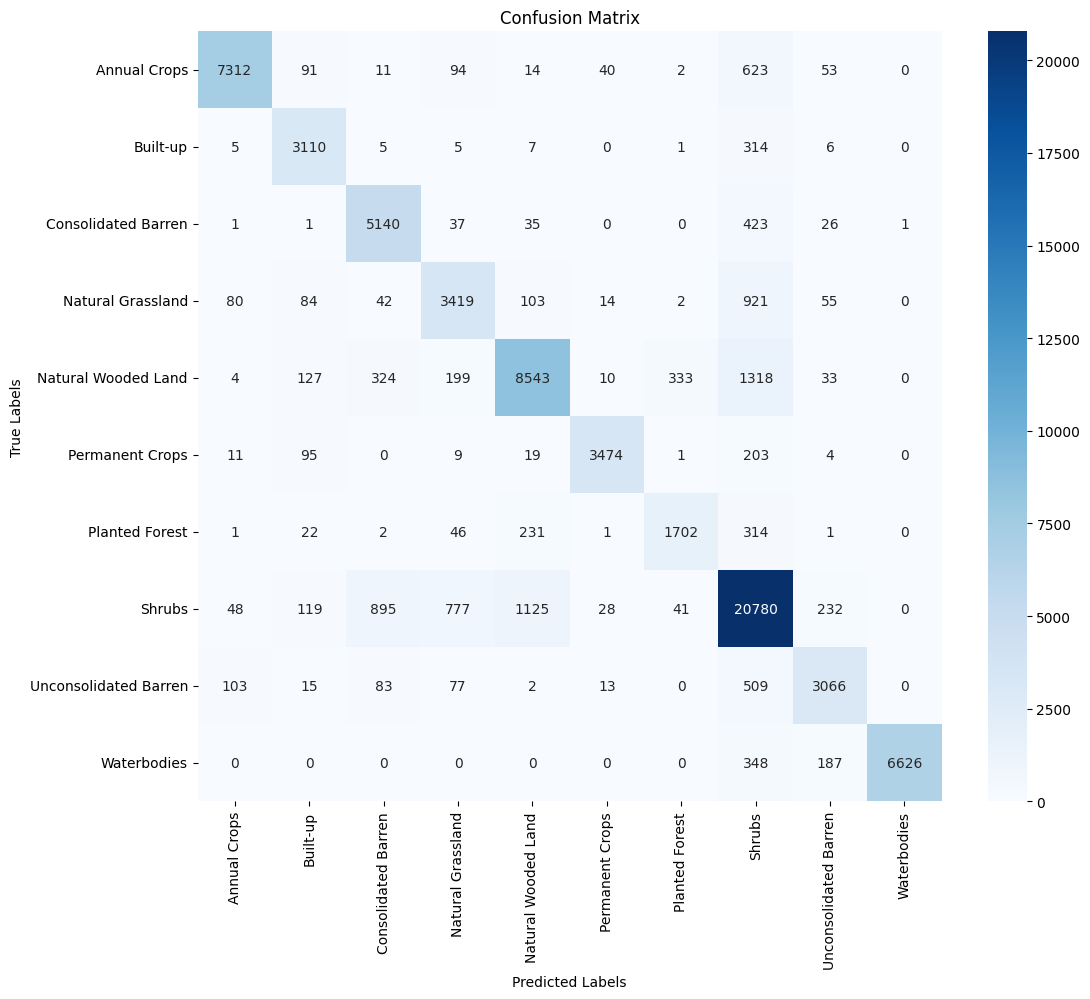

In [ ]:
# Use the `plot_confusion_matrix` function to visualize the model's classification performance.
# Plot the Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Load and visualize individual images

In [ ]:
filtered_samples_df = samples_df[['Sample_num', 'Label', 'File']].drop_duplicates()
for index, row in filtered_samples_df.iterrows():
  image_path = os.path.join(images_path, row['File'])
  if os.path.exists(image_path):
    load_predict_and_visualize(image_path, row['Label'], model, label_encoder)
  else:
    print(f"File not found: {image_path}")

### Image-Level Confusion Matrix

In [ ]:
# Predict per-pixel labels using the trained model
y_pred_prob = model.predict(X_test)
y_pred_pixel = np.argmax(y_pred_prob, axis=1)

# Add predicted pixel labels to test_df
test_df['Predicted_Pixel_Label'] = y_pred_pixel

# Compute majority predicted label for each image
image_predictions = (
    test_df.groupby('Sample_num')['Predicted_Pixel_Label']
    .apply(lambda x: x.mode()[0])
    .reset_index()
    .rename(columns={'Predicted_Pixel_Label': 'Predicted_Image_Label'})
)

# Add ground truth labels
image_predictions = image_predictions.merge(
    labels_df[['Sample_num', 'Class']],
    on='Sample_num',
    how='left'
).rename(columns={'Class': 'Ground_Truth_Label'})

# Encode labels
image_predictions['Encoded_Ground_Truth'] = label_encoder.transform(image_predictions['Ground_Truth_Label'])
image_predictions['Encoded_Predicted_Label'] = label_encoder.transform(image_predictions['Predicted_Image_Label'])

# Compute confusion matrix
cm = confusion_matrix(
    image_predictions['Encoded_Ground_Truth'],
    image_predictions['Encoded_Predicted_Label'],
    labels=range(len(label_encoder.classes_))
)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="viridis", xticks_rotation=45)
plt.title("Image-Level Confusion Matrix")
plt.show()


2319/2319 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


<ipython-input-72-e99d6d1c85e0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted_Pixel_Label'] = y_pred_pixel


ValueError: y contains previously unseen labels: 7

## Training CNN (Not using Oversampling or Class Weights)

---



### PreProcessing

In [ ]:
# Load Data
samples_df, labels_df = load_data(samples_path, labels_path)

########################  TEMPORARILY REMOVE WETLANDS  #########################
samples_df, labels_df = remove_wetlands(samples_df, labels_df)
########################  TEMPORARILY REMOVE WETLANDS  #########################

# Preprocess Data
samples_df, labels_df, label_encoder = preprocess_data(samples_df, labels_df)

# Ensure samples_df includes only the valid Sample_num values found in labels_df
valid_sample_nums = labels_df['Sample_num'].unique()
samples_df = samples_df[samples_df['Sample_num'].isin(valid_sample_nums)]

# Columns `frq0` to `frq372` are bands
frequency_cols = [col for col in samples_df.columns if 'frq' in col]

Successfully removed 'Wetlands' from the dataset.


In [ ]:
# Map Ground_Truth labels using the Sample_num (Used for testing)
pixel_counts_df, mismatches = map_ground_truth(samples_df, labels_df)

# Call the verification function after PreProcessing
test_results = verify_data_alignment(samples_df, labels_df, pixel_counts_df, mismatches, frequency_cols)


Verification Results:
Test 1: No mismatches between Label and Ground_Truth - PASSED :)
Test 2: All Sample_num values in labels_df are present in pixel_counts_df - PASSED :)
Test 3: No missing Sample_num values in samples_df - PASSED :)
Test 4: No entries filtered out due to all -9999 values - PASSED :)
Test 5: Unique Sample_num count matches between labels_df and filtered_samples_df - PASSED :)


In [ ]:
# Create a DataFrame with unique images and their labels
image_labels_df = samples_df[['Sample_num', 'Label_Encoded']].drop_duplicates()

# Stratified splitting at the image level
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(sss.split(image_labels_df['Sample_num'], image_labels_df['Label_Encoded']))

# Get the Sample_num for training and testing
train_sample_nums = image_labels_df['Sample_num'].iloc[train_indices]
test_sample_nums = image_labels_df['Sample_num'].iloc[test_indices]

# Create training and testing DataFrames
train_df = samples_df[samples_df['Sample_num'].isin(train_sample_nums)]
test_df = samples_df[samples_df['Sample_num'].isin(test_sample_nums)]

# Extract features and labels for training and testing sets
X_train = train_df[frequency_cols].values
y_train = train_df['Label_Encoded'].values
X_test = test_df[frequency_cols].values
y_test = test_df['Label_Encoded'].values

# Model parameters
input_shape = (X_train.shape[1], 1)
num_classes = len(label_encoder.classes_)

# Convert labels to One-Hot Encoding
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Add a channel dimension for Conv1D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train_cat.shape, y_test_cat.shape)

(289299, 373, 1) (74178, 373, 1)
(289299, 10) (74178, 10)


### Data Visualization

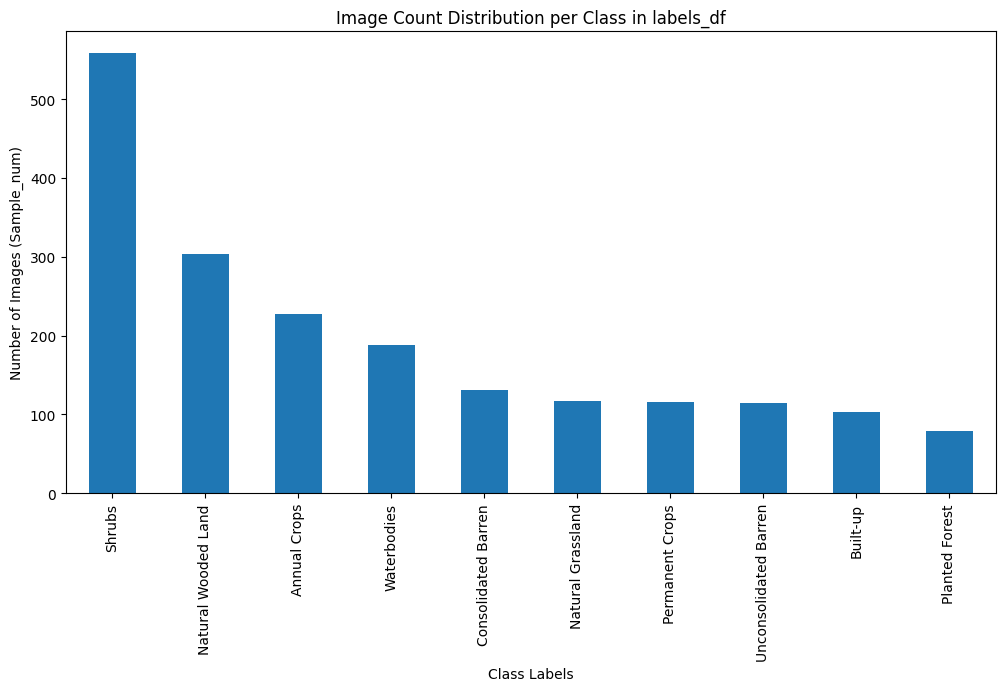

Class distribution in labels_df:
 Class
Shrubs                   558
Natural Wooded Land      304
Annual Crops             227
Waterbodies              188
Consolidated Barren      131
Natural Grassland        117
Permanent Crops          116
Unconsolidated Barren    114
Built-up                 103
Planted Forest            79
Name: count, dtype: int64


In [ ]:
# Get the Labels Class Dsitribution
plot_label_distribution(labels_df, label_column='Class')

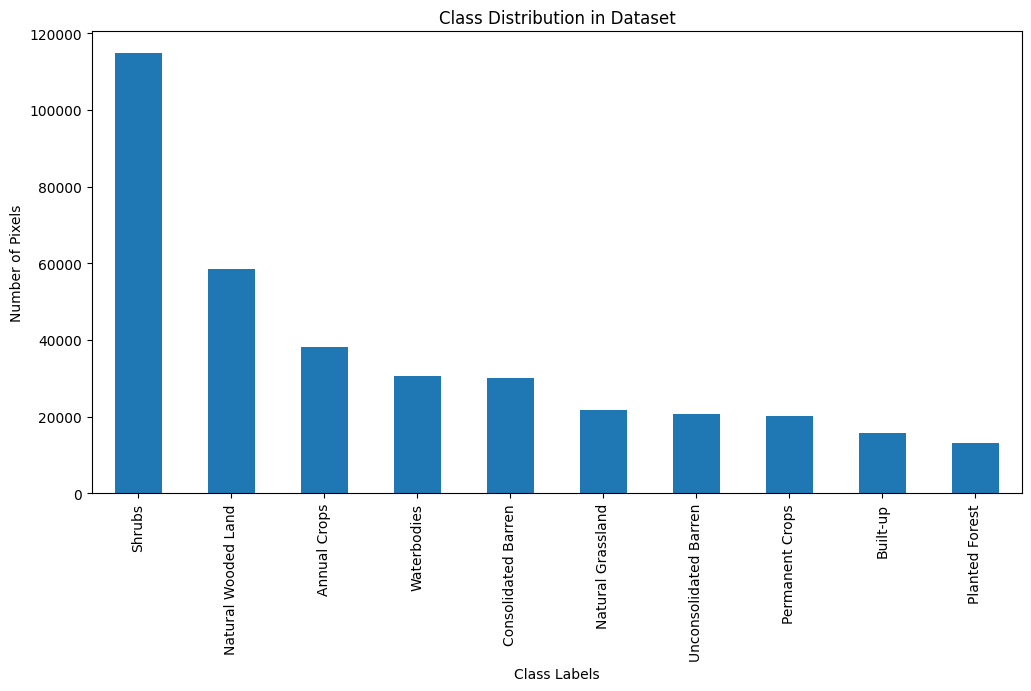

Class label counts:
 Label
Shrubs                   114740
Natural Wooded Land       58477
Annual Crops              38055
Waterbodies               30652
Consolidated Barren       30035
Natural Grassland         21760
Unconsolidated Barren     20587
Permanent Crops           20198
Built-up                  15849
Planted Forest            13124
Name: count, dtype: int64


In [ ]:
# Get the Pixels per Class Dsitribution
plot_class_distribution(samples_df, label_column='Label')

### Define & Train CNN


In [ ]:
# Define callbacks
callbacks = define_callbacks(checkpoint_path)

# Initialize CNN model
model = get_cnn_model(input_shape, num_classes, wd=1e-6, drop_rate=0.3, learning_rate=.0001)
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)                   │ (None, 371, 512)            │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_32 (MaxPooling1D)      │ (None, 185, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_41 (Conv1D)                   │ (None, 183, 256)            │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_33 (MaxPooling1D)      │ (None, 91, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_42 (Conv1D)                   │ (None, 89, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 89, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 11392)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │       1,458,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,961,674 (7.48 MB)

 Trainable params: 1,961,418 (7.48 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# Train the model
history = train_model(model, X_train, y_train_cat, X_test, y_test_cat, epochs=30, batch_size=32)

Epoch 1/30
9041/9041 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5039 - loss: 1.4906
Epoch 1: val_accuracy improved from -inf to 0.65576, saving model to /content/drive/My Drive/.School/Capstone/model_checkpoints_Benz_Testing/my_weights.weights.h5
9041/9041 ━━━━━━━━━━━━━━━━━━━━ 115s 12ms/step - accuracy: 0.5039 - loss: 1.4905 - val_accuracy: 0.6558 - val_loss: 1.0208 - learning_rate: 1.0000e-04
Epoch 2/30
9036/9041 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6496 - loss: 1.0129
Epoch 2: val_accuracy improved from 0.65576 to 0.67711, saving model to /content/drive/My Drive/.School/Capstone/model_checkpoints_Benz_Testing/my_weights.weights.h5
9041/9041 ━━━━━━━━━━━━━━━━━━━━ 136s 12ms/step - accuracy: 0.6496 - loss: 1.0129 - val_accuracy: 0.6771 - val_loss: 0.9800 - learning_rate: 1.0000e-04
Epoch 3/30
9039/9041 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6833 - loss: 0.8872
Epoch 3: val_accuracy improved from 0.67711 to 0.68894, saving model to /content/drive/My Drive/.School/

### Test Model Performance

In [ ]:
# Get the testing Acc. after training
test_accuracy = evaluate_model(model, X_test, y_test_cat)
print("Final Test Accuracy:", test_accuracy)

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7185 - loss: 0.9711
Test Accuracy: 0.6894
Final Test Accuracy: 0.6893553137779236


### Post-Training Visualization

In [ ]:
# Get predictions on the test set
y_test_labels, y_pred_labels, _, _  = get_predictions(model, X_test, y_test_cat, label_encoder)

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step


In [ ]:
# Get the Classification Report usung sklearn.metrics
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

                       precision    recall  f1-score   support

         Annual Crops       0.74      0.74      0.74      8240
             Built-up       0.79      0.85      0.82      3453
  Consolidated Barren       0.53      0.64      0.58      5664
    Natural Grassland       0.43      0.23      0.30      4720
  Natural Wooded Land       0.69      0.61      0.65     10891
      Permanent Crops       0.84      0.66      0.74      3816
       Planted Forest       0.75      0.57      0.65      2320
               Shrubs       0.65      0.80      0.72     24045
Unconsolidated Barren       0.52      0.32      0.40      3868
          Waterbodies       1.00      0.91      0.95      7161

             accuracy                           0.69     74178
            macro avg       0.69      0.63      0.65     74178
         weighted avg       0.69      0.69      0.68     74178



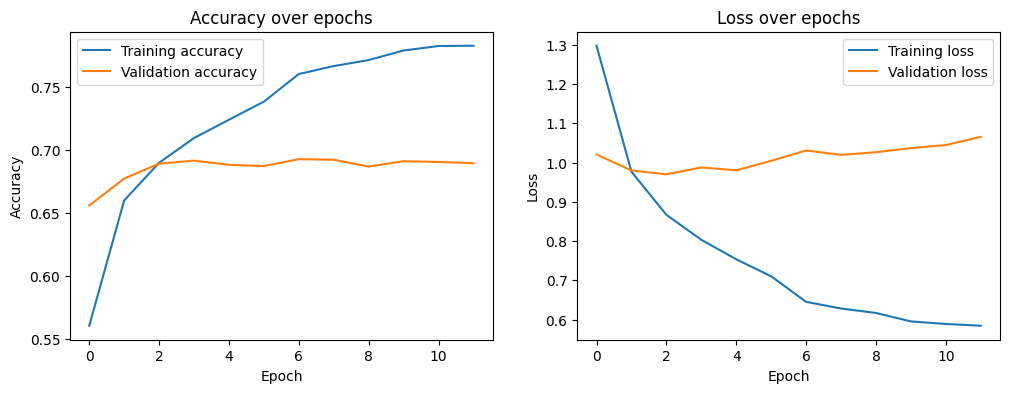

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

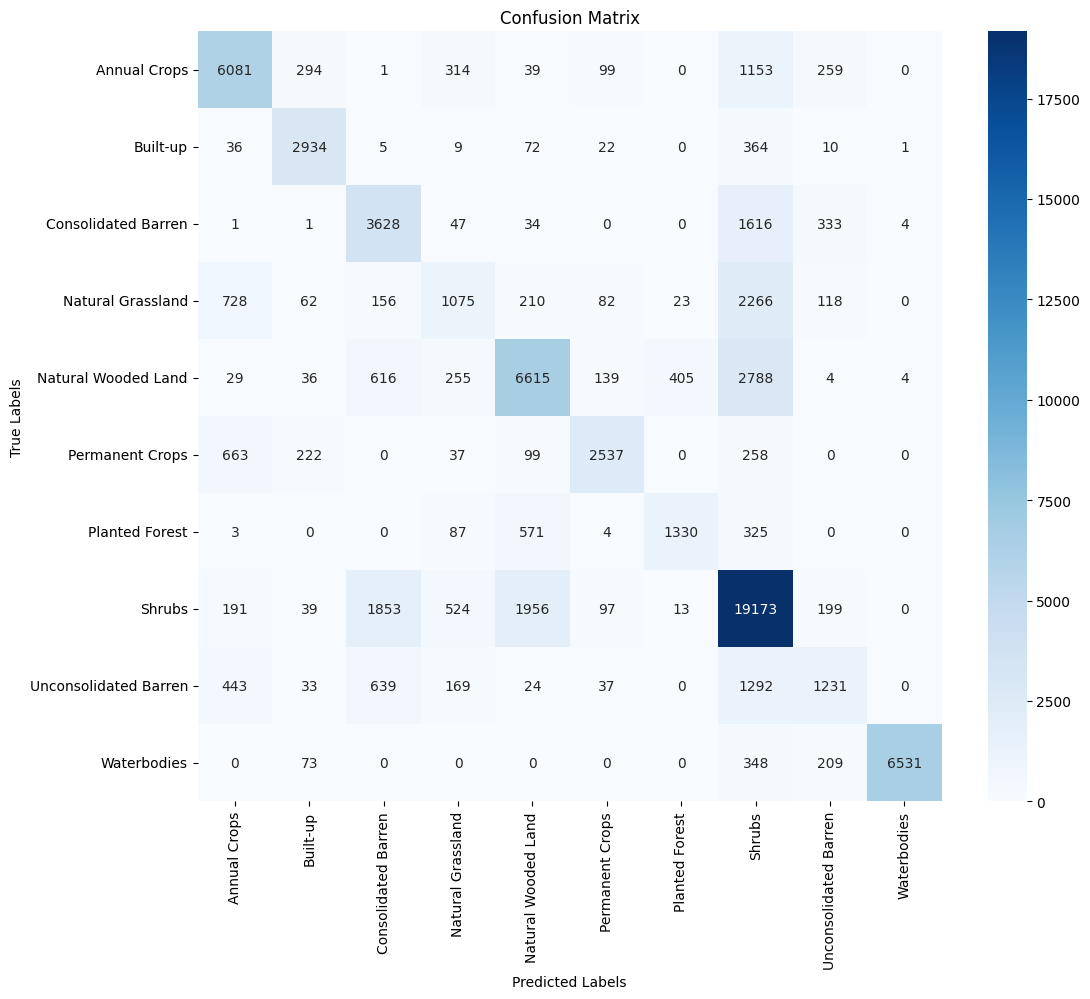

In [ ]:
# Plot the Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

File not found: /content/drive/My Drive/.School/Capstone/valid_samples_1d/avirisng_samples_combined/1_ang20231028t101421_014_L2A_OE_main_27577724_RFL_ORT.tif
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


<ipython-input-29-29d852e9250e>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", num_classes)


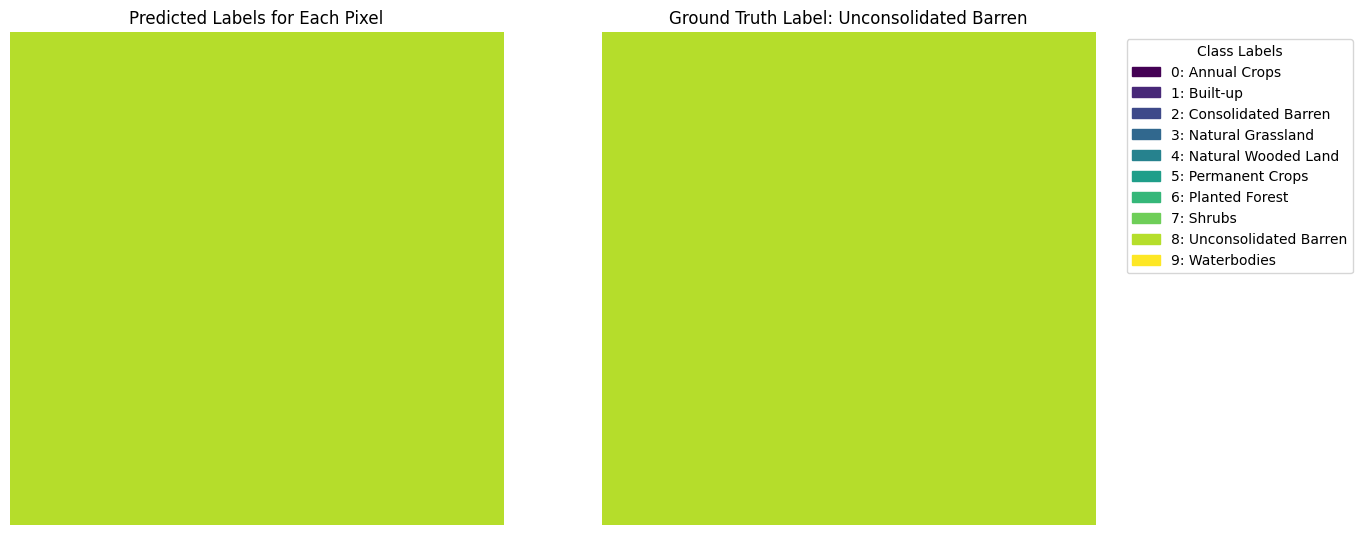

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


<ipython-input-29-29d852e9250e>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", num_classes)


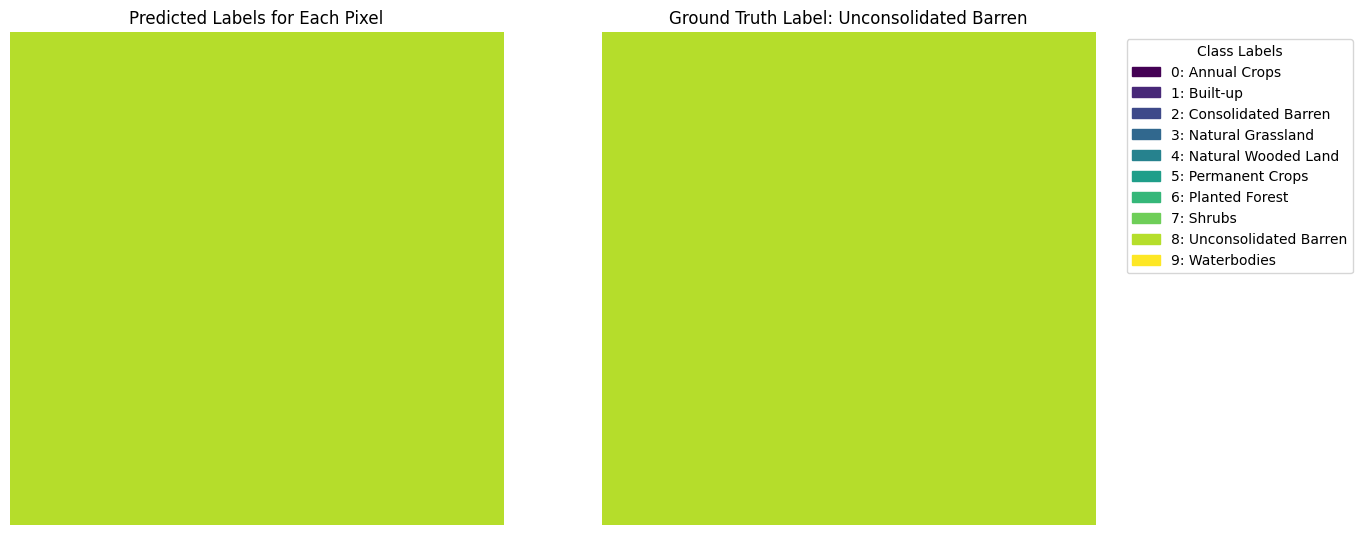

File not found: /content/drive/My Drive/.School/Capstone/valid_samples_1d/avirisng_samples_combined/3_ang20231028t095542_011_L2A_OE_main_27577724_RFL_ORT.tif
File not found: /content/drive/My Drive/.School/Capstone/valid_samples_1d/avirisng_samples_combined/3_ang20231028t100428_001_L2A_OE_main_27577724_RFL_ORT.tif
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<ipython-input-29-29d852e9250e>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", num_classes)


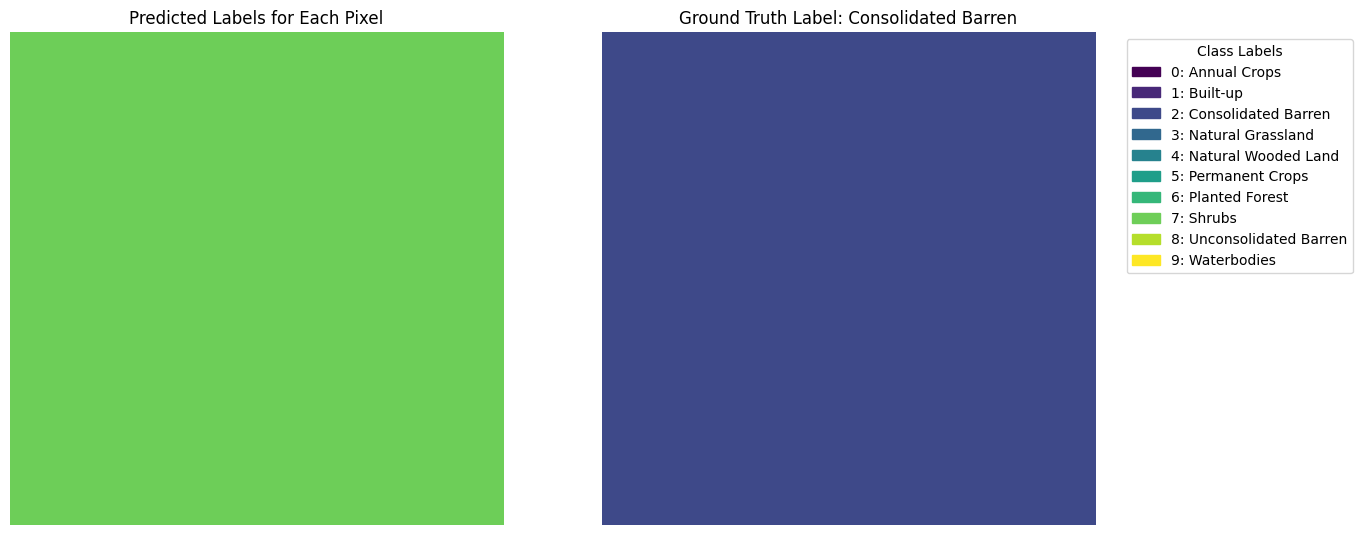

File not found: /content/drive/My Drive/.School/Capstone/valid_samples_1d/avirisng_samples_combined/4_ang20231028t101421_009_L2A_OE_main_27577724_RFL_ORT.tif
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


<ipython-input-29-29d852e9250e>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", num_classes)


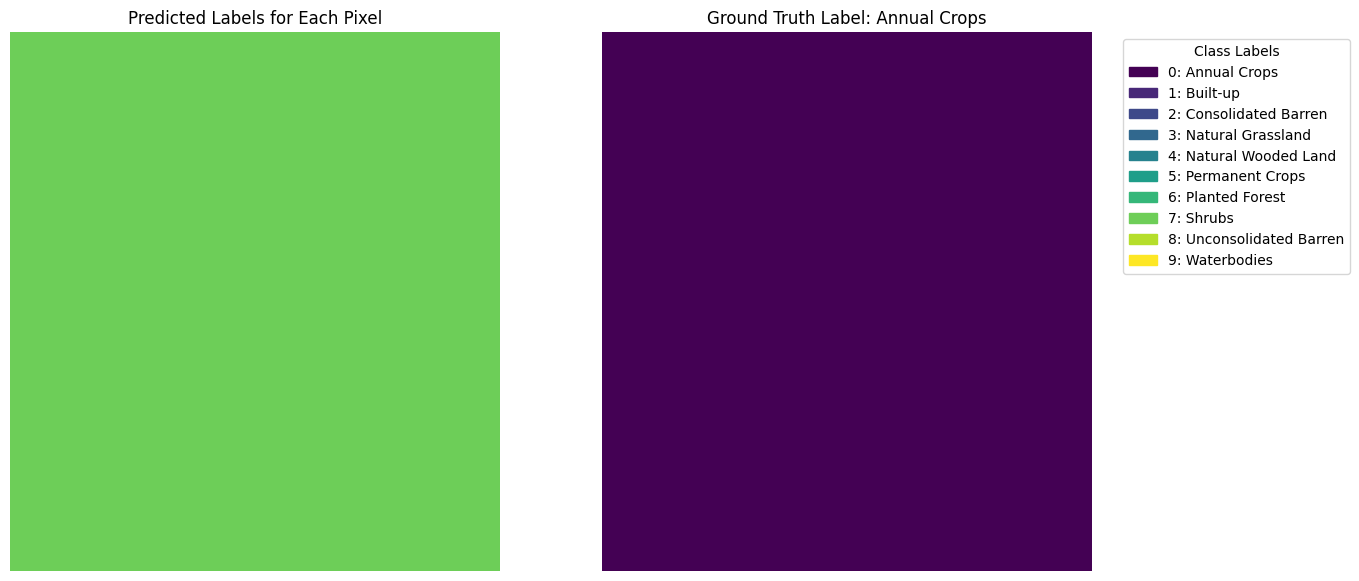

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<ipython-input-29-29d852e9250e>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", num_classes)


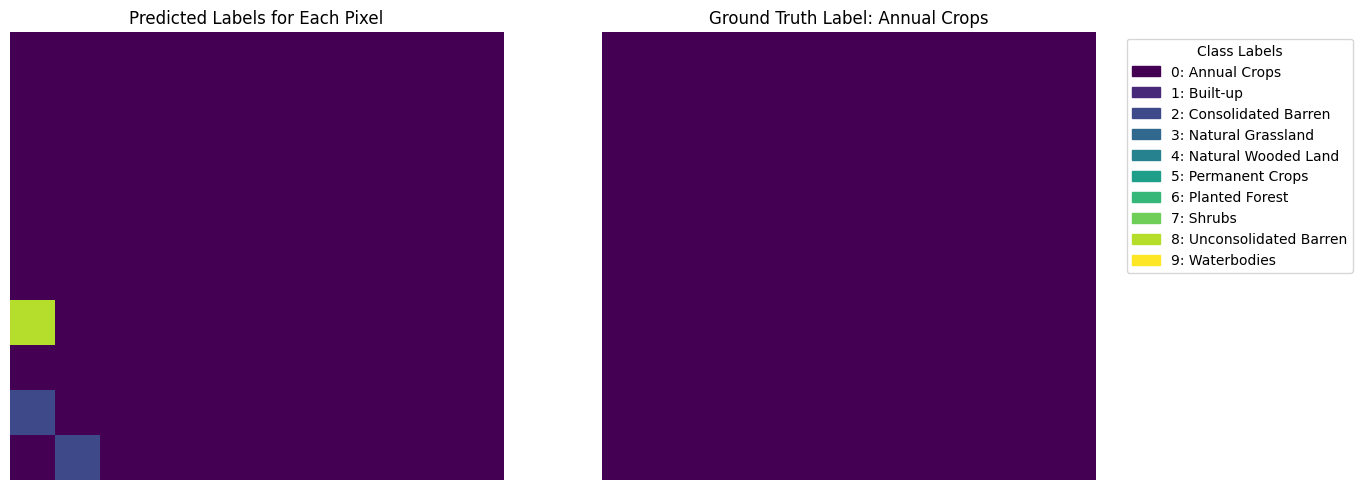

File not found: /content/drive/My Drive/.School/Capstone/valid_samples_1d/avirisng_samples_combined/6_ang20231028t102348_005_L2A_OE_main_27577724_RFL_ORT.tif
File not found: /content/drive/My Drive/.School/Capstone/valid_samples_1d/avirisng_samples_combined/7_ang20231028t102348_005_L2A_OE_main_27577724_RFL_ORT.tif
File not found: /content/drive/My Drive/.School/Capstone/valid_samples_1d/avirisng_samples_combined/7_ang20231028t101421_010_L2A_OE_main_27577724_RFL_ORT.tif
File not found: /content/drive/My Drive/.School/Capstone/valid_samples_1d/avirisng_samples_combined/8_ang20231028t101421_009_L2A_OE_main_27577724_RFL_ORT.tif
File not found: /content/drive/My Drive/.School/Capstone/valid_samples_1d/avirisng_samples_combined/10_ang20231028t102348_006_L2A_OE_main_27577724_RFL_ORT.tif
File not found: /content/drive/My Drive/.School/Capstone/valid_samples_1d/avirisng_samples_combined/11_ang20231028t102348_005_L2A_OE_main_27577724_RFL_ORT.tif
File not found: /content/drive/My Drive/.School/Ca

<ipython-input-29-29d852e9250e>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", num_classes)


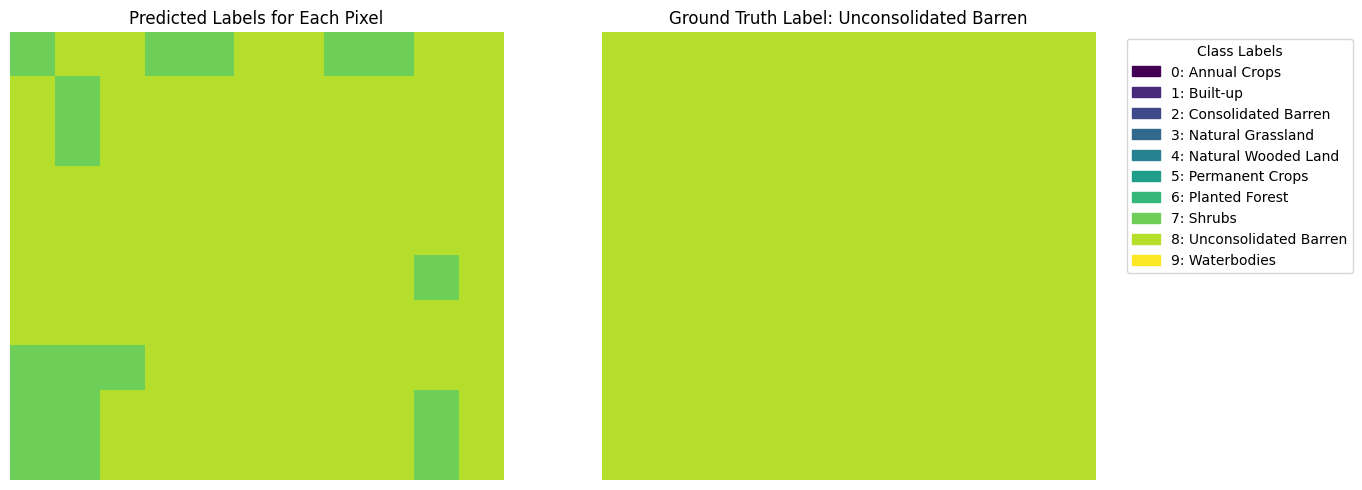

File not found: /content/drive/My Drive/.School/Capstone/valid_samples_1d/avirisng_samples_combined/18_ang20231028t103336_011_L2A_OE_main_27577724_RFL_ORT.tif
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


<ipython-input-29-29d852e9250e>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", num_classes)


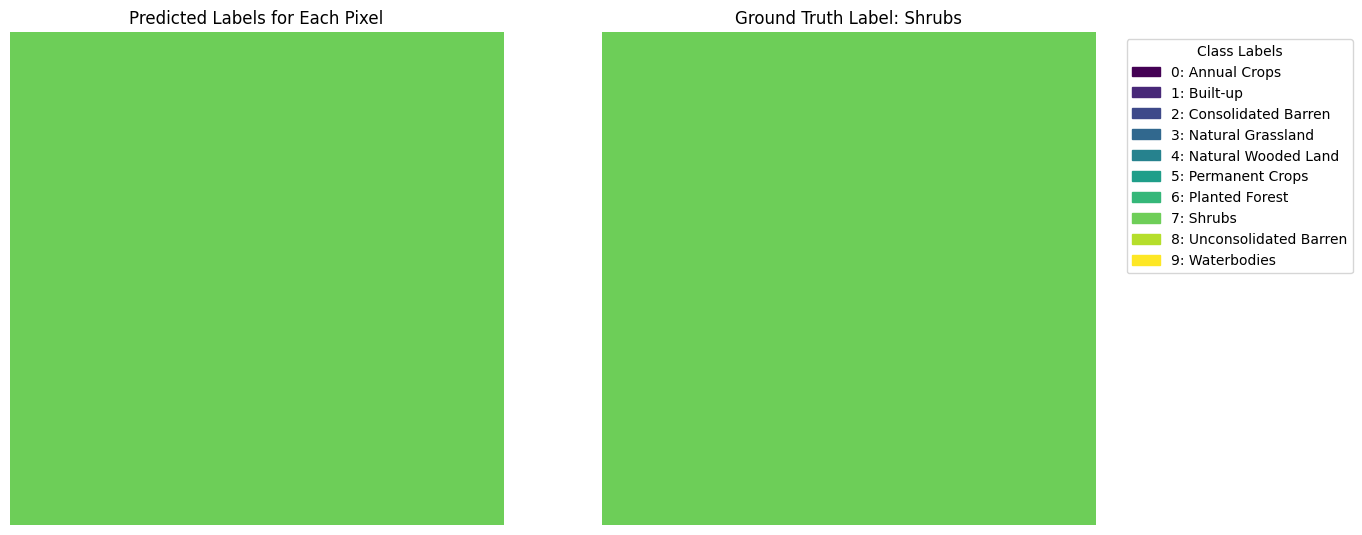

File not found: /content/drive/My Drive/.School/Capstone/valid_samples_1d/avirisng_samples_combined/23_ang20231028t102348_007_L2A_OE_main_27577724_RFL_ORT.tif
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


<ipython-input-29-29d852e9250e>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", num_classes)


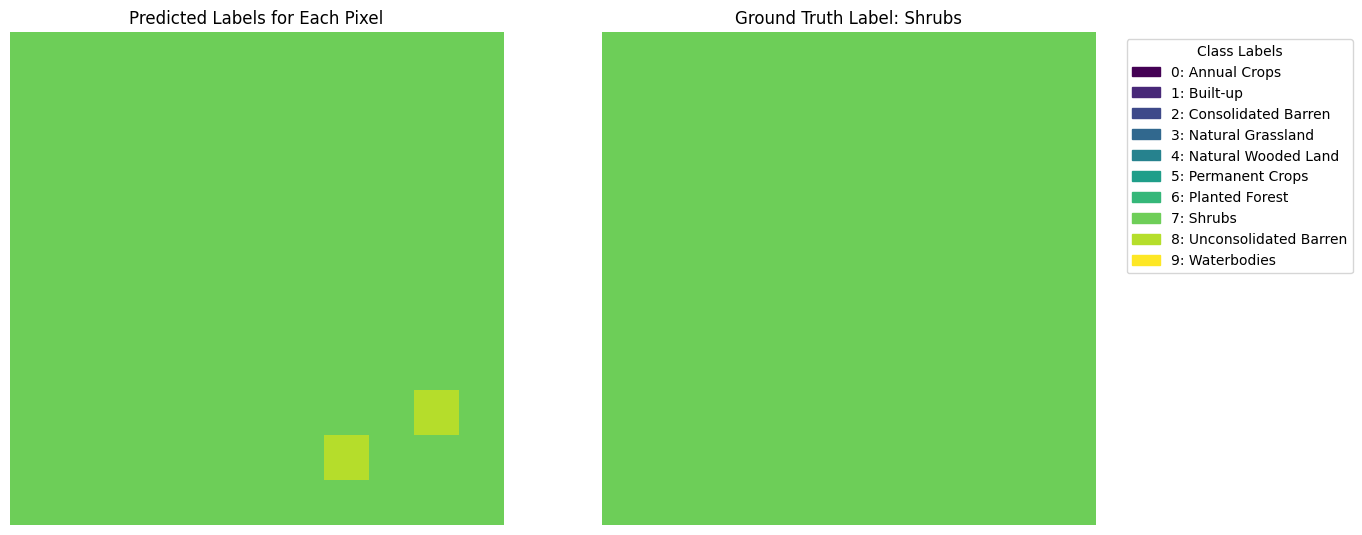

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


<ipython-input-29-29d852e9250e>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", num_classes)


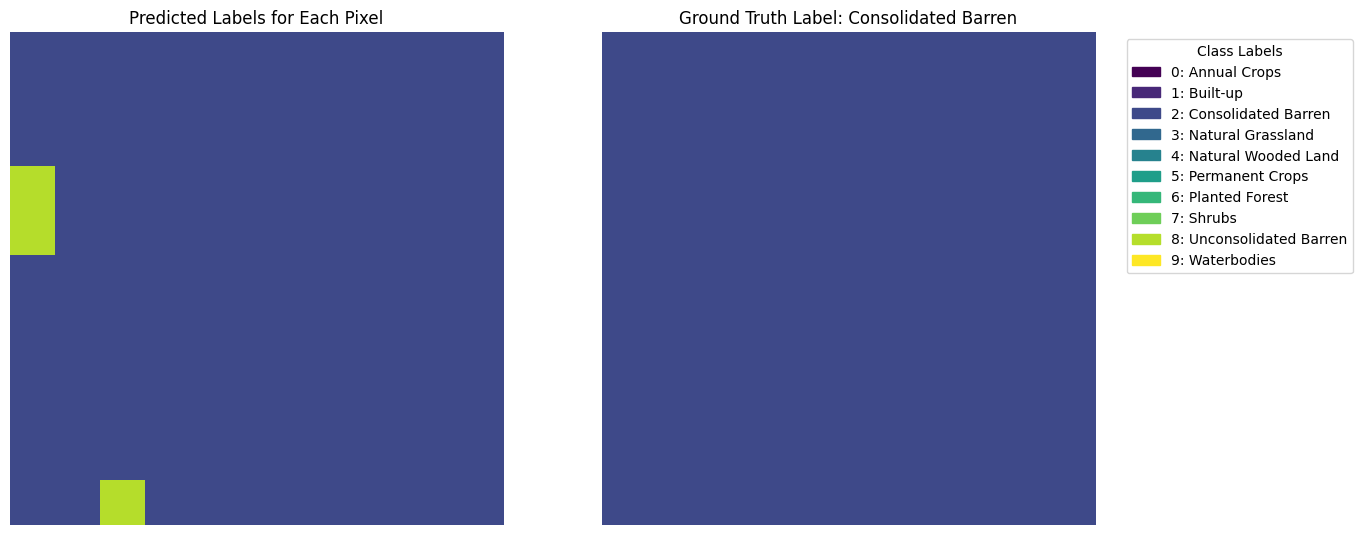

KeyboardInterrupt: 

In [ ]:
# Load and visualize individual images
filtered_samples_df = samples_df[['Sample_num', 'Label', 'File']].drop_duplicates()
for index, row in filtered_samples_df.iterrows():
  image_path = os.path.join(images_path, row['File'])
  if os.path.exists(image_path):
    load_predict_and_visualize(image_path, row['Label'], model, label_encoder)
  else:
    print(f"File not found: {image_path}")

### Plot the Image-Level Confusion Matrix


2319/2319 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


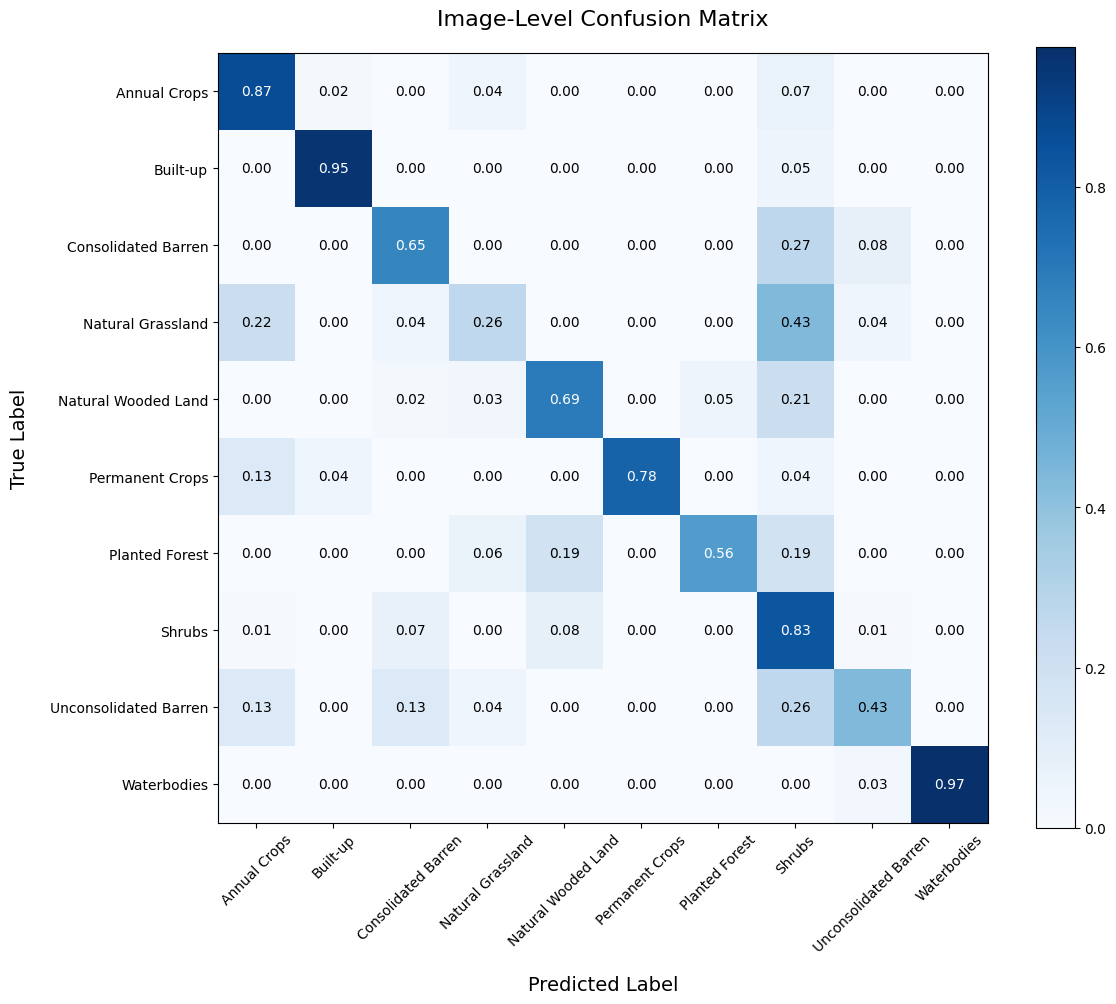

In [ ]:
compute_and_plot_image_level_confusion_matrix(model, test_df, labels_df, label_encoder)

## Training CNN using Oversampling
---



### PreProcessing

In [ ]:
# Load Data
samples_df, labels_df = load_data(samples_path, labels_path)

########################  TEMPORARILY REMOVE WETLANDS  #########################
samples_df, labels_df = remove_wetlands(samples_df, labels_df)
########################  TEMPORARILY REMOVE WETLANDS  #########################

# Preprocess Data
samples_df, labels_df, label_encoder = preprocess_data(samples_df, labels_df)

# Ensure samples_df includes only the valid Sample_num values found in labels_df
valid_sample_nums = labels_df['Sample_num'].unique()
samples_df = samples_df[samples_df['Sample_num'].isin(valid_sample_nums)]

# Columns `frq0` to `frq372` are bands
frequency_cols = [col for col in samples_df.columns if 'frq' in col]

Successfully removed 'Wetlands' from the dataset.


In [ ]:
# Map Ground_Truth labels using the Sample_num (Used for testing)
pixel_counts_df, mismatches = map_ground_truth(samples_df, labels_df)

# Call the verification function after PreProcessing
test_results = verify_data_alignment(samples_df, labels_df, pixel_counts_df, mismatches, frequency_cols)


Verification Results:
Test 1: No mismatches between Label and Ground_Truth - PASSED :)
Test 2: All Sample_num values in labels_df are present in pixel_counts_df - PASSED :)
Test 3: No missing Sample_num values in samples_df - PASSED :)
Test 4: No entries filtered out due to all -9999 values - PASSED :)
Test 5: Unique Sample_num count matches between labels_df and filtered_samples_df - PASSED :)


In [ ]:
# Get unique sample_nums and their labels
sample_nums_df = samples_df[['Sample_num', 'Label']].drop_duplicates()

# Encode labels
label_encoder = LabelEncoder()
sample_nums_df['Label_Encoded'] = label_encoder.fit_transform(sample_nums_df['Label'])

# Split sample_nums into training and test sets, stratified by labels
train_sample_nums, test_sample_nums = train_test_split(
    sample_nums_df['Sample_num'],
    test_size=0.2,
    stratify=sample_nums_df['Label'],
    random_state=42
)

# Training data
train_df = samples_df[samples_df['Sample_num'].isin(train_sample_nums)].copy()

# Test data
test_df = samples_df[samples_df['Sample_num'].isin(test_sample_nums)].copy()

# Encode labels in training and test data
train_df['Label_Encoded'] = label_encoder.transform(train_df['Label'])
test_df['Label_Encoded'] = label_encoder.transform(test_df['Label'])

# Extract X and y
X_train = train_df[frequency_cols].values
y_train = train_df['Label_Encoded'].values

X_test = test_df[frequency_cols].values
y_test = test_df['Label_Encoded'].values

# Model params
input_shape = (X_train.shape[1], 1)
num_classes = len(label_encoder.classes_)

# Convert labels to One-Hot Encoding
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Add a channel dimension for Conv1D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Using Oversampling/Augmentation

#### Split Data into Train & Test

In [ ]:
# These are taken from above as well as verifying from actually looking them up
# NOTE: I am not oversampling Built-up or Waterbodies cause they are both really easy to identify shown by stats
oversample_images = {
    'Consolidated Barren': [2051, 21902, 2067, 9620, 2070, 10781, 7080, 10790, 20392, 7081, 7082, 7083, 7084, 7085, 9390, 7983, 9391, 22192, 7092, 7093, 7094, 9398, 7100, 7102, 7103, 20417, 7106, 8005, 21061, 2375, 22982, 24262, 4556, 8018, 8404, 8405, 22872, 4698, 9574, 9576, 9066, 8304, 8305, 8306, 7416, 8185, 8186, 8187, 5374, 4859],
    'Natural Grassland': [7424, 5634, 27138, 7947, 7692, 25228, 7701, 3991, 6009, 7708, 7711, 2848, 6052, 11812, 5414, 9510, 6952, 24997, 6827, 5936, 6192, 7984, 10801, 6973, 7742, 5063, 8520, 5065, 6602, 7881, 7118, 11087, 4822, 5594, 11103, 9442, 7011, 7652, 6757, 7013, 7656, 3435, 3437, 3565, 26095, 26353, 8825, 28026, 4731, 5629],
    'Unconsolidated Barren': [1, 2, 10883, 20610, 21639, 11, 20758, 26, 11682, 11683, 11684, 11685, 21671, 1065, 8235, 20013, 7342, 26416, 20026, 8507, 20034, 20676, 8141, 213, 20056, 10714, 10715, 10716, 10717, 10718, 10719, 10720, 10721, 10722, 10723, 10724, 10725, 10726, 10727, 20839, 27751, 20591, 11633, 11634, 11635, 7412, 20084, 20087, 22234, 20090],
    'Planted Forest': [7303, 5899, 5771, 8460, 5389, 5396, 5653, 5403, 5919, 8226, 8227, 2853, 5931, 5421, 7982, 5422, 6318, 5684, 5686, 5687, 5944, 5945, 6328, 6331, 6460, 5949, 5950, 6334, 5579, 5707, 5710, 5711, 6352, 5713, 5586, 5587, 5968, 5464, 5977, 5473, 5477, 5481, 5611, 5613, 5487, 5999, 6000, 6386, 6387, 6005],
    'Permanent Crops': [24067, 27268, 22533, 2829, 3983, 23444, 24084, 21782, 26263, 24856, 27163, 6044, 27547, 21022, 6046, 25249, 23715, 5028, 23849, 23724, 8495, 8496, 8497, 5042, 24115, 5043, 23608, 25789, 23623, 21964, 27597, 23252, 8406, 8407, 21209, 21983, 26336, 21985, 24930, 24041, 20971, 4855, 24178, 27251, 24950, 26871, 27643, 3708, 23166, 5887],
    'Annual Crops': [1538, 3331, 4, 3205, 2950, 7, 3078, 4739, 266, 4998, 1429, 8471, 3992, 7835, 2204, 5408, 2980, 4009, 3120, 1585, 3248, 1588, 2872, 5563, 3516, 1470, 8386, 4931, 1092, 1604, 2885, 10438, 1224, 5453, 8527, 1619, 3795, 3798, 1629, 3294, 2402, 1507, 3044, 2407, 4840, 1645, 3187, 4854, 3831, 3833],
}


In [ ]:
# Determine the size of the largest class in the training set
largest_class_size = train_df['Label'].value_counts().max()

# Define target sizes for each class in oversample_images
percentage = 30
target_size_per_class = {
    class_label: max(
        len(train_df[train_df['Label'] == class_label]),
        int(largest_class_size * (percentage / 100))
    )
    for class_label in oversample_images.keys()
}

In [ ]:
# Update oversample_images to include only Sample_nums in training set
oversample_images_in_training_set = {
    class_label: [
        sample_num for sample_num in sample_nums
        if sample_num in train_df['Sample_num'].unique()
    ]
    for class_label, sample_nums in oversample_images.items()
}
oversample_images = oversample_images_in_training_set

# Display updated oversample_images
for class_label, sample_nums in oversample_images.items():
    print(f"Class: {class_label}")
    print(f"Number of Sample_num: {len(sample_nums)}")
    print(f"Sample_num: {sample_nums}\n")

Class: Consolidated Barren
Number of Sample_num: 39
Sample_num: [2051, 2067, 9620, 10781, 10790, 20392, 7081, 7082, 7083, 7084, 7085, 9390, 7983, 9391, 22192, 7092, 7093, 7094, 9398, 7100, 7102, 7103, 20417, 8005, 21061, 22982, 8018, 8404, 8405, 22872, 4698, 9576, 9066, 8304, 8306, 8185, 8186, 5374, 4859]

Class: Natural Grassland
Number of Sample_num: 41
Sample_num: [5634, 27138, 7947, 7692, 25228, 7701, 3991, 7708, 7711, 2848, 6052, 11812, 5414, 9510, 6952, 6827, 5936, 6192, 10801, 6973, 7742, 5063, 8520, 5065, 6602, 7881, 7118, 11087, 4822, 11103, 9442, 7011, 7652, 6757, 7656, 3435, 3437, 3565, 8825, 28026, 4731]

Class: Unconsolidated Barren
Number of Sample_num: 41
Sample_num: [1, 2, 10883, 20610, 11, 20758, 26, 11682, 11683, 11684, 11685, 21671, 1065, 20013, 7342, 26416, 20026, 8507, 20034, 8141, 213, 20056, 10714, 10715, 10716, 10717, 10719, 10721, 10722, 10723, 10724, 10725, 10726, 20591, 11633, 11634, 11635, 20084, 20087, 22234, 20090]

Class: Planted Forest
Number of Sample_n

In [ ]:
# Apply augmentation
augmented_train_df = augment_data(
    train_df,
    oversample_images_in_training_set,
    target_size_per_class,
    frequency_cols
)

# Shuffle the augmented data
augmented_train_df = augmented_train_df.sample(frac=1, random_state=42).reset_index(drop=True)


Augmenting class 'Consolidated Barren':
Current total size: 24371, Target size: 27208, Samples needed: 2837

Augmenting class 'Natural Grassland':
Current total size: 17040, Target size: 27208, Samples needed: 10168

Augmenting class 'Unconsolidated Barren':
Current total size: 16719, Target size: 27208, Samples needed: 10489

Augmenting class 'Planted Forest':
Current total size: 10804, Target size: 27208, Samples needed: 16404

Augmenting class 'Permanent Crops':
Current total size: 16382, Target size: 27208, Samples needed: 10826

Augmenting class 'Annual Crops':
Current total size: 29815, Target size: 29815, Samples needed: 0


#### Verify


Class distribution after oversampling:
Label
Shrubs                   90695
Natural Wooded Land      47586
Annual Crops             29815
Unconsolidated Barren    27208
Planted Forest           27208
Permanent Crops          27208
Consolidated Barren      27208
Natural Grassland        27208
Waterbodies              23491
Built-up                 12396
Name: count, dtype: int64


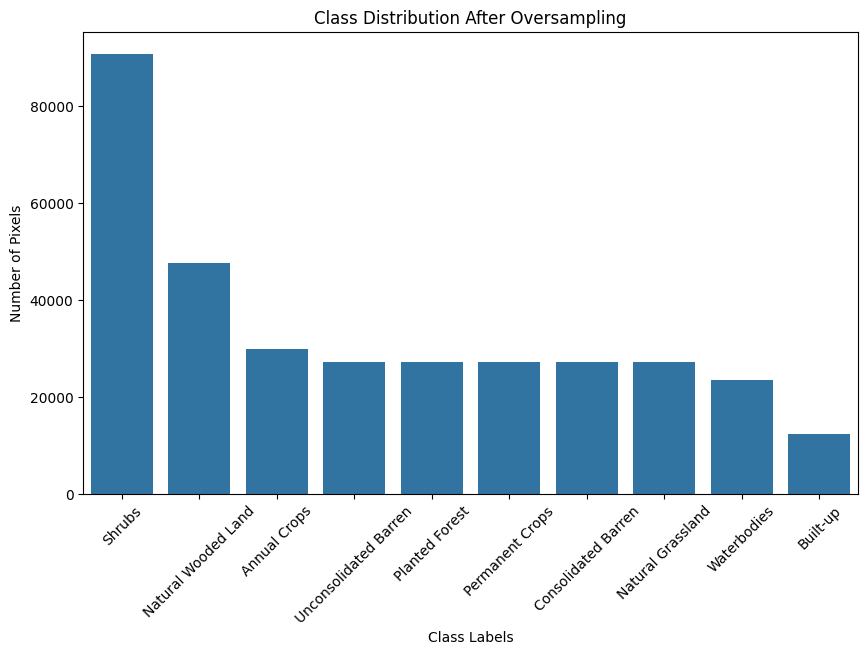

In [ ]:
# Verify the distribution of labels in the oversampled DataFrame
augmented_train_df_counts = augmented_train_df['Label'].value_counts()
print("\nClass distribution after oversampling:")
print(augmented_train_df_counts)

# Plot the distribution for visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=augmented_train_df_counts.index, y=augmented_train_df_counts.values)
plt.title("Class Distribution After Oversampling")
plt.xlabel("Class Labels")
plt.ylabel("Number of Pixels")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Ensure class labels are consistent before and after oversampling
original_classes = set(train_df['Label'].unique())
oversampled_classes = set(augmented_train_df['Label'].unique())

assert original_classes == oversampled_classes, "Mismatch in classes before and after oversampling."
print("Classes are consistent before and after oversampling.")

# Verify that classes not intended for oversampling remain unchanged
classes_not_oversampled = original_classes - set(oversample_images.keys())

for class_label in classes_not_oversampled:
    original_size = len(train_df[train_df['Label'] == class_label])
    oversampled_size = len(augmented_train_df[augmented_train_df['Label'] == class_label])
    assert original_size == oversampled_size, (
        f"Class '{class_label}' size changed unexpectedly from {original_size} to {oversampled_size}."
    )
    print(f"Class '{class_label}' size remains unchanged at {original_size} samples.")

Classes are consistent before and after oversampling.
Class 'Waterbodies' size remains unchanged at 23491 samples.
Class 'Shrubs' size remains unchanged at 90695 samples.
Class 'Natural Wooded Land' size remains unchanged at 47586 samples.
Class 'Built-up' size remains unchanged at 12396 samples.


#### Data Display


Class label counts in training data (number of pixels):
 Label
Shrubs                   90695
Natural Wooded Land      47586
Annual Crops             29815
Consolidated Barren      24371
Waterbodies              23491
Natural Grassland        17040
Unconsolidated Barren    16719
Permanent Crops          16382
Built-up                 12396
Planted Forest           10804
Name: count, dtype: int64

Class label counts in testing data (number of pixels):
 Label
Shrubs                   24045
Natural Wooded Land      10891
Annual Crops              8240
Waterbodies               7161
Consolidated Barren       5664
Natural Grassland         4720
Unconsolidated Barren     3868
Permanent Crops           3816
Built-up                  3453
Planted Forest            2320
Name: count, dtype: int64


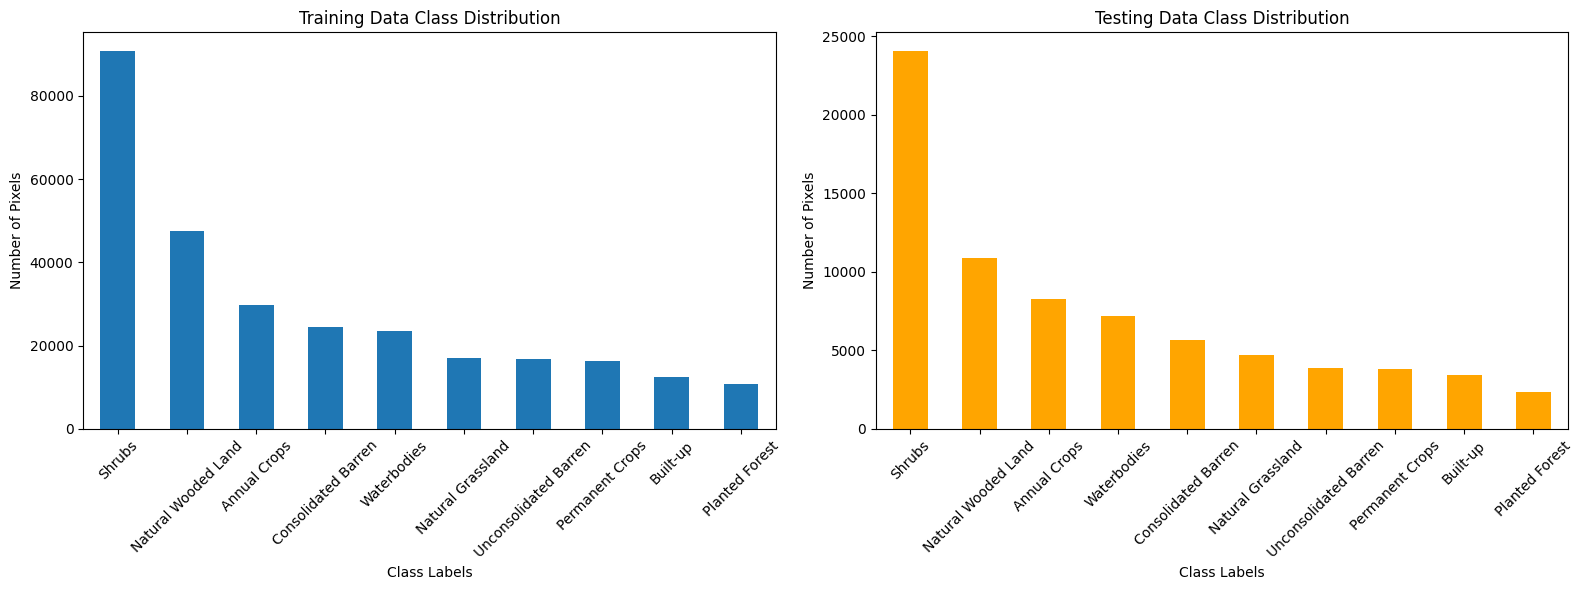

In [ ]:
# Calculate class counts in training data
train_class_counts = train_df['Label'].value_counts()
print("\nClass label counts in training data (number of pixels):\n", train_class_counts)

# Calculate class counts in testing data
test_class_counts = test_df['Label'].value_counts()
print("\nClass label counts in testing data (number of pixels):\n", test_class_counts)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot training data class distribution
train_class_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title("Training Data Class Distribution")
axes[0].set_xlabel("Class Labels")
axes[0].set_ylabel("Number of Pixels")
axes[0].tick_params(axis='x', rotation=45)

# Plot testing data class distribution
test_class_counts.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title("Testing Data Class Distribution")
axes[1].set_xlabel("Class Labels")
axes[1].set_ylabel("Number of Pixels")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Define CNN

In [ ]:
# Extract augmented training data
X_train_augmented = augmented_train_df[frequency_cols].values
y_train_augmented = augmented_train_df['Label_Encoded'].values

# Convert labels to One-Hot Encoding
y_train_augmented_cat = to_categorical(y_train_augmented, num_classes)

# Add a channel dimension for Conv1D
X_train_augmented = X_train_augmented.reshape((X_train_augmented.shape[0], X_train_augmented.shape[1], 1))


In [ ]:
# Define callbacks
callbacks = define_callbacks(checkpoint_path)

# Initialize CNN model
model = get_cnn_model(input_shape, num_classes, wd=1e-6, drop_rate=0.3, learning_rate=0.0001)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 371, 512)            │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 371, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 185, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 183, 256)            │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 91, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 89, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 44, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 42, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1344)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         172,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701,706 (2.68 MB)

 Trainable params: 700,682 (2.67 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# Train the model
history = train_model(
    model,
    X_train_augmented,
    y_train_augmented_cat,
    X_test,
    y_test_cat,
    epochs=50,
    batch_size=32,
)

Epoch 1/50
10626/10626 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4675 - loss: 1.5305
Epoch 1: val_accuracy improved from -inf to 0.64182, saving model to /content/drive/My Drive/.School/Capstone/model_checkpoints_Benz_Testing/my_weights.weights.h5
10626/10626 ━━━━━━━━━━━━━━━━━━━━ 129s 11ms/step - accuracy: 0.4675 - loss: 1.5305 - val_accuracy: 0.6418 - val_loss: 1.0861 - learning_rate: 1.0000e-04
Epoch 2/50
10622/10626 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6502 - loss: 0.9986
Epoch 2: val_accuracy did not improve from 0.64182
10626/10626 ━━━━━━━━━━━━━━━━━━━━ 117s 11ms/step - accuracy: 0.6502 - loss: 0.9986 - val_accuracy: 0.4921 - val_loss: 1.4339 - learning_rate: 1.0000e-04
Epoch 3/50
10625/10626 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6890 - loss: 0.8691
Epoch 3: val_accuracy improved from 0.64182 to 0.66982, saving model to /content/drive/My Drive/.School/Capstone/model_checkpoints_Benz_Testing/my_weights.weights.h5
10626/10626 ━━━━━━━━━━━━━━━━━━━━ 118s 11ms/

### Test Model Performance

In [ ]:
# Get the testing Acc. after training
test_accuracy = evaluate_model(model, X_test, y_test_cat)
print("Final Test Accuracy:", test_accuracy)

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7077 - loss: 1.0405
Test Accuracy: 0.6804
Final Test Accuracy: 0.6804443597793579


### Post-Training Visualization

In [ ]:
# Get predictions on the test set
y_test_labels, y_pred_labels, _, _  = get_predictions(model, X_test, y_test_cat, label_encoder)

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


In [ ]:
# Get the Classification Report usung sklearn.metrics
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

                       precision    recall  f1-score   support

         Annual Crops       0.73      0.73      0.73      8240
             Built-up       0.75      0.84      0.80      3453
  Consolidated Barren       0.50      0.58      0.54      5664
    Natural Grassland       0.44      0.26      0.33      4720
  Natural Wooded Land       0.67      0.66      0.66     10891
      Permanent Crops       0.81      0.59      0.69      3816
       Planted Forest       0.75      0.49      0.59      2320
               Shrubs       0.64      0.77      0.70     24045
Unconsolidated Barren       0.56      0.34      0.43      3868
          Waterbodies       1.00      0.91      0.95      7161

             accuracy                           0.68     74178
            macro avg       0.69      0.62      0.64     74178
         weighted avg       0.68      0.68      0.67     74178



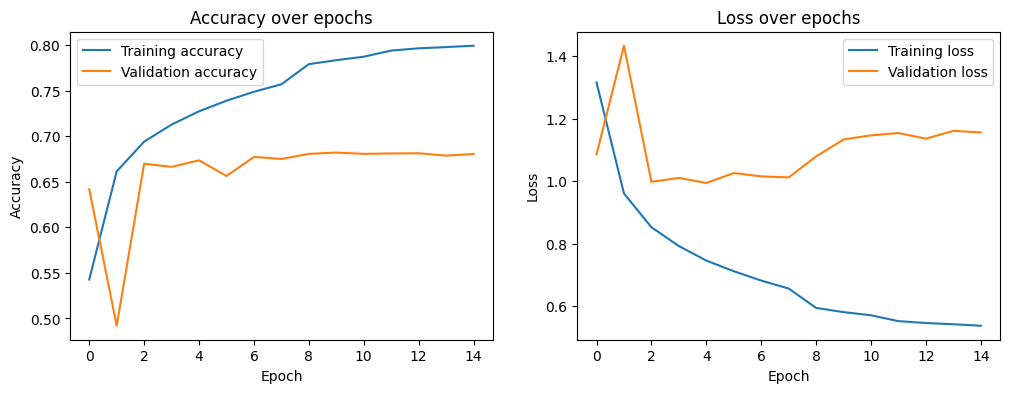

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

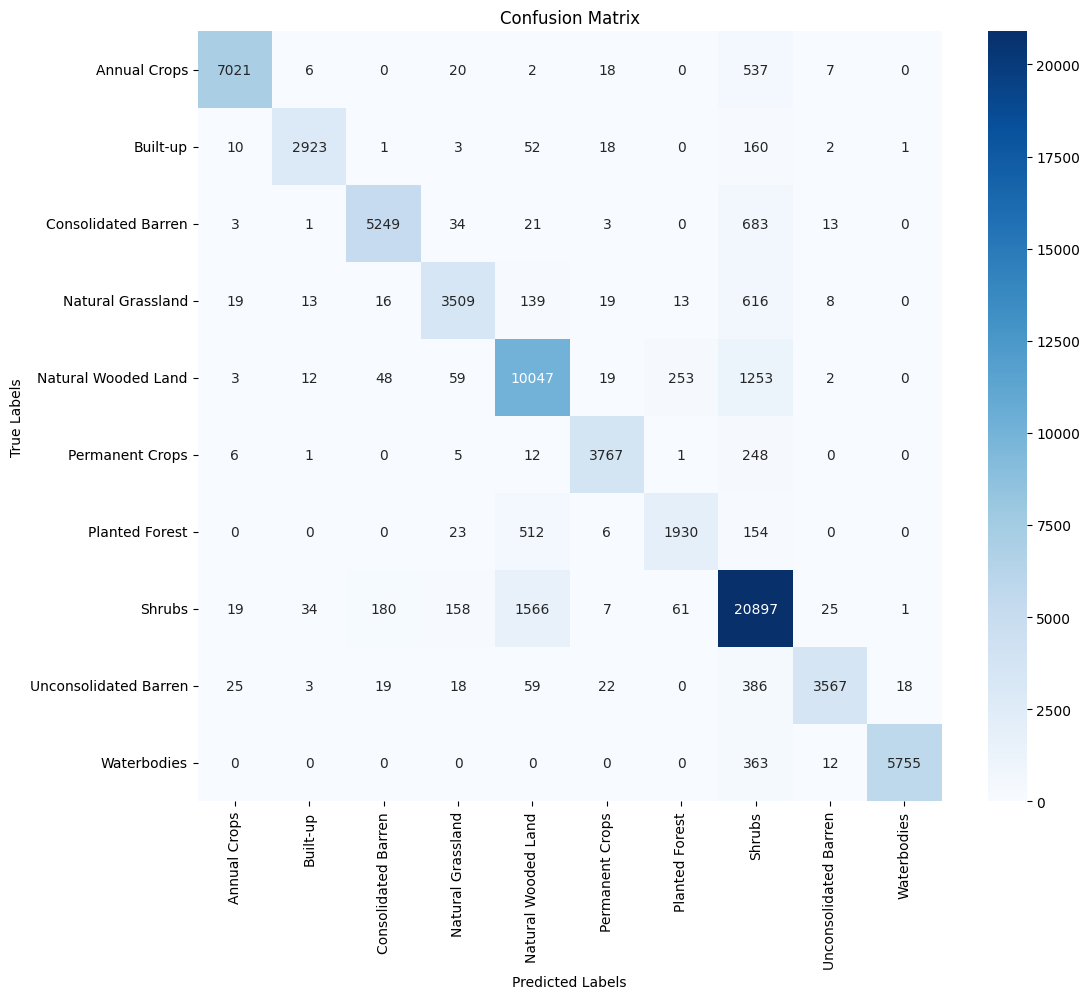

In [ ]:
# Use the `plot_confusion_matrix` function to visualize the model's classification performance.
# Plot the Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Load and visualize individual images
filtered_samples_df = samples_df[['Sample_num', 'Label', 'File']].drop_duplicates()
for index, row in filtered_samples_df.iterrows():
  image_path = os.path.join(images_path, row['File'])
  if os.path.exists(image_path):
    load_predict_and_visualize(image_path, row['Label'], model, label_encoder)
  else:
    print(f"File not found: {image_path}")

#### Verification


Class distribution after oversampling:
Label
Shrubs                   91830
Natural Wooded Land      47115
Unconsolidated Barren    36732
Planted Forest           36732
Annual Crops             36732
Natural Grassland        36732
Permanent Crops          36732
Consolidated Barren      36732
Waterbodies              24052
Built-up                 13314
Name: count, dtype: int64


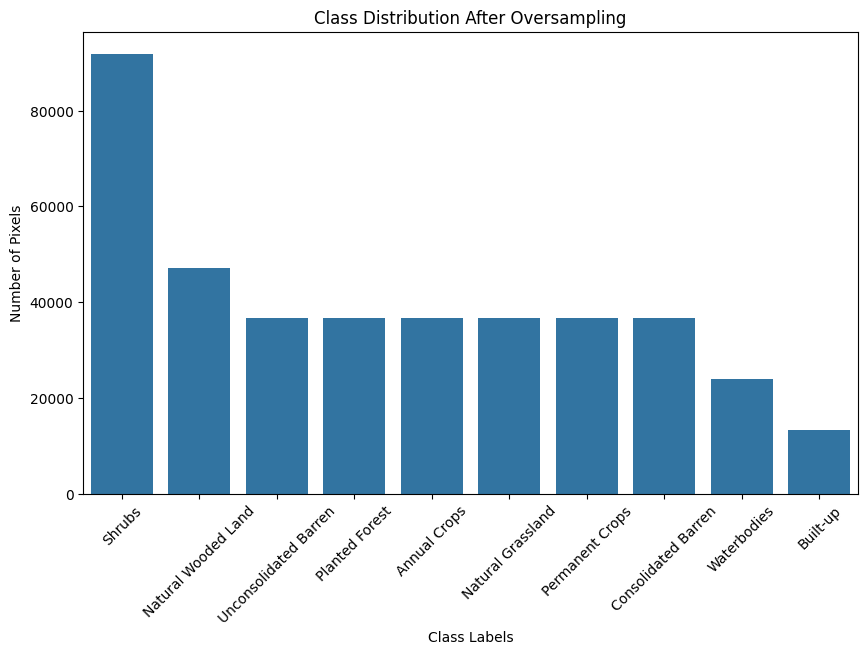

In [ ]:
# Verify the distribution of labels in the oversampled DataFrame
augmented_train_df_counts = augmented_train_df['Label'].value_counts()
print("\nClass distribution after oversampling:")
print(augmented_train_df_counts)

# Plot the distribution for visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=augmented_train_df_counts.index, y=augmented_train_df_counts.values)
plt.title("Class Distribution After Oversampling")
plt.xlabel("Class Labels")
plt.ylabel("Number of Pixels")
plt.xticks(rotation=45)
plt.show()


Class distribution before oversampling:
Label
Built-up                 13314
Planted Forest           12318
Shrubs                   91830
Waterbodies              24052
Natural Wooded Land      47115
Permanent Crops          17893
Annual Crops             31567
Consolidated Barren      26599
Natural Grassland        19110
Unconsolidated Barren    18163
Name: count, dtype: int64

Class distribution after oversampling:
Label
Built-up                 13314
Planted Forest           36732
Shrubs                   91830
Waterbodies              24052
Natural Wooded Land      47115
Permanent Crops          36732
Annual Crops             36732
Consolidated Barren      36732
Natural Grassland        36732
Unconsolidated Barren    36732
Name: count, dtype: int64


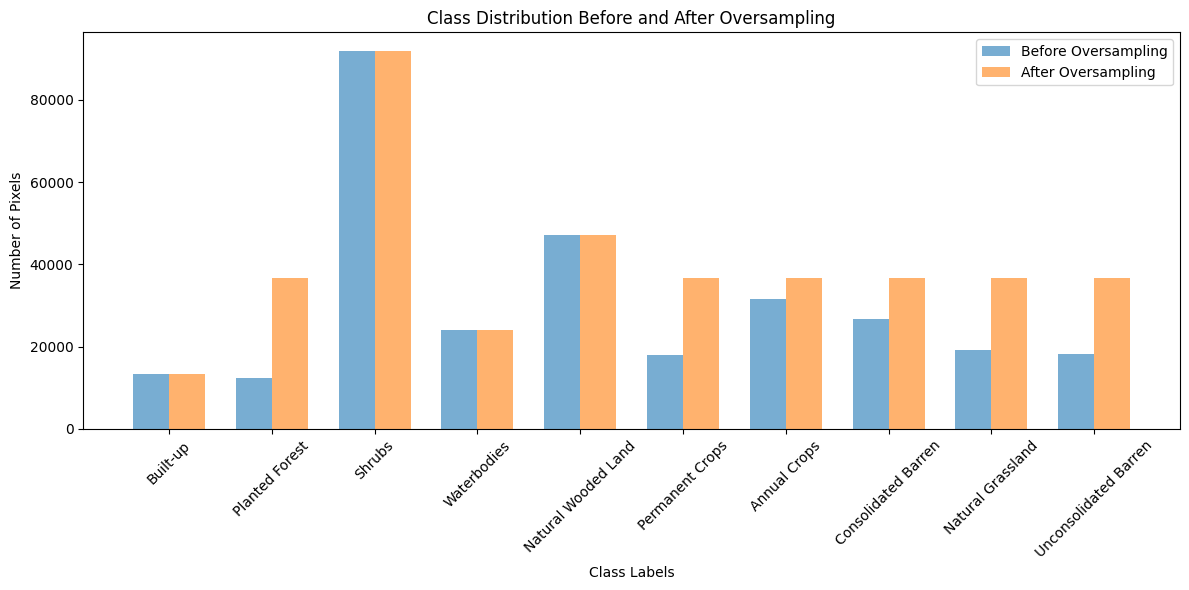


Difference in class distributions:
Label
Built-up                     0
Planted Forest           24414
Shrubs                       0
Waterbodies                  0
Natural Wooded Land          0
Permanent Crops          18839
Annual Crops              5165
Consolidated Barren      10133
Natural Grassland        17622
Unconsolidated Barren    18569
Name: count, dtype: int64


In [ ]:
# Display oversampling stats to verify
verify_oversampling(train_df, augmented_train_df)

In [ ]:
# Recompute target_size_per_class for verification
percentage = 40  # Ensure this matches the percentage used in oversample_to_target_size
largest_class_size = train_df['Label'].value_counts().max()
target_size_per_class = {
    class_label: max(
        len(train_df[train_df['Label'] == class_label]),
        int(largest_class_size * (percentage / 100))
    )
    for class_label in oversample_images.keys()
}
# For classes not being oversampled, set the target size to their original size
for class_label in train_df['Label'].unique():
    if class_label not in oversample_images:
        target_size_per_class[class_label] = len(train_df[train_df['Label'] == class_label])

# Check for duplicate rows in the oversampled data
num_duplicates = augmented_train_df.duplicated().sum()
print(f"\nNumber of duplicated samples in oversampled training data: {num_duplicates}")

# Ensure class labels are consistent before and after oversampling
original_classes = set(train_df['Label'].unique())
oversampled_classes = set(augmented_train_df['Label'].unique())

assert original_classes == oversampled_classes, "Mismatch in classes before and after oversampling."
print("Classes are consistent before and after oversampling.")

# Verify that classes not intended for oversampling have not changed in size
classes_not_oversampled = original_classes - set(oversample_images.keys())

for class_label in classes_not_oversampled:
    original_size = len(train_df[train_df['Label'] == class_label])
    oversampled_size = len(augmented_train_df[augmented_train_df['Label'] == class_label])
    assert original_size == oversampled_size, (
        f"Class '{class_label}' size changed unexpectedly from {original_size} to {oversampled_size}."
    )
    print(f"Class '{class_label}' size remains unchanged at {original_size} samples.")


Number of duplicated samples in oversampled training data: 0
Classes are consistent before and after oversampling.
Class 'Shrubs' size remains unchanged at 91830 samples.
Class 'Waterbodies' size remains unchanged at 24052 samples.
Class 'Natural Wooded Land' size remains unchanged at 47115 samples.
Class 'Built-up' size remains unchanged at 13314 samples.


## Training with Class Weights

---



### PreProcessing

In [ ]:
# Load Data
samples_df, labels_df = load_data(samples_path, labels_path)

########################  TEMPORARILY REMOVE WETLANDS  #########################
samples_df, labels_df = remove_wetlands(samples_df, labels_df)
########################  TEMPORARILY REMOVE WETLANDS  #########################

# Preprocess Data
samples_df, labels_df, label_encoder = preprocess_data(samples_df, labels_df)

# Ensure samples_df includes only the valid Sample_num values found in labels_df
valid_sample_nums = labels_df['Sample_num'].unique()
samples_df = samples_df[samples_df['Sample_num'].isin(valid_sample_nums)]

# Columns `frq0` to `frq372` are bands
frequency_cols = [col for col in samples_df.columns if 'frq' in col]

Successfully removed 'Wetlands' from the dataset.


In [ ]:
# Map Ground_Truth labels using the Sample_num (Used for testing)
pixel_counts_df, mismatches = map_ground_truth(samples_df, labels_df)

# Call the verification function after PreProcessing
test_results = verify_data_alignment(samples_df, labels_df, pixel_counts_df, mismatches, frequency_cols)


Verification Results:
Test 1: No mismatches between Label and Ground_Truth - PASSED :)
Test 2: All Sample_num values in labels_df are present in pixel_counts_df - PASSED :)
Test 3: No missing Sample_num values in samples_df - PASSED :)
Test 4: No entries filtered out due to all -9999 values - PASSED :)
Test 5: Unique Sample_num count matches between labels_df and filtered_samples_df - PASSED :)


In [ ]:
# Create a DataFrame with unique images and their labels
image_labels_df = samples_df[['Sample_num', 'Label_Encoded']].drop_duplicates()

# Stratified splitting at the image level
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(sss.split(image_labels_df['Sample_num'], image_labels_df['Label_Encoded']))

# Get the Sample_num for training and testing
train_sample_nums = image_labels_df['Sample_num'].iloc[train_indices]
test_sample_nums = image_labels_df['Sample_num'].iloc[test_indices]

# Create training and testing DataFrames
train_df = samples_df[samples_df['Sample_num'].isin(train_sample_nums)]
test_df = samples_df[samples_df['Sample_num'].isin(test_sample_nums)]

# Extract features and labels for training and testing sets
X_train = train_df[frequency_cols].values
y_train = train_df['Label_Encoded'].values
X_test = test_df[frequency_cols].values
y_test = test_df['Label_Encoded'].values

# Model parameters
input_shape = (X_train.shape[1], 1)
num_classes = len(label_encoder.classes_)

# Convert labels to One-Hot Encoding
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Add a channel dimension for Conv1D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Data Visualization

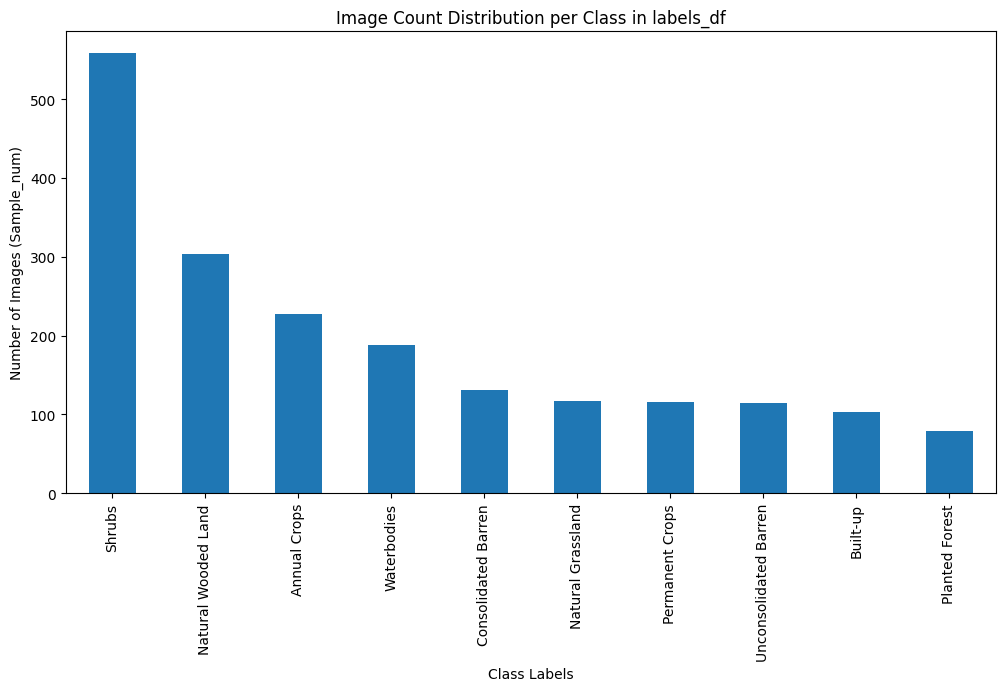

Class distribution in labels_df:
 Class
Shrubs                   558
Natural Wooded Land      304
Annual Crops             227
Waterbodies              188
Consolidated Barren      131
Natural Grassland        117
Permanent Crops          116
Unconsolidated Barren    114
Built-up                 103
Planted Forest            79
Name: count, dtype: int64


In [ ]:
# Get the Labels Class Dsitribution
plot_label_distribution(labels_df, label_column='Class')

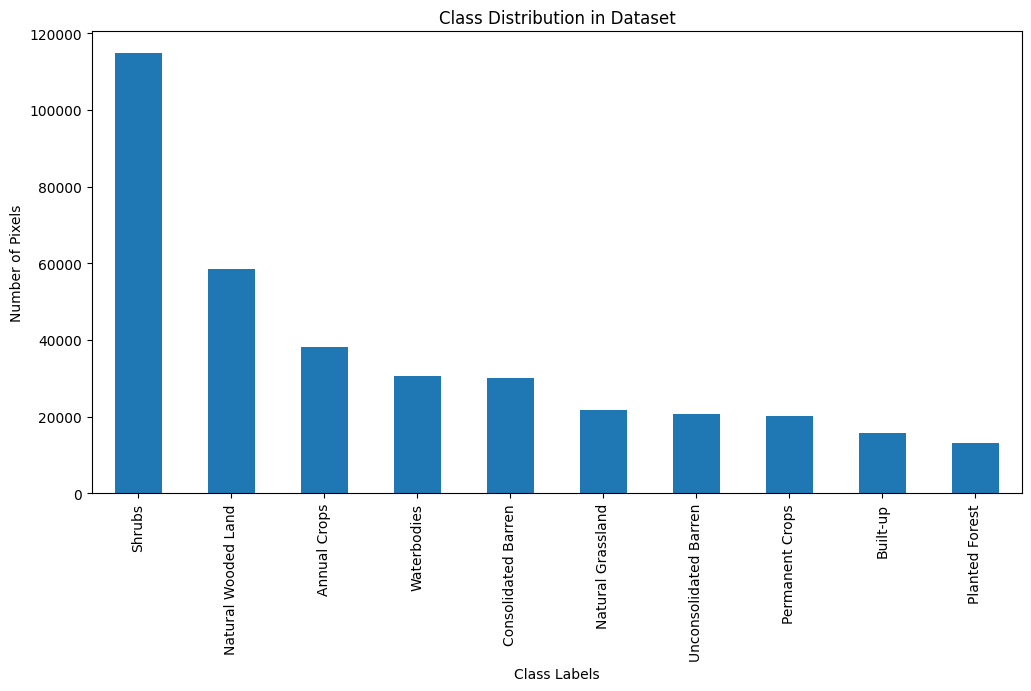

Class label counts:
 Label
Shrubs                   114740
Natural Wooded Land       58477
Annual Crops              38055
Waterbodies               30652
Consolidated Barren       30035
Natural Grassland         21760
Unconsolidated Barren     20587
Permanent Crops           20198
Built-up                  15849
Planted Forest            13124
Name: count, dtype: int64


In [ ]:
# Get the Pixels per Class Dsitribution
plot_class_distribution(samples_df, label_column='Label')

### Define CNN & Calculate Class Weights (**Loading from weights**)

In [ ]:
# Initialize CNN model
model = get_cnn_model(input_shape, num_classes, wd=1e-6, drop_rate=0.3, learning_rate=.0001)

# Load weights
model.load_weights(checkpoint_path)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)                   │ (None, 371, 512)            │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 371, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_28 (MaxPooling1D)      │ (None, 185, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_29 (Conv1D)                   │ (None, 183, 256)            │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_29 (MaxPooling1D)      │ (None, 91, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_30 (Conv1D)                   │ (None, 89, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 44, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_31 (Conv1D)                   │ (None, 42, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_31 (MaxPooling1D)      │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1344)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │         172,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701,706 (2.68 MB)

 Trainable params: 700,682 (2.67 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# Get predictions on the test set
y_test_labels, y_pred_labels, y_true_int, y_pred_int = get_predictions(model, X_test, y_test_cat, label_encoder)

# Proceed with predictions and adjusted class weights
class_weights = get_adjusted_class_weights(y_true_int, y_pred_int, label_encoder)

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Adjusted Class Weights:
Annual Crops           Weight: 0.770
Built-up               Weight: 0.709
Consolidated Barren    Weight: 1.018
Natural Grassland      Weight: 2.172
Natural Wooded Land    Weight: 0.860
Permanent Crops        Weight: 0.876
Planted Forest         Weight: 0.875
Shrubs                 Weight: 0.769
Unconsolidated Barren  Weight: 1.372
Waterbodies            Weight: 0.579


### Training CNN ( Using Class Weights)

In [ ]:
# Define callbacks
callbacks = define_callbacks(checkpoint_path_class_weights)

# Init new model
model = get_cnn_model(input_shape, num_classes, wd=1e-6, drop_rate=0.3, learning_rate=.0001)

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)                   │ (None, 371, 512)            │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 371, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_40 (MaxPooling1D)      │ (None, 185, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_41 (Conv1D)                   │ (None, 183, 256)            │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_41 (MaxPooling1D)      │ (None, 91, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_42 (Conv1D)                   │ (None, 89, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_42 (MaxPooling1D)      │ (None, 44, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_43 (Conv1D)                   │ (None, 42, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_43 (MaxPooling1D)      │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 1344)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │         172,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701,706 (2.68 MB)

 Trainable params: 700,682 (2.67 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# Training with Class Weights
history = train_model_with_class_weights(
  model,
  X_train,
  y_train_cat,
  X_test,
  y_test_cat,
  class_weights,
  epochs=30,
  batch_size=32
)

Epoch 1/30
9041/9041 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4684 - loss: 1.4902
Epoch 1: val_accuracy improved from -inf to 0.62389, saving model to /content/drive/My Drive/.School/Capstone/model_checkpoints_Benz_Testing/my_weights.weights.h5
9041/9041 ━━━━━━━━━━━━━━━━━━━━ 115s 12ms/step - accuracy: 0.4684 - loss: 1.4902 - val_accuracy: 0.6239 - val_loss: 1.1634 - learning_rate: 1.0000e-04
Epoch 2/30
9036/9041 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5948 - loss: 1.0943
Epoch 2: val_accuracy did not improve from 0.62389
9041/9041 ━━━━━━━━━━━━━━━━━━━━ 103s 11ms/step - accuracy: 0.5948 - loss: 1.0943 - val_accuracy: 0.6091 - val_loss: 1.1004 - learning_rate: 1.0000e-04
Epoch 3/30
9038/9041 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6398 - loss: 0.9475
Epoch 3: val_accuracy improved from 0.62389 to 0.64169, saving model to /content/drive/My Drive/.School/Capstone/model_checkpoints_Benz_Testing/my_weights.weights.h5
9041/9041 ━━━━━━━━━━━━━━━━━━━━ 104s 11ms/step - accur

### Test Model Performance

In [ ]:
# Evaluate the model
test_accuracy = evaluate_model(model, X_test, y_test_cat)
print("Final Test Accuracy:", test_accuracy)

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6666 - loss: 1.1736
Test Accuracy: 0.6476
Final Test Accuracy: 0.6476448774337769


### Post-Training Visualization

In [ ]:
# Get predictions on the test set
y_test_labels, y_pred_labels, _, _ = get_predictions(model, X_test, y_test_cat, label_encoder)

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [ ]:
# Get the Classification Report usung sklearn.metrics
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

                       precision    recall  f1-score   support

         Annual Crops       0.73      0.69      0.71      8240
             Built-up       0.80      0.81      0.81      3453
  Consolidated Barren       0.47      0.56      0.51      5664
    Natural Grassland       0.28      0.34      0.31      4720
  Natural Wooded Land       0.66      0.61      0.63     10891
      Permanent Crops       0.75      0.64      0.69      3816
       Planted Forest       0.73      0.49      0.59      2320
               Shrubs       0.65      0.69      0.67     24045
Unconsolidated Barren       0.43      0.37      0.40      3868
          Waterbodies       1.00      0.90      0.95      7161

             accuracy                           0.65     74178
            macro avg       0.65      0.61      0.63     74178
         weighted avg       0.66      0.65      0.65     74178



In [ ]:
# Use the `plot_confusion_matrix` function to visualize the model's classification performance.
# Plot the Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

#### This will print pixel predicitons and ground truth images for ALL IMAGES

In [ ]:
# Load and visualize individual images
filtered_samples_df = samples_df[['Sample_num', 'Label', 'File']].drop_duplicates()
for index, row in filtered_samples_df.iterrows():
  image_path = os.path.join(images_path, row['File'])
  if os.path.exists(image_path):
    load_predict_and_visualize(image_path, row['Label'], model, label_encoder)
  else:
    print(f"File not found: {image_path}")

## Training with Class Weights & Oversampling

---



### PreProcessing

In [ ]:
# Load Data
samples_df, labels_df = load_data(samples_path, labels_path)

########################  TEMPORARILY REMOVE WETLANDS  #########################
samples_df, labels_df = remove_wetlands(samples_df, labels_df)
########################  TEMPORARILY REMOVE WETLANDS  #########################

# Preprocess Data
samples_df, labels_df, label_encoder = preprocess_data(samples_df, labels_df)

# Ensure samples_df includes only the valid Sample_num values found in labels_df
valid_sample_nums = labels_df['Sample_num'].unique()
samples_df = samples_df[samples_df['Sample_num'].isin(valid_sample_nums)]

# Columns `frq0` to `frq372` are bands
frequency_cols = [col for col in samples_df.columns if 'frq' in col]

Successfully removed 'Wetlands' from the dataset.


In [ ]:
# Map Ground_Truth labels using the Sample_num (Used for testing)
pixel_counts_df, mismatches = map_ground_truth(samples_df, labels_df)

# Call the verification function after PreProcessing
test_results = verify_data_alignment(samples_df, labels_df, pixel_counts_df, mismatches, frequency_cols)


Verification Results:
Test 1: No mismatches between Label and Ground_Truth - PASSED :)
Test 2: All Sample_num values in labels_df are present in pixel_counts_df - PASSED :)
Test 3: No missing Sample_num values in samples_df - PASSED :)
Test 4: No entries filtered out due to all -9999 values - PASSED :)
Test 5: Unique Sample_num count matches between labels_df and filtered_samples_df - PASSED :)


In [ ]:
# Create a DataFrame with unique images and their labels
image_labels_df = samples_df[['Sample_num', 'Label_Encoded']].drop_duplicates()

# Stratified splitting at the image level
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(sss.split(image_labels_df['Sample_num'], image_labels_df['Label_Encoded']))

# Get the Sample_num for training and testing
train_sample_nums = image_labels_df['Sample_num'].iloc[train_indices]
test_sample_nums = image_labels_df['Sample_num'].iloc[test_indices]

# Create training and testing DataFrames
train_df = samples_df[samples_df['Sample_num'].isin(train_sample_nums)]
test_df = samples_df[samples_df['Sample_num'].isin(test_sample_nums)]

# Extract features and labels for training and testing sets
X_train = train_df[frequency_cols].values
y_train = train_df['Label_Encoded'].values
X_test = test_df[frequency_cols].values
y_test = test_df['Label_Encoded'].values

# Model parameters
input_shape = (X_train.shape[1], 1)
num_classes = len(label_encoder.classes_)

# Convert labels to One-Hot Encoding
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Add a channel dimension for Conv1D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Using Oversampling/Augmentation

#### Split Data into Train & Test

In [ ]:
# These are taken from above as well as verifying from actually looking them up
# NOTE: I am not oversampling Built-up or Waterbodies cause they are both really easy to identify shown by stats
oversample_images = {
    'Consolidated Barren': [2051, 21902, 2067, 9620, 2070, 10781, 7080, 10790, 20392, 7081, 7082, 7083, 7084, 7085, 9390, 7983, 9391, 22192, 7092, 7093, 7094, 9398, 7100, 7102, 7103, 20417, 7106, 8005, 21061, 2375, 22982, 24262, 4556, 8018, 8404, 8405, 22872, 4698, 9574, 9576, 9066, 8304, 8305, 8306, 7416, 8185, 8186, 8187, 5374, 4859],
    'Natural Grassland': [7424, 5634, 27138, 7947, 7692, 25228, 7701, 3991, 6009, 7708, 7711, 2848, 6052, 11812, 5414, 9510, 6952, 24997, 6827, 5936, 6192, 7984, 10801, 6973, 7742, 5063, 8520, 5065, 6602, 7881, 7118, 11087, 4822, 5594, 11103, 9442, 7011, 7652, 6757, 7013, 7656, 3435, 3437, 3565, 26095, 26353, 8825, 28026, 4731, 5629],
    'Unconsolidated Barren': [1, 2, 10883, 20610, 21639, 11, 20758, 26, 11682, 11683, 11684, 11685, 21671, 1065, 8235, 20013, 7342, 26416, 20026, 8507, 20034, 20676, 8141, 213, 20056, 10714, 10715, 10716, 10717, 10718, 10719, 10720, 10721, 10722, 10723, 10724, 10725, 10726, 10727, 20839, 27751, 20591, 11633, 11634, 11635, 7412, 20084, 20087, 22234, 20090],
    'Planted Forest': [7303, 5899, 5771, 8460, 5389, 5396, 5653, 5403, 5919, 8226, 8227, 2853, 5931, 5421, 7982, 5422, 6318, 5684, 5686, 5687, 5944, 5945, 6328, 6331, 6460, 5949, 5950, 6334, 5579, 5707, 5710, 5711, 6352, 5713, 5586, 5587, 5968, 5464, 5977, 5473, 5477, 5481, 5611, 5613, 5487, 5999, 6000, 6386, 6387, 6005],
    'Permanent Crops': [24067, 27268, 22533, 2829, 3983, 23444, 24084, 21782, 26263, 24856, 27163, 6044, 27547, 21022, 6046, 25249, 23715, 5028, 23849, 23724, 8495, 8496, 8497, 5042, 24115, 5043, 23608, 25789, 23623, 21964, 27597, 23252, 8406, 8407, 21209, 21983, 26336, 21985, 24930, 24041, 20971, 4855, 24178, 27251, 24950, 26871, 27643, 3708, 23166, 5887],
    'Annual Crops': [1538, 3331, 4, 3205, 2950, 7, 3078, 4739, 266, 4998, 1429, 8471, 3992, 7835, 2204, 5408, 2980, 4009, 3120, 1585, 3248, 1588, 2872, 5563, 3516, 1470, 8386, 4931, 1092, 1604, 2885, 10438, 1224, 5453, 8527, 1619, 3795, 3798, 1629, 3294, 2402, 1507, 3044, 2407, 4840, 1645, 3187, 4854, 3831, 3833],
}


In [ ]:
# Determine the size of the largest class in the training set
largest_class_size = train_df['Label'].value_counts().max()

# Define target sizes for each class in oversample_images
percentage = 20
target_size_per_class = {
    class_label: max(
        len(train_df[train_df['Label'] == class_label]),
        int(largest_class_size * (percentage / 100))
    )
    for class_label in oversample_images.keys()
}

In [ ]:
# Update oversample_images to include only Sample_nums in training set
oversample_images_in_training_set = {
    class_label: [
        sample_num for sample_num in sample_nums
        if sample_num in train_df['Sample_num'].unique()
    ]
    for class_label, sample_nums in oversample_images.items()
}
oversample_images = oversample_images_in_training_set

# Display updated oversample_images
for class_label, sample_nums in oversample_images.items():
    print(f"Class: {class_label}")
    print(f"Number of Sample_num: {len(sample_nums)}")
    print(f"Sample_num: {sample_nums}\n")

Class: Consolidated Barren
Number of Sample_num: 39
Sample_num: [2051, 2067, 9620, 10781, 10790, 20392, 7081, 7082, 7083, 7084, 7085, 9390, 7983, 9391, 22192, 7092, 7093, 7094, 9398, 7100, 7102, 7103, 20417, 8005, 21061, 22982, 8018, 8404, 8405, 22872, 4698, 9576, 9066, 8304, 8306, 8185, 8186, 5374, 4859]

Class: Natural Grassland
Number of Sample_num: 41
Sample_num: [5634, 27138, 7947, 7692, 25228, 7701, 3991, 7708, 7711, 2848, 6052, 11812, 5414, 9510, 6952, 6827, 5936, 6192, 10801, 6973, 7742, 5063, 8520, 5065, 6602, 7881, 7118, 11087, 4822, 11103, 9442, 7011, 7652, 6757, 7656, 3435, 3437, 3565, 8825, 28026, 4731]

Class: Unconsolidated Barren
Number of Sample_num: 41
Sample_num: [1, 2, 10883, 20610, 11, 20758, 26, 11682, 11683, 11684, 11685, 21671, 1065, 20013, 7342, 26416, 20026, 8507, 20034, 8141, 213, 20056, 10714, 10715, 10716, 10717, 10719, 10721, 10722, 10723, 10724, 10725, 10726, 20591, 11633, 11634, 11635, 20084, 20087, 22234, 20090]

Class: Planted Forest
Number of Sample_n

In [ ]:
# Apply augmentation
augmented_train_df = augment_data(
    train_df,
    oversample_images_in_training_set,
    target_size_per_class,
    frequency_cols
)

# Shuffle the augmented data
augmented_train_df = augmented_train_df.sample(frac=1, random_state=42).reset_index(drop=True)


Augmenting class 'Consolidated Barren':
Current total size: 24371, Target size: 24371, Samples needed: 0

Augmenting class 'Natural Grassland':
Current total size: 17040, Target size: 18139, Samples needed: 1099

Augmenting class 'Unconsolidated Barren':
Current total size: 16719, Target size: 18139, Samples needed: 1420

Augmenting class 'Planted Forest':
Current total size: 10804, Target size: 18139, Samples needed: 7335

Augmenting class 'Permanent Crops':
Current total size: 16382, Target size: 18139, Samples needed: 1757

Augmenting class 'Annual Crops':
Current total size: 29815, Target size: 29815, Samples needed: 0


#### Verify


Class distribution after oversampling:
Label
Shrubs                   90695
Natural Wooded Land      47586
Annual Crops             29815
Consolidated Barren      24371
Waterbodies              23491
Planted Forest           18139
Permanent Crops          18139
Unconsolidated Barren    18139
Natural Grassland        18139
Built-up                 12396
Name: count, dtype: int64


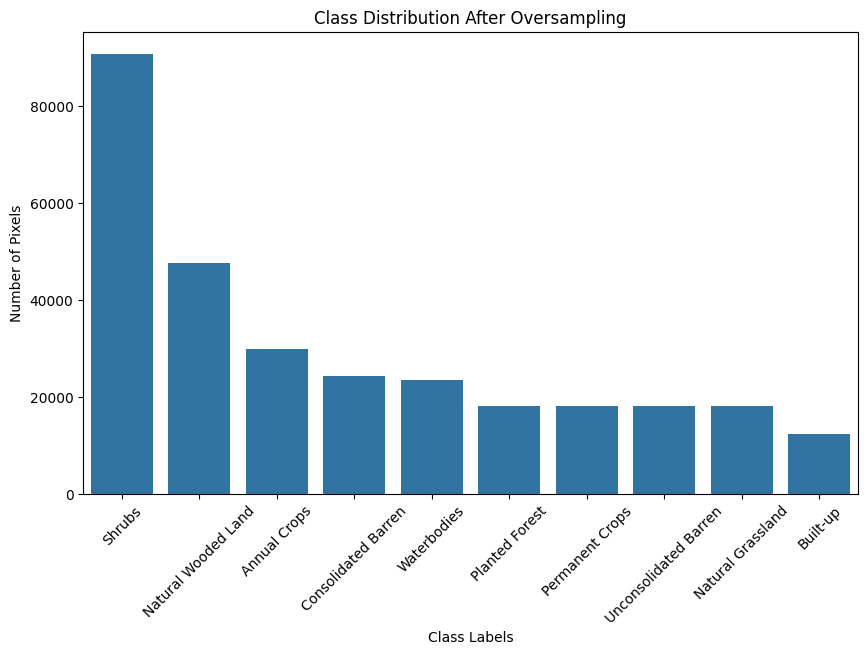

In [ ]:
# Verify the distribution of labels in the oversampled DataFrame
augmented_train_df_counts = augmented_train_df['Label'].value_counts()
print("\nClass distribution after oversampling:")
print(augmented_train_df_counts)

# Plot the distribution for visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=augmented_train_df_counts.index, y=augmented_train_df_counts.values)
plt.title("Class Distribution After Oversampling")
plt.xlabel("Class Labels")
plt.ylabel("Number of Pixels")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Ensure class labels are consistent before and after oversampling
original_classes = set(train_df['Label'].unique())
oversampled_classes = set(augmented_train_df['Label'].unique())

assert original_classes == oversampled_classes, "Mismatch in classes before and after oversampling."
print("Classes are consistent before and after oversampling.")

# Verify that classes not intended for oversampling remain unchanged
classes_not_oversampled = original_classes - set(oversample_images.keys())

for class_label in classes_not_oversampled:
    original_size = len(train_df[train_df['Label'] == class_label])
    oversampled_size = len(augmented_train_df[augmented_train_df['Label'] == class_label])
    assert original_size == oversampled_size, (
        f"Class '{class_label}' size changed unexpectedly from {original_size} to {oversampled_size}."
    )
    print(f"Class '{class_label}' size remains unchanged at {original_size} samples.")

Classes are consistent before and after oversampling.
Class 'Natural Wooded Land' size remains unchanged at 47586 samples.
Class 'Waterbodies' size remains unchanged at 23491 samples.
Class 'Built-up' size remains unchanged at 12396 samples.
Class 'Shrubs' size remains unchanged at 90695 samples.


#### Data Display


Class label counts in training data (number of pixels):
 Label
Shrubs                   90695
Natural Wooded Land      47586
Annual Crops             29815
Consolidated Barren      24371
Waterbodies              23491
Natural Grassland        17040
Unconsolidated Barren    16719
Permanent Crops          16382
Built-up                 12396
Planted Forest           10804
Name: count, dtype: int64

Class label counts in testing data (number of pixels):
 Label
Shrubs                   24045
Natural Wooded Land      10891
Annual Crops              8240
Waterbodies               7161
Consolidated Barren       5664
Natural Grassland         4720
Unconsolidated Barren     3868
Permanent Crops           3816
Built-up                  3453
Planted Forest            2320
Name: count, dtype: int64


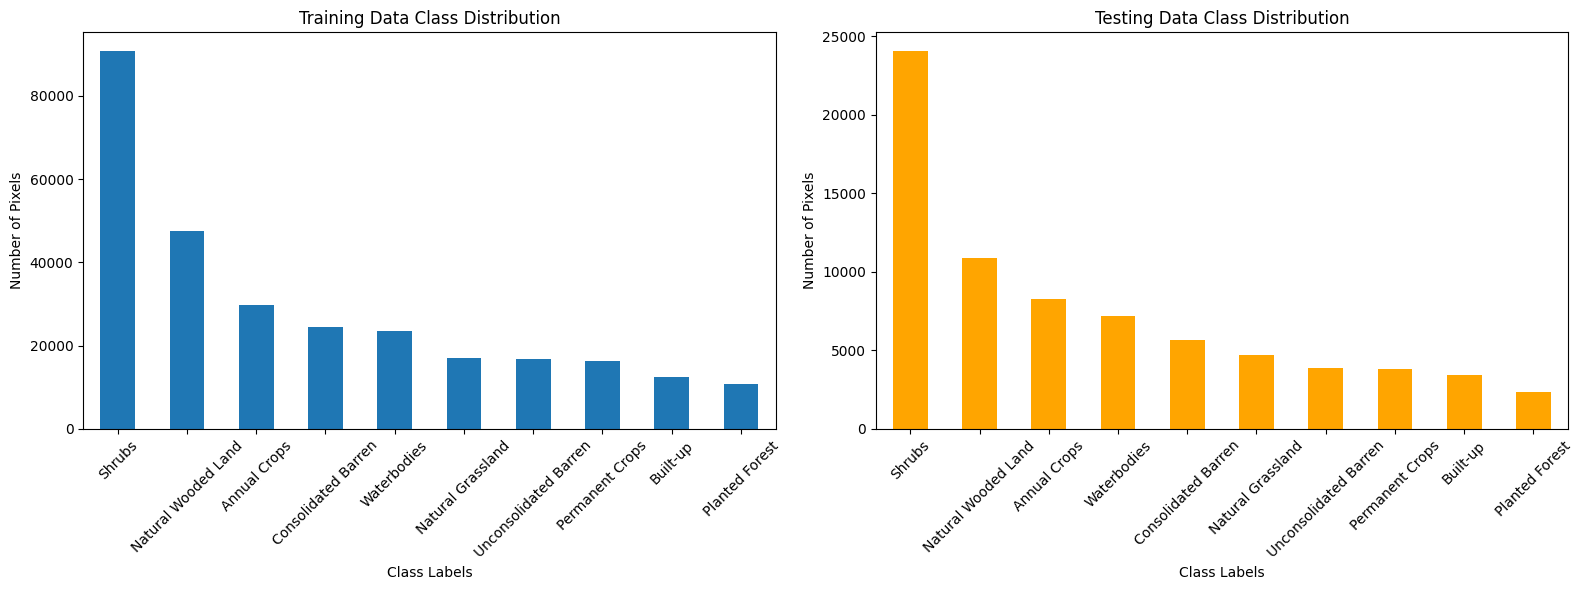

In [ ]:
# Calculate class counts in training data
train_class_counts = train_df['Label'].value_counts()
print("\nClass label counts in training data (number of pixels):\n", train_class_counts)

# Calculate class counts in testing data
test_class_counts = test_df['Label'].value_counts()
print("\nClass label counts in testing data (number of pixels):\n", test_class_counts)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot training data class distribution
train_class_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title("Training Data Class Distribution")
axes[0].set_xlabel("Class Labels")
axes[0].set_ylabel("Number of Pixels")
axes[0].tick_params(axis='x', rotation=45)

# Plot testing data class distribution
test_class_counts.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title("Testing Data Class Distribution")
axes[1].set_xlabel("Class Labels")
axes[1].set_ylabel("Number of Pixels")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Define CNN & Calculate Class Weights (**Loading from weights**)

In [ ]:
# Initialize CNN model
model = get_cnn_model(input_shape, num_classes, wd=1e-6, drop_rate=0.3, learning_rate=.0001)

# Load weights
model.load_weights(checkpoint_path)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_64 (Conv1D)                   │ (None, 371, 512)            │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 371, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_64 (MaxPooling1D)      │ (None, 185, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_65 (Conv1D)                   │ (None, 183, 256)            │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_65 (MaxPooling1D)      │ (None, 91, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_66 (Conv1D)                   │ (None, 89, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_66 (MaxPooling1D)      │ (None, 44, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_67 (Conv1D)                   │ (None, 42, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_67 (MaxPooling1D)      │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 1344)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 128)                 │         172,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701,706 (2.68 MB)

 Trainable params: 700,682 (2.67 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# Get predictions on the test set
y_test_labels, y_pred_labels, y_true_int, y_pred_int = get_predictions(model, X_test, y_test_cat, label_encoder)

# Proceed with predictions and adjusted class weights
class_weights = get_adjusted_class_weights(y_true_int, y_pred_int, label_encoder)

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Adjusted Class Weights:
Annual Crops           Weight: 0.818
Built-up               Weight: 0.707
Consolidated Barren    Weight: 1.108
Natural Grassland      Weight: 1.778
Natural Wooded Land    Weight: 0.932
Permanent Crops        Weight: 0.828
Planted Forest         Weight: 0.989
Shrubs                 Weight: 0.842
Unconsolidated Barren  Weight: 1.396
Waterbodies            Weight: 0.604


### Training CNN ( Using Class Weights)

In [ ]:
# Extract augmented training data
X_train_augmented = augmented_train_df[frequency_cols].values
y_train_augmented = augmented_train_df['Label_Encoded'].values

# Convert labels to One-Hot Encoding
y_train_augmented_cat = to_categorical(y_train_augmented, num_classes)

# Add a channel dimension for Conv1D
X_train_augmented = X_train_augmented.reshape((X_train_augmented.shape[0], X_train_augmented.shape[1], 1))

In [ ]:
# Define callbacks
callbacks = define_callbacks(checkpoint_path_class_weights)

# Init new model
model = get_cnn_model(input_shape, num_classes, wd=1e-6, drop_rate=0.3, learning_rate=.0001)

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_68 (Conv1D)                   │ (None, 371, 512)            │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 371, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_68 (MaxPooling1D)      │ (None, 185, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_69 (Conv1D)                   │ (None, 183, 256)            │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_69 (MaxPooling1D)      │ (None, 91, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_70 (Conv1D)                   │ (None, 89, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_70 (MaxPooling1D)      │ (None, 44, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_71 (Conv1D)                   │ (None, 42, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_71 (MaxPooling1D)      │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 1344)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 128)                 │         172,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701,706 (2.68 MB)

 Trainable params: 700,682 (2.67 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# Training with Class Weights
history = train_model_with_class_weights(
  model,
  X_train_augmented,
  y_train_augmented_cat,
  X_test,
  y_test_cat,
  class_weights,
  epochs=30,
  batch_size=32
)

Epoch 1/30
9404/9404 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4554 - loss: 1.5411
Epoch 1: val_accuracy improved from -inf to 0.60484, saving model to /content/drive/My Drive/.School/Capstone/model_checkpoints_Benz_Testing/my_weights.weights.h5
9404/9404 ━━━━━━━━━━━━━━━━━━━━ 117s 12ms/step - accuracy: 0.4554 - loss: 1.5411 - val_accuracy: 0.6048 - val_loss: 1.2029 - learning_rate: 1.0000e-04
Epoch 2/30
9401/9404 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6057 - loss: 1.1029
Epoch 2: val_accuracy improved from 0.60484 to 0.65909, saving model to /content/drive/My Drive/.School/Capstone/model_checkpoints_Benz_Testing/my_weights.weights.h5
9404/9404 ━━━━━━━━━━━━━━━━━━━━ 108s 12ms/step - accuracy: 0.6057 - loss: 1.1028 - val_accuracy: 0.6591 - val_loss: 1.0383 - learning_rate: 1.0000e-04
Epoch 3/30
9401/9404 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6579 - loss: 0.9511
Epoch 3: val_accuracy did not improve from 0.65909
9404/9404 ━━━━━━━━━━━━━━━━━━━━ 108s 11ms/step - accur

### Test Model Performance

In [ ]:
# Evaluate the model
test_accuracy = evaluate_model(model, X_test, y_test_cat)
print("Final Test Accuracy:", test_accuracy)

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6811 - loss: 1.0503
Test Accuracy: 0.6590
Final Test Accuracy: 0.6590498685836792


### Post-Training Visualization

In [ ]:
# Get predictions on the test set
y_test_labels, y_pred_labels, _, _ = get_predictions(model, X_test, y_test_cat, label_encoder)

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [ ]:
# Get the Classification Report usung sklearn.metrics
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

                       precision    recall  f1-score   support

         Annual Crops       0.71      0.66      0.68      8240
             Built-up       0.76      0.81      0.78      3453
  Consolidated Barren       0.51      0.61      0.55      5664
    Natural Grassland       0.33      0.35      0.34      4720
  Natural Wooded Land       0.67      0.62      0.64     10891
      Permanent Crops       0.77      0.56      0.65      3816
       Planted Forest       0.65      0.52      0.58      2320
               Shrubs       0.66      0.73      0.69     24045
Unconsolidated Barren       0.46      0.35      0.40      3868
          Waterbodies       1.00      0.90      0.94      7161

             accuracy                           0.66     74178
            macro avg       0.65      0.61      0.63     74178
         weighted avg       0.67      0.66      0.66     74178



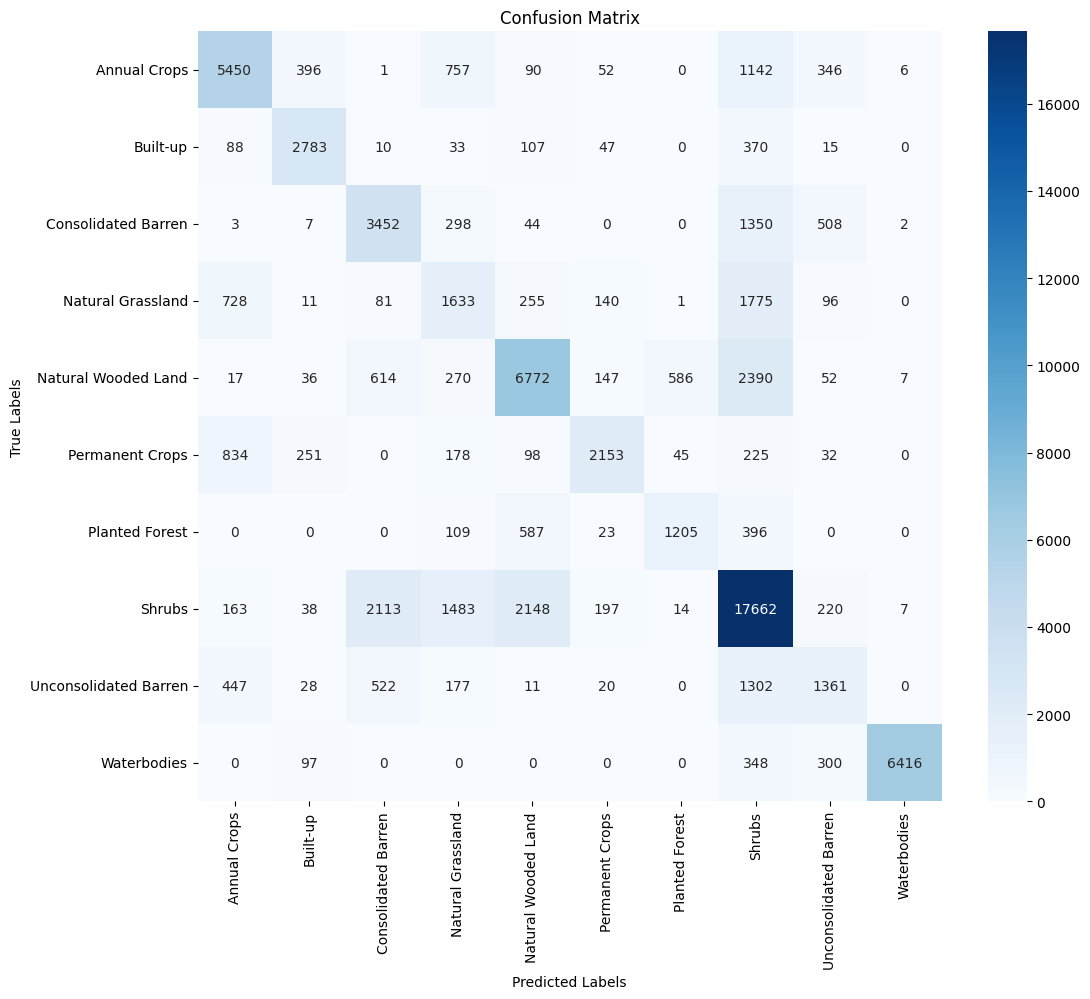

In [ ]:
# Use the `plot_confusion_matrix` function to visualize the model's classification performance.
# Plot the Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

#### This will print pixel predicitons and ground truth images for ALL IMAGES

In [ ]:
# Load and visualize individual images
filtered_samples_df = samples_df[['Sample_num', 'Label', 'File']].drop_duplicates()
for index, row in filtered_samples_df.iterrows():
  image_path = os.path.join(images_path, row['File'])
  if os.path.exists(image_path):
    load_predict_and_visualize(image_path, row['Label'], model, label_encoder)
  else:
    print(f"File not found: {image_path}")

# PCA

### Load, Split, Select, and Scale Data

In [ ]:
# Load Data
samples_df, labels_df = load_data(samples_path, labels_path)

# Preprocess Data
samples_df, labels_df, frequency_cols, label_encoder = preprocess_data(samples_df, labels_df)

# Map Ground Truth
pixel_counts_df, mismatches = map_ground_truth(samples_df, labels_df)

# Verify data alignment
verify_data_alignment(samples_df, labels_df, pixel_counts_df, mismatches, frequency_cols)

# Prepare features and labels
X = samples_df[frequency_cols].values
y = samples_df['Label_Encoded'].values

# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# Remove 0 variance features
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.0)
X_train_var = selector.fit_transform(X_train)
X_test_var = selector.transform(X_test)

# Check for 0 variance features
variances = np.var(X_train, axis=0)
zero_variance_features = np.where(variances == 0)[0]
print(f"Zero variance features at indices: {zero_variance_features}")

# Handle outliers by sacling using RobustScaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_var)
X_test_scaled = scaler.transform(X_test_var)

# Check variance after scaling
print("Variance after scaling:", np.var(X_train_scaled, axis=0))

### Apply PCA and Plot Variance

In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

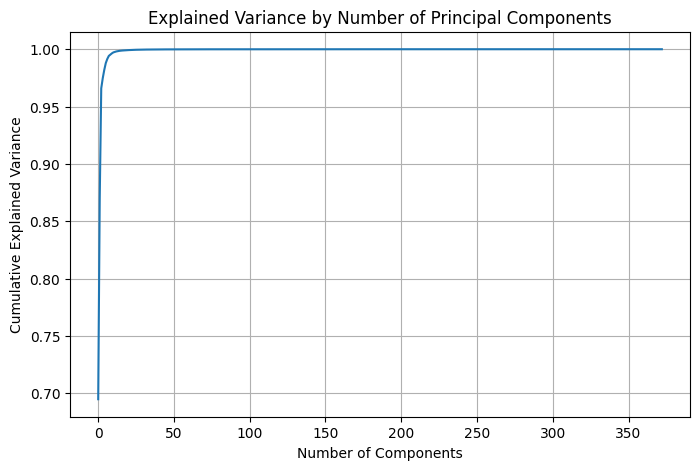

In [ ]:
# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid()
plt.show()

### Determine Num of components to keep 95% variance

In [ ]:
pca_95 = PCA(n_components=0.95)
X_train_pca_95 = pca_95.fit_transform(X_train_scaled)
X_test_pca_95 = pca_95.transform(X_test_scaled)

print(f"Number of components to retain 95% variance: {pca_95.n_components_}")

print("Shape of PCA-reduced training data:", X_train_pca_95.shape)
print("Shape of PCA-reduced test data:", X_test_pca_95.shape)

# 1st 10 explained variance ratios
print("First 10 explained variance ratios:", pca.explained_variance_ratio_[:10])

Number of components to retain 95% variance: 3
Shape of PCA-reduced training data: (208484, 3)
Shape of PCA-reduced test data: (52121, 3)
First 10 explained variance ratios: [0.69469395 0.17464837 0.09652844 0.00888177 0.00720885 0.00595757
 0.00360364 0.00265051 0.00113095 0.00106261]
Rank of the data matrix: 373


### Check for High Correlation

In [ ]:
# Compute the avg. correlation between features
corr_matrix = np.corrcoef(X_train_scaled, rowvar=False)
mean_corr = (np.sum(np.abs(corr_matrix)) - X_train_scaled.shape[1]) / (X_train_scaled.shape[1] * (X_train_scaled.shape[1] - 1))
print(f"Mean absolute correlation between features: {mean_corr}")

Mean absolute correlation between features: 0.7459505751112102


### Define pipelines for KNN and LR

In [ ]:
# Define pipelines for models
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', RobustScaler()),
        ('pca', PCA(n_components=3)),        # Just using 3 components
        ('clf', LogisticRegression(random_state=42, max_iter=10000))
    ]),
    'KNN': Pipeline([
        ('scaler', RobustScaler()),
        ('pca', PCA(n_components=3)),
        ('clf', KNeighborsClassifier(n_neighbors=100))
    ])
}

### Evaluate each pipeline

Logistic Regression Accuracy: 0.60


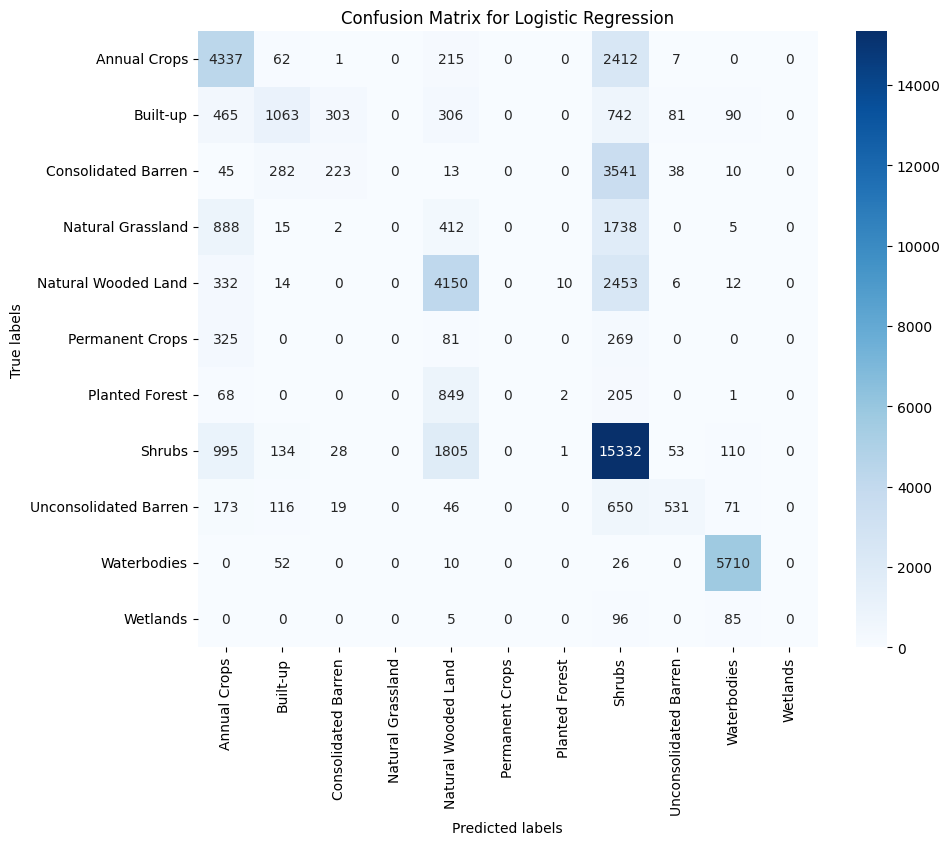

KNN Accuracy: 0.67


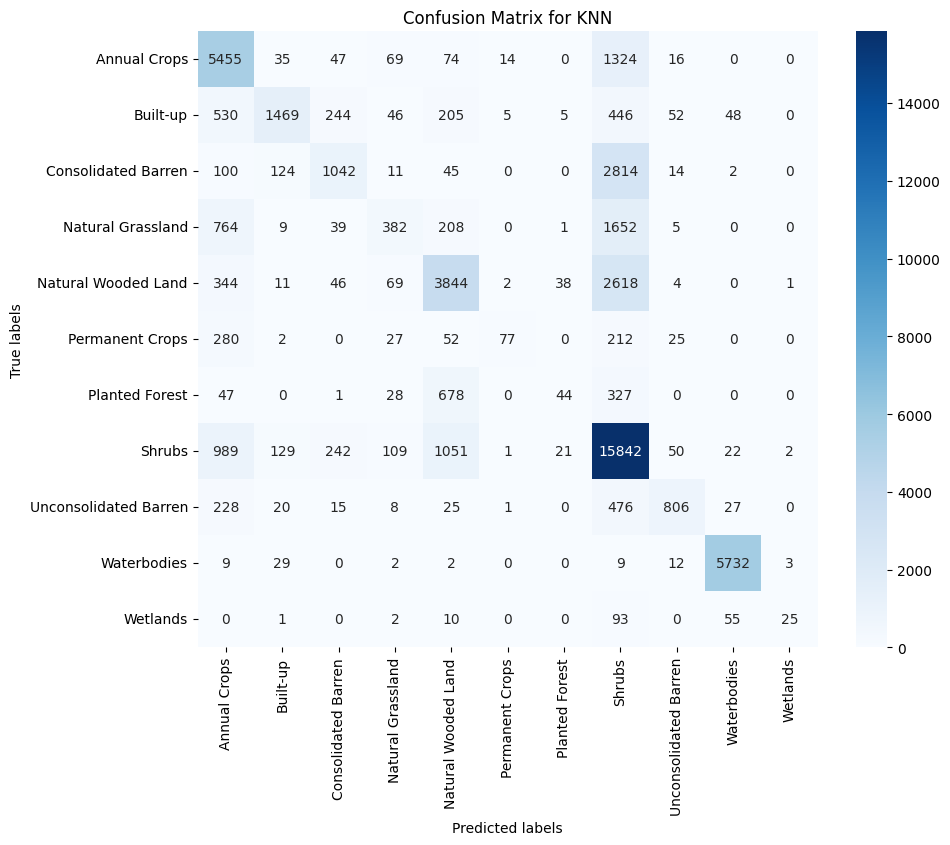

Classification Report:
                       precision    recall  f1-score   support

         Annual Crops       0.62      0.78      0.69      7034
             Built-up       0.80      0.48      0.60      3050
  Consolidated Barren       0.62      0.25      0.36      4152
    Natural Grassland       0.51      0.12      0.20      3060
  Natural Wooded Land       0.62      0.55      0.58      6977
      Permanent Crops       0.77      0.11      0.20       675
       Planted Forest       0.40      0.04      0.07      1125
               Shrubs       0.61      0.86      0.72     18458
Unconsolidated Barren       0.82      0.50      0.62      1606
          Waterbodies       0.97      0.99      0.98      5798
             Wetlands       0.81      0.13      0.23       186

             accuracy                           0.67     52121
            macro avg       0.69      0.44      0.48     52121
         weighted avg       0.67      0.67      0.63     52121



In [ ]:
results = {}
for name, pipeline in pipelines.items():
    # Train
    pipeline.fit(X_train_var, y_train)

    # Predict on test data
    y_pred = pipeline.predict(X_test_var)

    # Get accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.2f}")

    # CM
    confusion = metrics.confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Classification report for model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Grid Search

### PreProcessing

In [ ]:
# Load Data
samples_df, labels_df = load_data(samples_path, labels_path)

########################  TEMPORARILY REMOVE WETLANDS  #########################
samples_df, labels_df = remove_wetlands(samples_df, labels_df)
########################  TEMPORARILY REMOVE WETLANDS  #########################

# Preprocess Data
samples_df, labels_df, label_encoder = preprocess_data(samples_df, labels_df)

# Ensure samples_df includes only the valid Sample_num values found in labels_df
valid_sample_nums = labels_df['Sample_num'].unique()
samples_df = samples_df[samples_df['Sample_num'].isin(valid_sample_nums)]

# Columns `frq0` to `frq372` are bands
frequency_cols = [col for col in samples_df.columns if 'frq' in col]

Successfully removed 'Wetlands' from the dataset.


In [ ]:
# Map Ground_Truth labels using the Sample_num (Used for testing)
pixel_counts_df, mismatches = map_ground_truth(samples_df, labels_df)

# Call the verification function after PreProcessing
test_results = verify_data_alignment(samples_df, labels_df, pixel_counts_df, mismatches, frequency_cols)


Verification Results:
Test 1: No mismatches between Label and Ground_Truth - PASSED :)
Test 2: All Sample_num values in labels_df are present in pixel_counts_df - PASSED :)
Test 3: No missing Sample_num values in samples_df - PASSED :)
Test 4: No entries filtered out due to all -9999 values - PASSED :)
Test 5: Unique Sample_num count matches between labels_df and filtered_samples_df - PASSED :)


#### Split Data

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Create a DataFrame with unique images and their labels
image_labels_df = samples_df[['Sample_num', 'Label_Encoded']].drop_duplicates()

# Stratified splitting at the image level for train/test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(sss.split(image_labels_df['Sample_num'], image_labels_df['Label_Encoded']))

# Get the Sample_num for training and testing
train_sample_nums = image_labels_df['Sample_num'].iloc[train_indices]
test_sample_nums = image_labels_df['Sample_num'].iloc[test_indices]

# Create training and testing DataFrames
train_df = samples_df[samples_df['Sample_num'].isin(train_sample_nums)]
test_df = samples_df[samples_df['Sample_num'].isin(test_sample_nums)]

# Extract features and labels for training and testing sets
X_train_raw = train_df[frequency_cols].values  # Keep raw 2D features for models like KNN
y_train = train_df['Label_Encoded'].values
X_test_raw = test_df[frequency_cols].values
y_test = test_df['Label_Encoded'].values

# Model parameters
input_shape = (X_train_raw.shape[1], 1)
num_classes = len(label_encoder.classes_)

# Convert labels to One-Hot Encoding (For Neural Networks)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Add a channel dimension for Conv1D (For Neural Networks)
X_train_conv1d = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1], 1))
X_test_conv1d = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1], 1))

# Generate stratified subsets for varying training sizes
train_indices = {}
for size_label, size in zip(['xs', 's', 'm'], [50, 500, 5000]):
    sss_subset = StratifiedShuffleSplit(n_splits=1, train_size=min(size, len(y_train)), random_state=42)
    subset_indices, _ = next(sss_subset.split(X_train_raw, y_train))
    train_indices[size_label] = subset_indices

# Full dataset for 'all'
train_indices['all'] = np.arange(len(y_train))

# Debugging: Check class distribution in subsets
for size_label in ['xs', 's', 'm']:
    subset_labels = y_train[train_indices[size_label]]
    print(f"Class distribution in '{size_label}' subset: {np.bincount(subset_labels)}")


Class distribution in 'xs' subset: [ 5  2  4  3  8  3  2 16  3  4]
Class distribution in 's' subset: [ 52  21  42  29  82  28  19 157  29  41]
Class distribution in 'm' subset: [ 515  214  421  295  822  283  187 1568  289  406]


In [ ]:
num_samples = X_train_raw.shape[0]

train_indices = dict()
train_indices['xs'] = np.arange(min(50, num_samples))
train_indices['s'] = np.arange(min(500, num_samples))
train_indices['m'] = np.arange(min(5000, num_samples))
train_indices['all'] = np.arange(num_samples)

# print("Extra Small Sample Size: ", train_indices['xs'])
# print("Small Sample Size: ", train_indices['s'])
# print("Medium Sample Size: ", train_indices['m'])
# print("All Samples Size: ", train_indices['all'])

### Implement and test KNN, SVM, and Linear Logistic Regression (LLR)

#### Using varying sample sizes

In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Initialize lists to store accuracies
knn_acc = []
llr_acc = []
svm_acc = []

# Loop over different training sizes
for size_label in ['xs', 's', 'm']:
    indices = train_indices[size_label]
    X_train_subset = X_train_raw[indices]
    y_train_subset = y_train[indices]

    # Scale data for Logistic Regression and SVM
    X_train_scaled = scaler.fit_transform(X_train_subset)
    X_test_scaled = scaler.transform(X_test_raw)

    print(f"\nTraining with '{size_label}' size ({len(indices)} samples):")

    # KNN (no scaling required)
    accuracy, _ = classify_and_report_KNN(X_train_subset, y_train_subset, X_test_raw, y_test, K=3)
    knn_acc.append(accuracy)

    # LLR (using scaled data)
    accuracy = classify_and_report_LLR(X_train_scaled, y_train_subset, X_test_scaled, y_test, C=1.0)
    llr_acc.append(accuracy)

    # SVM (using scaled data)
    accuracy = classify_and_report_SVM(X_train_scaled, y_train_subset, X_test_scaled, y_test, kernel='rbf', gamma='scale', C=1.0)
    svm_acc.append(accuracy)


Training with 'xs' size (50 samples):
KNN Results
Accuracy: 0.40190
Training Time: 0.00085 seconds
Inference Time: 0.03216 milliseconds

LLR Results
Accuracy: 0.32415
Training Time: 0.05884 seconds
Inference Time: 0.00055 milliseconds

SMV Results
Accuracy: 0.32415
Training Time: 0.00332 seconds
Inference Time: 0.00953 milliseconds


Training with 's' size (500 samples):
KNN Results
Accuracy: 0.44941
Training Time: 0.00138 seconds
Inference Time: 0.03431 milliseconds

LLR Results
Accuracy: 0.32415
Training Time: 0.09469 seconds
Inference Time: 0.00049 milliseconds

SMV Results
Accuracy: 0.32415
Training Time: 0.04375 seconds
Inference Time: 0.08402 milliseconds


Training with 'm' size (5000 samples):
KNN Results
Accuracy: 0.48490
Training Time: 0.00210 seconds
Inference Time: 0.06282 milliseconds

LLR Results
Accuracy: 0.32415
Training Time: 0.40909 seconds
Inference Time: 0.00063 milliseconds

SMV Results
Accuracy: 0.32415
Training Time: 3.02913 seconds
Inference Time: 1.17419 milli

#### Plot results for varying sample sizes

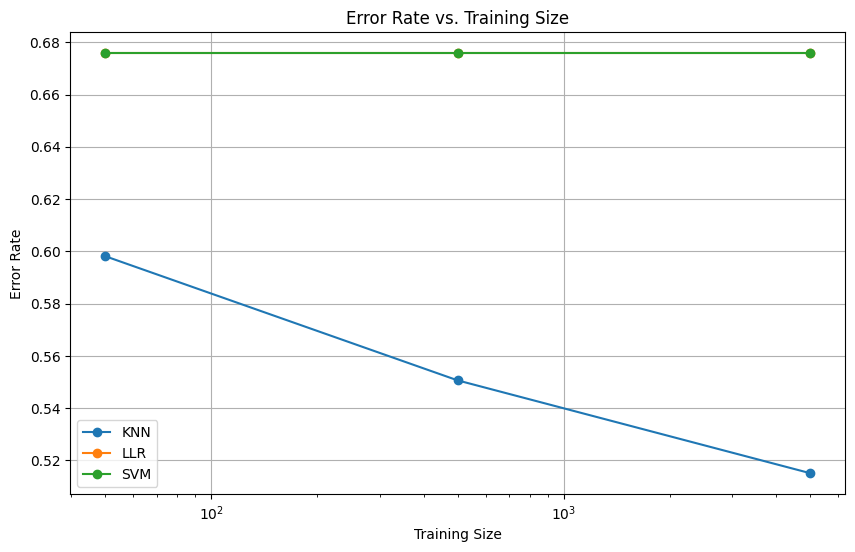

In [ ]:
# Convert accuracy to error
error_knn = [1 - acc for acc in knn_acc]
error_llr = [1 - acc for acc in llr_acc]
error_svm = [1 - acc for acc in svm_acc]

# Plotting
training_size_values = [len(train_indices[key]) for key in ['xs', 's', 'm']]
plt.figure(figsize=(10, 6))
plt.plot(training_size_values, error_knn, label='KNN', marker='o')
plt.plot(training_size_values, error_llr, label='LLR', marker='o')
plt.plot(training_size_values, error_svm, label='SVM', marker='o')
plt.xscale('log')
plt.xlabel('Training Size')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Training Size')
plt.legend()
plt.grid(True)
plt.show()

#### Find best hyperparameters and display results

In [ ]:
# Use the medium subset for training
X_train_m = X_train_raw[train_indices['m']]
y_train_m = y_train[train_indices['m']]

In [ ]:
# KNN Hyperparameter Tuning
k_values = range(1, 32)  # Values to try for K
best_k = hyperparameter_search_knn(X_train_raw, y_train, X_test_raw, y_test, k_values)

print(f"Best Hyperparameters from Subset Search: {best_k}")

print("\nEvaluating Models with Best Hyperparameters on Test Set:")

KNN Results
Accuracy: 0.51744
Training Time: 0.25462 seconds
Inference Time: 1.69133 milliseconds

KNN Results
Accuracy: 0.50352
Training Time: 0.23816 seconds
Inference Time: 1.67391 milliseconds

KNN Results
Accuracy: 0.52715
Training Time: 0.24239 seconds
Inference Time: 1.67516 milliseconds

KNN Results
Accuracy: 0.52711
Training Time: 0.24404 seconds
Inference Time: 1.69187 milliseconds

KNN Results
Accuracy: 0.53438
Training Time: 0.25154 seconds
Inference Time: 1.69207 milliseconds

KNN Results
Accuracy: 0.53698
Training Time: 0.24311 seconds
Inference Time: 1.70487 milliseconds

KNN Results
Accuracy: 0.54155
Training Time: 0.63200 seconds
Inference Time: 1.77015 milliseconds

KNN Results
Accuracy: 0.54069
Training Time: 0.27086 seconds
Inference Time: 1.70628 milliseconds

KNN Results
Accuracy: 0.54461
Training Time: 0.27071 seconds
Inference Time: 1.78364 milliseconds

KNN Results
Accuracy: 0.54501
Training Time: 0.25618 seconds
Inference Time: 1.65731 milliseconds

KNN Result

In [ ]:
# LLR Hyperparameter Tuning
c_values = np.arange(0.1, 3.1, 0.5)
best_c_llr = hyperparameter_search_llr(X_train_m, y_train_m, X_test_raw, y_test, c_values)

print(f"Best Hyperparameter for LLR: {best_c_llr}")

print("\nEvaluating LLR with Best Hyperparameters on Test Set:")

In [ ]:
# SVM Hyperparameter Tuning
c_values_subset = [0.1, 1, 10]
gammas_subset = ['scale', 'auto']
best_params_svm = hyperparameter_search_svm(X_train_m, y_train_m, X_test_raw, y_test, c_values_subset, gammas_subset)

print(f"Best Hyperparameters for SVM: {best_params_svm}")

print("\nEvaluating SVM with Best Hyperparameters on Test Set:")

#### Evaluation Metrics on Test Set

In [ ]:
# Evaluate with best hyperparameters

# KNN Evaluation
knn_test_accuracy = knn_test_evaluate(
    X_train_raw, y_train, X_test_raw, y_test, k=best_k
)

# LLR Evaluation
llr_test_accuracy = llr_test_evaluate(X_train_m, y_train_m, X_test_raw, y_test, C=best_c_llr)
print(f"LLR Accuracy on Test Set: {llr_test_accuracy * 100:.2f}%")

# SVM Evaluation
svm_test_accuracy = svm_test_evaluate(
    X_train_m, y_train_m, X_test_raw, y_test,
    C=best_params_svm['C'], gamma=best_params_svm['gamma']
)

# Output results
print(f"\nTest Set Evaluation Results:")
print(f"KNN Accuracy (k={best_k}): {knn_test_accuracy * 100:.2f}%")
print(f"LLR Accuracy (C={best_c_llr}): {llr_test_accuracy * 100:.2f}%")
print(f"SVM Accuracy (C={best_params_svm['C']}, gamma={best_params_svm['gamma']}): {svm_test_accuracy * 100:.2f}%")

### Parameter Selection (grid-search)

##### Grid search

In [ ]:
# Grid Search with medium dataset ('m')
x_train_m = X_train_raw[train_indices['m']]
y_train_m = y_train[train_indices['m']]

# KNN Grid Search
knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': range(1, 32)}
best_knn_param, best_knn_score, best_knn_estimator = paramGridSearch(knn, param_grid_knn, x_train_m, y_train_m)
print(f"KNN Grid Search Best Params: {best_knn_param}, Best Score: {best_knn_score}")

# LLR Grid Search
llr = LogisticRegression(max_iter=1000)
param_grid_llr = {'C': np.arange(0.1, 3.1, 0.1)}
best_llr_param, best_llr_score, best_llr_estimator = paramGridSearch(llr, param_grid_llr, x_train_m, y_train_m)
print(f"LLR Grid Search Best Params: {best_llr_param}, Best Score: {best_llr_score}")

# SVM Grid Search
svc = SVC(kernel='rbf')
param_grid_svm = {'C': np.arange(0.1, 3.1, 0.1), 'gamma': ['scale', 'auto']}
best_svm_param, best_svm_score, best_svm_estimator = paramGridSearch(svc, param_grid_svm, x_train_m, y_train_m)
print(f"SVM Grid Search Best Params: {best_svm_param}, Best Score: {best_svm_score}")


##### Evaluation on test set

In [ ]:
# Evaluate grid search models on test data

# KNN Grid Search Evaluation
y_pred_knn = best_knn_estimator.predict(X_test_raw)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Grid Search Test Accuracy: {accuracy_knn * 100:.2f}%")

# LLR Grid Search Evaluation
y_pred_llr = best_llr_estimator.predict(X_test_raw)
accuracy_llr = accuracy_score(y_test, y_pred_llr)
print(f"LLR Grid Search Test Accuracy: {accuracy_llr * 100:.2f}%")

# SVM Grid Search Evaluation
y_pred_svm = best_svm_estimator.predict(X_test_raw)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Grid Search Test Accuracy: {accuracy_svm * 100:.2f}%")

# Training and Testing using Data Split by Pixel (Not by image as before)

### PreProcessing

In [ ]:
# Load Data
samples_df, labels_df = load_data(samples_path, labels_path)

########################  TEMPORARILY REMOVE WETLANDS  #########################
samples_df, labels_df = remove_wetlands(samples_df, labels_df)
########################  TEMPORARILY REMOVE WETLANDS  #########################

# Preprocess Data
samples_df, labels_df = preprocess_data(samples_df, labels_df)

# Encode labels in the 'Label' column
label_encoder = LabelEncoder()
samples_df['Label_Encoded'] = label_encoder.fit_transform(samples_df['Label'])

# Ensure samples_df includes only the valid Sample_num values found in labels_df
valid_sample_nums = labels_df['Sample_num'].unique()
samples_df = samples_df[samples_df['Sample_num'].isin(valid_sample_nums)]

# Columns `frq0` to `frq372` are bands
frequency_cols = [col for col in samples_df.columns if 'frq' in col]

# Simply Splitting by pixel
X = samples_df[frequency_cols].values
y = samples_df['Label']

# Encode Ground_Truth labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

Successfully removed 'Wetlands' from the dataset.


In [ ]:
# Map Ground_Truth labels using the Sample_num (Used for testing)
pixel_counts_df, mismatches = map_ground_truth(samples_df, labels_df)

# Call the verification function after PreProcessing
test_results = verify_data_alignment(samples_df, labels_df, pixel_counts_df, mismatches, frequency_cols)


Verification Results:
Test 1: No mismatches between Label and Ground_Truth - PASSED :)
Test 2: All Sample_num values in labels_df are present in pixel_counts_df - PASSED :)
Test 3: No missing Sample_num values in samples_df - PASSED :)
Test 4: No entries filtered out due to all -9999 values - PASSED :)
Test 5: Unique Sample_num count matches between labels_df and filtered_samples_df - PASSED :)


In [ ]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Model params
input_shape = (X_train.shape[1], 1)
num_classes = len(label_encoder.classes_)

# Convert labels to One-Hot Encoding
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Add a channel dimension for Conv1D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Training CNN (Not using Oversampling or Class Weights)

---



### Define CNN


In [ ]:
# Define callbacks
callbacks = define_callbacks(checkpoint_path)

# Initialize CNN model
model = get_cnn_model(input_shape, num_classes, wd=1e-6, drop_rate=0.3, learning_rate=.0001)
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_33 (Conv1D)                   │ (None, 371, 512)            │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 371, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_33 (MaxPooling1D)      │ (None, 185, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_34 (Conv1D)                   │ (None, 183, 256)            │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_34 (MaxPooling1D)      │ (None, 91, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_35 (Conv1D)                   │ (None, 89, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_35 (MaxPooling1D)      │ (None, 44, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_36 (Conv1D)                   │ (None, 42, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_36 (MaxPooling1D)      │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 1344)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │         172,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701,706 (2.68 MB)

 Trainable params: 700,682 (2.67 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# Train the model
history = train_model(model, X_train, y_train_cat, X_test, y_test_cat, epochs=50, batch_size=32)

Epoch 1/50
9087/9087 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4966 - loss: 1.5147
Epoch 1: val_accuracy improved from -inf to 0.64020, saving model to /content/drive/My Drive/.School/Capstone/model_checkpoints_Benz_Testing/my_weights.weights.h5
9087/9087 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.4966 - loss: 1.5147 - val_accuracy: 0.6402 - val_loss: 1.0277 - learning_rate: 1.0000e-04
Epoch 2/50
9071/9087 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6265 - loss: 1.0847
Epoch 2: val_accuracy improved from 0.64020 to 0.68676, saving model to /content/drive/My Drive/.School/Capstone/model_checkpoints_Benz_Testing/my_weights.weights.h5
9087/9087 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.6265 - loss: 1.0847 - val_accuracy: 0.6868 - val_loss: 0.8729 - learning_rate: 1.0000e-04
Epoch 3/50
9078/9087 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6640 - loss: 0.9574
Epoch 3: val_accuracy improved from 0.68676 to 0.70085, saving model to /content/drive/My Drive/.School/Capston

### Test Model Performance

In [ ]:
# Get the testing Acc. after training
test_accuracy = evaluate_model(model, X_test, y_test_cat)
print("Final Test Accuracy:", test_accuracy)

2272/2272 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8911 - loss: 0.3059
Test Accuracy: 0.8895
Final Test Accuracy: 0.8895262479782104


### Post-Training Visualization

In [ ]:
# Get predictions on the test set
y_test_labels, y_pred_labels = get_predictions(model, X_test, y_test_cat, label_encoder)

2272/2272 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [ ]:
# Get the Classification Report usung sklearn.metrics
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

                       precision    recall  f1-score   support

         Annual Crops       0.99      0.92      0.95      7611
             Built-up       0.98      0.92      0.95      3170
  Consolidated Barren       0.95      0.87      0.91      6007
    Natural Grassland       0.92      0.81      0.86      4352
  Natural Wooded Land       0.81      0.86      0.83     11696
      Permanent Crops       0.97      0.93      0.95      4040
       Planted Forest       0.85      0.74      0.79      2625
               Shrubs       0.83      0.91      0.87     22948
Unconsolidated Barren       0.98      0.87      0.92      4117
          Waterbodies       1.00      0.94      0.97      6130

             accuracy                           0.89     72696
            macro avg       0.93      0.88      0.90     72696
         weighted avg       0.90      0.89      0.89     72696



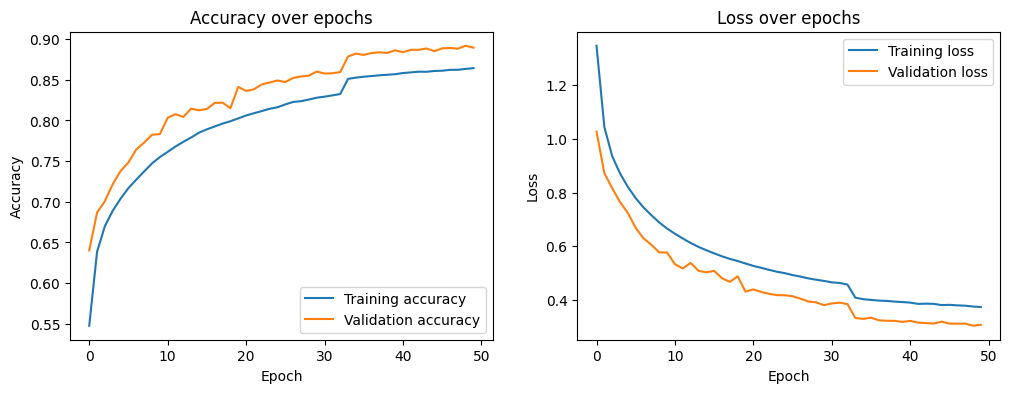

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

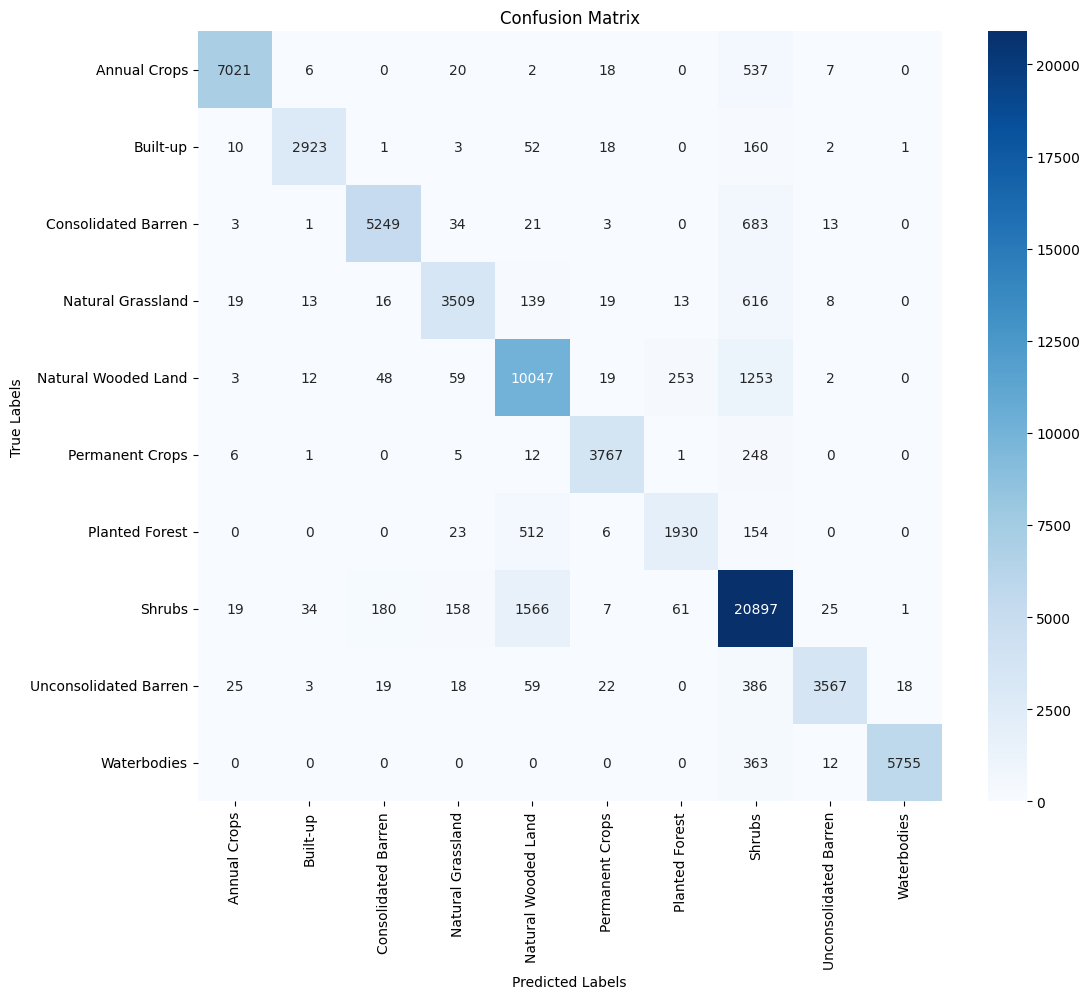

In [ ]:
# Use the `plot_confusion_matrix` function to visualize the model's classification performance.
# Plot the Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Load and visualize individual images
filtered_samples_df = samples_df[['Sample_num', 'Label', 'File']].drop_duplicates()
for index, row in filtered_samples_df.iterrows():
  image_path = os.path.join(images_path, row['File'])
  if os.path.exists(image_path):
    load_predict_and_visualize(image_path, row['Label'], model, label_encoder)
  else:
    print(f"File not found: {image_path}")